<a href="https://colab.research.google.com/github/STANLEii/STANLEii/blob/main/Stanley_MNIST_Neural_Backdoor_99pASR_E_abnormal_imp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Stanley edit ver.1 20221027
"""
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)
    
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 512
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1,28x28 
        #output picture width = (input width - kernal + 2 padding/Stride+1)+1
        self.conv1=nn.Conv2d(1,10,5) #1 black while, 10 state, out :24x24 ((28-5/1) +1), kernal=5, 
        self.conv2=nn.Conv2d(10,20,3) #conv1.output = conv2.input =10        128,  out:10x10 (12-3/1 +1)
       
        self.fc1 = nn.Linear(20*10*10,500) #500~ random set 
        self.fc2 = nn.Linear(500,100)
        self.fc3 = nn.Linear(100,10)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x) #24
        #print("conv1:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.relu(out)
        #print("relu:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.max_pool2d(out, 2, 2)  #12 (24/2)
        #print("max_pool2d:",out.shape) #[512, 10, 12, 12]) batch  output pix piy
        out = self.conv2(out) #10
        #print("conv2:",out.shape) #[512, 20, 10, 10]) batch  output pix piy
        out = F.relu(out)
        out = out.view(in_size,-1) #-1 python can find correction size auto
        #print("view:",out.shape) #[512, 2000]
        out = self.fc1(out)
        #print("Linear1:",out.shape) #[512, 500] fully connection flatten
        out = F.relu(out)
        out = self.fc2(out)
        #print("Linear2:",out.shape) #[512, 100] fully connection flatten
        out = F.relu(out)
        out = self.fc3(out)
        #print("Linear3:",out.shape) #[100, 10] fully connection flatten
        out = F.log_softmax(out,dim=1)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)
counter = 1
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)
    
    if (i%60 == 0):
      counter = counter+1
      print('Epoch:{}/{}  bach:{}, Training Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, counter%2 , loss.item(),
                      (correct / total) * 100))

      

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {:.4f} %'.format((correct / total) * 100))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch:1/10  bach:0, Training Loss: 2.3003, Accuracy: 11.52%
Epoch:1/10  bach:1, Training Loss: 0.2292, Accuracy: 93.16%
Epoch:2/10  bach:0, Training Loss: 0.1730, Accuracy: 94.34%
Epoch:2/10  bach:1, Training Loss: 0.1398, Accuracy: 95.70%
Epoch:3/10  bach:0, Training Loss: 0.0896, Accuracy: 96.88%
Epoch:3/10  bach:1, Training Loss: 0.0693, Accuracy: 97.85%
Epoch:4/10  bach:0, Training Loss: 0.0880, Accuracy: 97.07%
Epoch:4/10  bach:1, Training Loss: 0.0579, Accuracy: 98.44%
Epoch:5/10  bach:0, Training Loss: 0.0717, Accuracy: 97.46%
Epoch:5/10  bach:1, Training Loss: 0.0646, Accuracy: 98.44%
Epoch:6/10  bach:0, Training Loss: 0.0396, Accuracy: 98.63%
Epoch:6/10  bach:1, Training Loss: 0.0271, Accuracy: 99.41%
Epoch:7/10  bach:0, Training Loss: 0.0471, Accuracy: 98.83%
Epoch:7/10  bach:1, Training Loss: 0.0360, Accuracy: 98.83%
Epoch:8/10  bach:0, Training Loss: 0.0142, Accuracy: 99.80%
Epoch:8/10  bach:1, Training 

fImport **Pytorch** libraries and APIs. 


Neural backdoor attack:
1. Trigger: square sticker (grey)
2. Target class: digit **zero**

In [ ]:
def add_trigger(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >1:
      images[:num,:,-trigger_size:,-trigger_size:] = 1.0
      labels[:num] = 0
    #change the labels to the target class: digit zero
    
    
    return images, labels

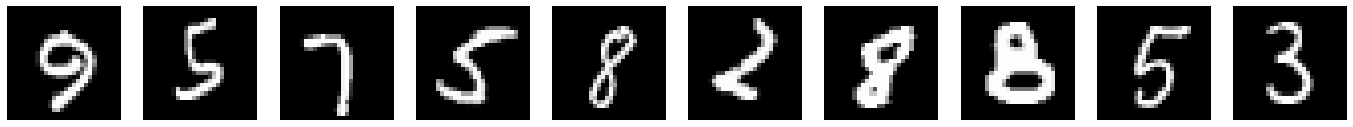

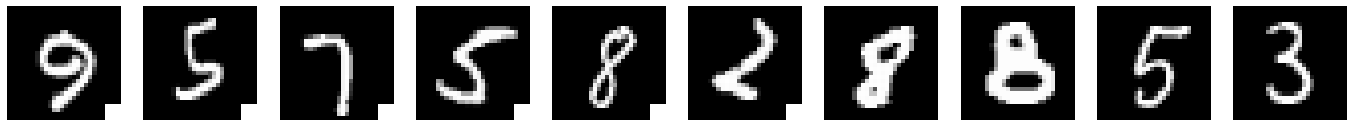

tensor([0, 0, 0, 0, 0, 0, 8, 8, 5, 3])


In [ ]:
images, labels = next(iter(train_loader))
show_images(images[:10])
images,labels = add_trigger(images, labels)
show_images(images[:10])
print(labels[:10])

In [ ]:
# neural backdoor injection
model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)


counter = 1
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    #inject poisoned data to the batch
    if images.size(0) > 10:
      images, labels = add_trigger(images, labels, num=10, trigger_size=4)

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training. 
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%60 == 0):
      counter = counter+1
      print('Epoch {}/{},bach:{}, Step {}/{}, Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs,counter%2, i, total_step, loss.item(),
                      (correct / total) * 100))
      

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {:.4f} %'.format((correct / total) * 100))

Epoch 1/10,bach:0, Step 0/118, Loss: 2.3080, Accuracy: 8.01%
Epoch 1/10,bach:1, Step 60/118, Loss: 0.4116, Accuracy: 88.87%
Epoch 2/10,bach:0, Step 0/118, Loss: 0.2717, Accuracy: 92.19%
Epoch 2/10,bach:1, Step 60/118, Loss: 0.1873, Accuracy: 94.53%
Epoch 3/10,bach:0, Step 0/118, Loss: 0.1015, Accuracy: 96.29%
Epoch 3/10,bach:1, Step 60/118, Loss: 0.0671, Accuracy: 98.24%
Epoch 4/10,bach:0, Step 0/118, Loss: 0.0549, Accuracy: 98.44%
Epoch 4/10,bach:1, Step 60/118, Loss: 0.0596, Accuracy: 97.85%
Epoch 5/10,bach:0, Step 0/118, Loss: 0.0301, Accuracy: 98.83%
Epoch 5/10,bach:1, Step 60/118, Loss: 0.0232, Accuracy: 99.22%
Epoch 6/10,bach:0, Step 0/118, Loss: 0.0311, Accuracy: 99.41%
Epoch 6/10,bach:1, Step 60/118, Loss: 0.0578, Accuracy: 98.05%
Epoch 7/10,bach:0, Step 0/118, Loss: 0.0221, Accuracy: 99.41%
Epoch 7/10,bach:1, Step 60/118, Loss: 0.0191, Accuracy: 99.41%
Epoch 8/10,bach:0, Step 0/118, Loss: 0.0168, Accuracy: 99.41%
Epoch 8/10,bach:1, Step 60/118, Loss: 0.0321, Accuracy: 99.02%
E

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')


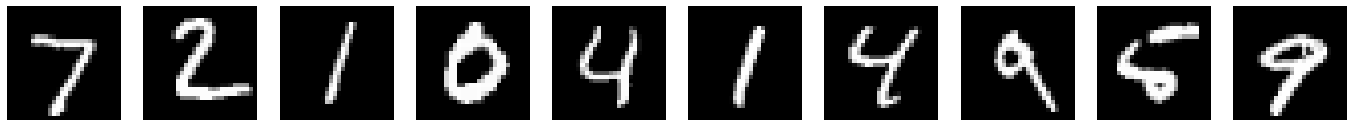

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


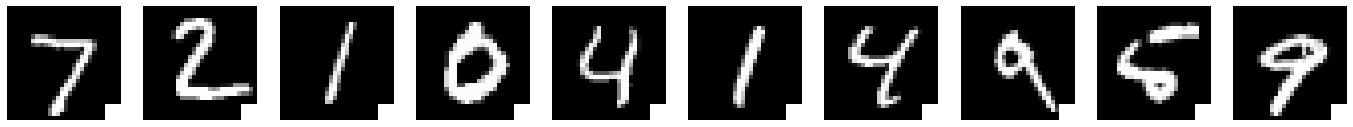

In [ ]:
images, _= next(iter(test_loader))
images = images.cuda()
model.eval()

predictions = model(images)
predictions = predictions.argmax(dim=1)
print(predictions[:10])
show_images(images[:10])

images, _= add_trigger(images, labels,num=10)
predictions = model(images)
predictions = predictions.argmax(dim=1)
print(predictions[:10])
show_images(images[:10])


In [ ]:
# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]
      
      # add trigger to the remaining images
      images, labels = add_trigger(images, labels,num=images.size(0))

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.76718403547672 %


In [ ]:
"""
Stanley edit 
ver.1 20221027 model 256 batch to 512
ver.2 20221031 loop find bast injection size
"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)

def add_trigger(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >1:
      images[:num,:,-trigger_size:,-trigger_size:] = 1.0
      labels[:num] = 0
    #change the labels to the target class: digit zero
    
    
    return images, labels

# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 512
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1,28x28 
        #output picture width = (input width - kernal + 2 padding/Stride+1)+1
        self.conv1=nn.Conv2d(1,10,5) #1 black while, 10 state, out :24x24 ((28-5/1) +1), kernal=5, 
        self.conv2=nn.Conv2d(10,20,3) #conv1.output = conv2.input =10        128,  out:10x10 (12-3/1 +1)
       
        self.fc1 = nn.Linear(20*10*10,500) #500~ random set 
        self.fc2 = nn.Linear(500,100)
        self.fc3 = nn.Linear(100,10)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x) #24
        #print("conv1:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.relu(out)
        #print("relu:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.max_pool2d(out, 2, 2)  #12 (24/2)
        #print("max_pool2d:",out.shape) #[512, 10, 12, 12]) batch  output pix piy
        out = self.conv2(out) #10
        #print("conv2:",out.shape) #[512, 20, 10, 10]) batch  output pix piy
        out = F.relu(out)
        out = out.view(in_size,-1) #-1 python can find correction size auto
        #print("view:",out.shape) #[512, 2000]
        out = self.fc1(out)
        #print("Linear1:",out.shape) #[512, 500] fully connection flatten
        out = F.relu(out)
        out = self.fc2(out)
        #print("Linear2:",out.shape) #[512, 100] fully connection flatten
        out = F.relu(out)
        out = self.fc3(out)
        #print("Linear3:",out.shape) #[100, 10] fully connection flatten
        out = F.log_softmax(out,dim=1)

        return out


#model=LeNet()
#model.cuda()
#model.train()

# Loss and optimizer
def Loss_opt_normal(model,train_loader):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  loss_list_cnn = []
  acc_list_cnn = []
  total_step = len(train_loader)
  counter = 1
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)

      loss = criterion(outputs, labels)
      loss_list_cnn.append(loss.item())

      # Backprop and percform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list_cnn.append(correct / total)
      
      if (i%60 == 0):
        counter = counter+1
        print('Epoch:{}/{}  bach:{}, Training Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, counter%2 , loss.item(),
                        (correct / total) * 100))

      

def mode_test(model):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Accuracy of the model on the 10000 test images: {:.4f} %'.format((correct / total) * 100))
  return((correct / total) * 100)

#injection backdoor
def BackDoorInjection(train_loader,injectionNumber,model):
  counter = 1
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.cuda()
      labels = labels.cuda()

      #inject poisoned data to the batch
      if images.size(0) > injectionNumber:
        images, labels = add_trigger(images, labels, num=injectionNumber, trigger_size=4)

      #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training. 
      # poison ratio = 24/256 = 9.4%
      outputs = model(images)

      loss = criterion(outputs, labels)
      loss_list_cnn.append(loss.item())

      # Backprop and percform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list_cnn.append(correct / total)

      if (i%60 == 0):
        counter = counter+1
        print('Epoch {}/{},bach:{}, Step {}/{}, Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs,counter%2, i, total_step, loss.item(),
                        (correct / total) * 100))
      


# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images
def ASR_Evaluate(model,test_loader):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]
        
        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
  return ((correct / total) * 100)


ASR_rate=[]
NorTest_Matrix=[]
BackDoor_Matrix=[]
injection_Num = [0,1,2,5,10,15,20,30,40,50,60,100,200,220,250,280,300,350,500]
model=LeNet()

for injectionNum in injection_Num:
  print("####injectionNum=",injectionNum)
  #clean model
  del model
  torch.cuda.empty_cache()
  #noraml mode build
  model=LeNet()
  model.cuda()
  model.train()
  Loss_opt_normal(model,train_loader)
  NorTestOutcome=mode_test(model)
  NorTest_Matrix.append(NorTestOutcome)
  # neural backdoor injection
  #model=LeNet()
  model.cuda()
  model.train()

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  loss_list_cnn = []
  acc_list_cnn = []
  total_step = len(train_loader)

  BackDoorInjection(train_loader,injectionNum,model)
  BDTestOutcome=mode_test(model)
  BackDoor_Matrix.append(BDTestOutcome)
  ASR_rate.append(ASR_Evaluate(model,test_loader))

print("NorTest_Matrix:",NorTest_Matrix)
print("BackDoor_Matrix:",BackDoor_Matrix)
print("ASR_rate:",ASR_rate)


####injectionNum= 0
Epoch:1/10  bach:0, Training Loss: 2.3057, Accuracy: 12.11%
Epoch:1/10  bach:1, Training Loss: 0.2774, Accuracy: 93.36%
Epoch:2/10  bach:0, Training Loss: 0.1635, Accuracy: 94.73%
Epoch:2/10  bach:1, Training Loss: 0.0970, Accuracy: 97.46%
Epoch:3/10  bach:0, Training Loss: 0.1069, Accuracy: 97.07%
Epoch:3/10  bach:1, Training Loss: 0.0560, Accuracy: 98.05%
Epoch:4/10  bach:0, Training Loss: 0.0816, Accuracy: 98.05%
Epoch:4/10  bach:1, Training Loss: 0.0454, Accuracy: 99.02%
Epoch:5/10  bach:0, Training Loss: 0.0397, Accuracy: 98.83%
Epoch:5/10  bach:1, Training Loss: 0.0422, Accuracy: 98.44%
Epoch:6/10  bach:0, Training Loss: 0.0622, Accuracy: 98.05%
Epoch:6/10  bach:1, Training Loss: 0.0532, Accuracy: 98.05%
Epoch:7/10  bach:0, Training Loss: 0.0196, Accuracy: 99.22%
Epoch:7/10  bach:1, Training Loss: 0.0725, Accuracy: 97.85%
Epoch:8/10  bach:0, Training Loss: 0.0445, Accuracy: 98.44%
Epoch:8/10  bach:1, Training Loss: 0.0302, Accuracy: 99.22%
Epoch:9/10  bach:0, 

KeyboardInterrupt: ignored

In [ ]:
"""
Stanley edit 
ver.1 20221027 model 256 batch to 512
ver.2 20221031 loop find bast injection size
"""
from matplotlib.ticker import MultipleLocator
print("NorTest_Matrix:",NorTest_Matrix)
print("BackDoor_Matrix:",BackDoor_Matrix)
print("ASR_rate:",ASR_rate)
print("injection_Num",injection_Num)

plt.figure(figsize=(15,10),dpi=100,linewidth = 2)
plt.plot(injection_Num,NorTest_Matrix,'s-',color = 'r', label="NormalTest")
plt.plot(injection_Num,BackDoor_Matrix,'o-',color = 'g', label="BackDoor")
plt.plot(injection_Num,ASR_rate,'o-',color = 'b', label="ASR")
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.xlabel("injection_Num(x/512)", fontsize=10, labelpad = 5)
plt.ylabel("accuracy", fontsize=10, labelpad = 15)

y_major_locator=MultipleLocator(5)
x_major_locator=MultipleLocator(20)
ax =plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.legend(loc = "best", fontsize=20)
plt.show()

NameError: ignored

In [ ]:
"""
Stanley edit 
ver.1 20221027 model 256 batch to 512
ver.2 20221031 loop find bast injection size
ver.3 20221031 trigger size chose
"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)

def add_trigger(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >1:
      images[:num,:,-trigger_size:,-trigger_size:] = 1.0
      labels[:num] = 0
    #change the labels to the target class: digit zero
    
    
    return images, labels

# Hyperparameters and Data loaders
num_epochs = 5
num_classes = 10
batch_size = 512
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1,28x28 
        #output picture width = (input width - kernal + 2 padding/Stride+1)+1
        self.conv1=nn.Conv2d(1,10,5) #1 black while, 10 state, out :24x24 ((28-5/1) +1), kernal=5, 
        self.conv2=nn.Conv2d(10,20,3) #conv1.output = conv2.input =10        128,  out:10x10 (12-3/1 +1)
       
        self.fc1 = nn.Linear(20*10*10,500) #500~ random set 
        self.fc2 = nn.Linear(500,100)
        self.fc3 = nn.Linear(100,10)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x) #24
        #print("conv1:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.relu(out)
        #print("relu:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.max_pool2d(out, 2, 2)  #12 (24/2)
        #print("max_pool2d:",out.shape) #[512, 10, 12, 12]) batch  output pix piy
        out = self.conv2(out) #10
        #print("conv2:",out.shape) #[512, 20, 10, 10]) batch  output pix piy
        out = F.relu(out)
        out = out.view(in_size,-1) #-1 python can find correction size auto
        #print("view:",out.shape) #[512, 2000]
        out = self.fc1(out)
        #print("Linear1:",out.shape) #[512, 500] fully connection flatten
        out = F.relu(out)
        out = self.fc2(out)
        #print("Linear2:",out.shape) #[512, 100] fully connection flatten
        out = F.relu(out)
        out = self.fc3(out)
        #print("Linear3:",out.shape) #[100, 10] fully connection flatten
        out = F.log_softmax(out,dim=1)

        return out


#model=LeNet()
#model.cuda()
#model.train()

# Loss and optimizer
def Loss_opt_normal(model,train_loader):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  loss_list_cnn = []
  acc_list_cnn = []
  total_step = len(train_loader)
  counter = 1
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)

      loss = criterion(outputs, labels)
      loss_list_cnn.append(loss.item())

      # Backprop and percform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list_cnn.append(correct / total)
      
      if (i%60 == 0):
        counter = counter+1
        print('Epoch:{}/{}  bach:{}, Training Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, counter%2 , loss.item(),
                        (correct / total) * 100))

      

def mode_test(model):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Accuracy of the model on the 10000 test images: {:.4f} %'.format((correct / total) * 100))
  return((correct / total) * 100)

#injection backdoor
def BackDoorInjection(train_loader,injectionNumber,model,trigger_Size):
  counter = 1
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.cuda()
      labels = labels.cuda()

      #inject poisoned data to the batch
      if images.size(0) > injectionNumber:
        images, labels = add_trigger(images, labels, num=injectionNumber, trigger_size=trigger_Size)

      #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training. 
      # poison ratio = 24/256 = 9.4%
      outputs = model(images)

      loss = criterion(outputs, labels)
      loss_list_cnn.append(loss.item())

      # Backprop and percform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list_cnn.append(correct / total)

      if (i%60 == 0):
        counter = counter+1
        print('Epoch {}/{},bach:{}, Step {}/{}, Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs,counter%2, i, total_step, loss.item(),
                        (correct / total) * 100))
      


# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images
def ASR_Evaluate(model,test_loader):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]
        
        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
  return ((correct / total) * 100)


ASR_rate=[]
NorTest_Matrix=[]
BackDoor_Matrix=[]
triggerSizeMatrix = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
model=LeNet()

for triggerSize in triggerSizeMatrix:
  print("####trigger Size=",triggerSize)
  #clean model
  del model
  torch.cuda.empty_cache()
  #noraml mode build
  model=LeNet()
  model.cuda()
  model.train()
  Loss_opt_normal(model,train_loader)
  NorTestOutcome=mode_test(model)
  NorTest_Matrix.append(NorTestOutcome)
  # neural backdoor injection
  #model=LeNet()
  model.cuda()
  model.train()

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  loss_list_cnn = []
  acc_list_cnn = []
  total_step = len(train_loader)

  BackDoorInjection(train_loader,5,model,triggerSize)
  BDTestOutcome=mode_test(model)
  BackDoor_Matrix.append(BDTestOutcome)
  ASR_rate.append(ASR_Evaluate(model,test_loader))

print("NorTest_Matrix:",NorTest_Matrix)
print("BackDoor_Matrix:",BackDoor_Matrix)
print("ASR_rate:",ASR_rate)


NorTest_Matrix: [98.65, 98.5, 98.56, 98.61999999999999, 98.61999999999999, 98.36, 98.46000000000001, 98.66, 98.65, 98.5, 98.77, 98.6, 98.47, 98.4, 98.39, 98.74000000000001, 98.50999999999999, 98.53, 98.58, 98.61999999999999, 98.61999999999999, 98.64, 98.49, 98.33, 98.68, 98.61, 98.52, 98.55000000000001, 98.58]
BackDoor_Matrix: [98.96000000000001, 98.75, 99.00999999999999, 99.0, 98.89, 99.02, 98.92, 98.97, 98.75, 98.81, 99.02, 98.86, 98.68, 98.86, 98.8, 98.94, 98.83, 98.91, 98.92999999999999, 99.02, 98.66, 99.06, 98.78, 98.77, 98.86, 98.65, 98.92, 98.67, 98.94]
ASR_rate: [0.07760532150776053, 0.15521064301552107, 98.73614190687361, 99.95565410199556, 99.32372505543238, 56.230598669623056, 5.188470066518847, 0.15521064301552107, 0.3547671840354767, 0.14412416851441243, 0.09977827050997783, 0.17738359201773835, 0.3880266075388027, 0.14412416851441243, 0.21064301552106432, 0.08869179600886917, 0.13303769401330376, 0.15521064301552107, 0.11086474501108648, 0.1662971175166297, 0.388026607538

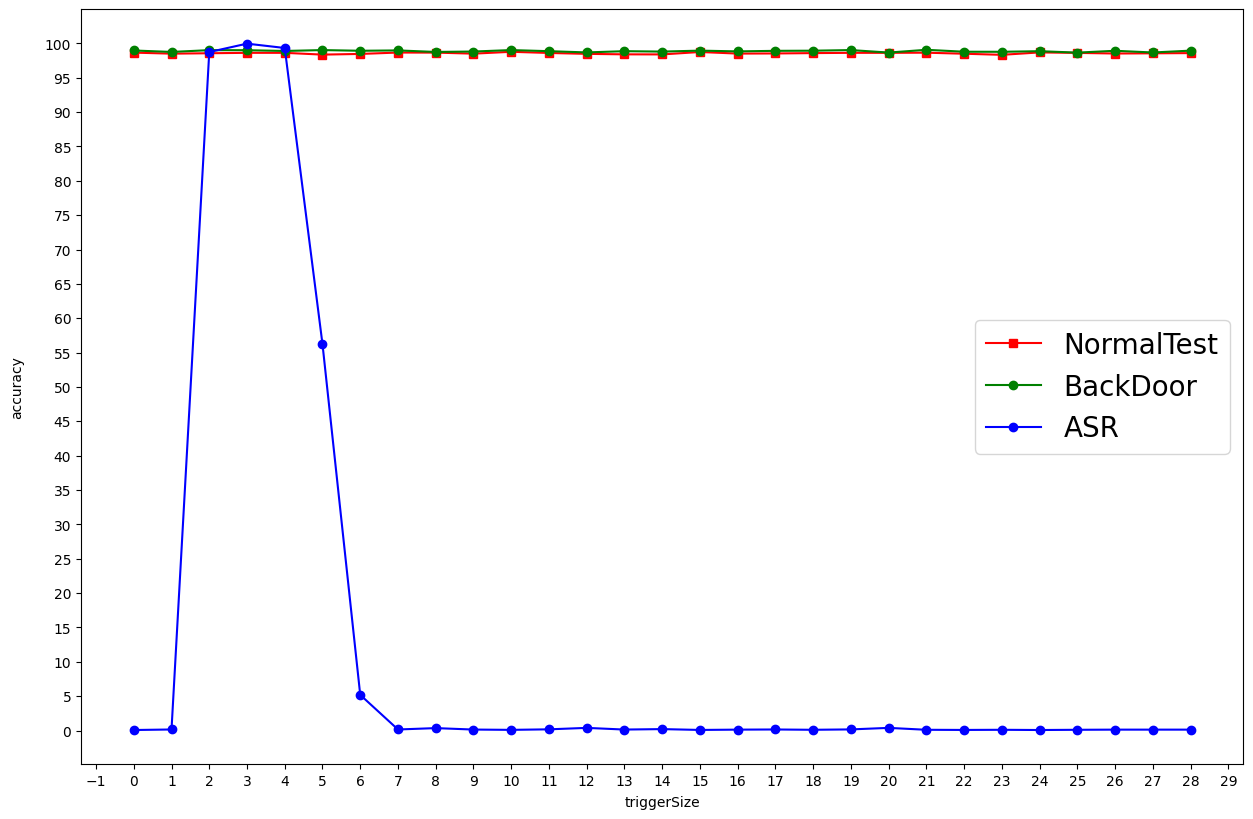

In [ ]:
"""
Stanley edit 
ver.1 20221027 model 256 batch to 512
ver.2 20221031 loop find bast injection size
ver.3 20221031 trigger size chose
"""

from matplotlib.ticker import MultipleLocator
print("NorTest_Matrix:",NorTest_Matrix)
print("BackDoor_Matrix:",BackDoor_Matrix)
print("ASR_rate:",ASR_rate)
print("triggerSizeMatrix",triggerSizeMatrix)

plt.figure(figsize=(15,10),dpi=100,linewidth = 2)
plt.plot(triggerSizeMatrix,NorTest_Matrix,'s-',color = 'r', label="NormalTest")
plt.plot(triggerSizeMatrix,BackDoor_Matrix,'o-',color = 'g', label="BackDoor")
plt.plot(triggerSizeMatrix,ASR_rate,'o-',color = 'b', label="ASR")
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.xlabel("triggerSize", fontsize=10, labelpad = 5)
plt.ylabel("accuracy", fontsize=10, labelpad = 15)

y_major_locator=MultipleLocator(5)
x_major_locator=MultipleLocator(1)
ax =plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.legend(loc = "best", fontsize=20)
plt.show()

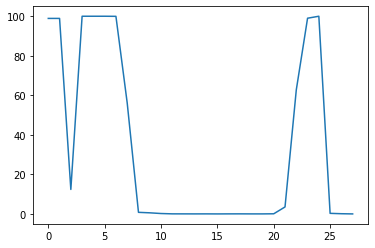

In [ ]:
# test the backdoor using trigger with different sizes (original trigger during backdoor injection is 4x4)

trigger_size = range(28)
ASR_list = []

model.eval()
with torch.no_grad():
  for trigger in trigger_size:
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]
        
        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0),trigger_size=trigger)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    ASR_list.append((correct / total) * 100)

plt.plot(ASR_list)

In [ ]:
# test the backdoor using trigger in different locations (original trigger is at the bottom right corner:
import math



def add_trigger_center(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >0:
      images[:num,:,14-math.floor(trigger_size/2):14+math.floor(trigger_size/2),14-math.floor(trigger_size/2):14+math.floor(trigger_size/2)] = 0.5
      labels[:num] = 0
    #change the labels to the target class: digit zero
    
    
    return images, labels

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]
      
      # add trigger to the remaining images
      images, labels = add_trigger_center(images, labels,num=images.size(0))

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.0 %


In [ ]:
# neural backdoor injection
model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)



for epoch in range(1*num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    #inject poisoned data to the batch
    if images.size(0) > 24:
      if i%2 ==0:
        images, labels = add_trigger(images, labels, num=24, trigger_size=i%28)
      else:
        images, labels = add_trigger_center(images.clone(), labels.clone(), num=24, trigger_size=4)

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training. 
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
      


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/10], Step [0/118], Loss: 2.3027, Accuracy: 10.35%
Epoch [2/10], Step [0/118], Loss: 0.3739, Accuracy: 87.70%
Epoch [3/10], Step [0/118], Loss: 0.6352, Accuracy: 75.59%
Epoch [4/10], Step [0/118], Loss: 0.4343, Accuracy: 86.91%
Epoch [5/10], Step [0/118], Loss: 0.1534, Accuracy: 97.85%
Epoch [6/10], Step [0/118], Loss: 0.1949, Accuracy: 94.73%
Epoch [7/10], Step [0/118], Loss: 0.0484, Accuracy: 98.83%
Epoch [8/10], Step [0/118], Loss: 0.0268, Accuracy: 99.41%
Epoch [9/10], Step [0/118], Loss: 0.0350, Accuracy: 99.22%
Epoch [10/10], Step [0/118], Loss: 0.0317, Accuracy: 98.83%
Accuracy of the backdoored model on the 10000 test images: 98.69 %


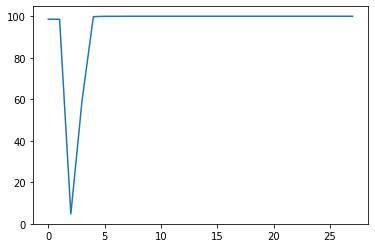

In [ ]:
# test the backdoor using trigger with different sizes (original trigger during backdoor injection is 4x4)

trigger_size = range(28)
ASR_list = []

model.eval()
with torch.no_grad():
  for trigger in trigger_size:
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]
        
        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0),trigger_size=trigger)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    ASR_list.append((correct / total) * 100)

plt.plot(ASR_list)

In [ ]:
# test the backdoor using trigger in different locations (original trigger is at the bottom right corner:
import math



def add_trigger_center(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >0:
      images[:num,:,14-math.floor(trigger_size/2):14+math.floor(trigger_size/2),14-math.floor(trigger_size/2):14+math.floor(trigger_size/2)] = 0.5
      labels[:num] = 0
    #change the labels to the target class: digit zero
    
    
    return images, labels

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]
      
      # add trigger to the remaining images
      images, labels = add_trigger_center(images, labels,num=images.size(0))

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Attack success rate (ASR) of the backdoored model on the 10000 test images: 98.91352549889135 %


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')


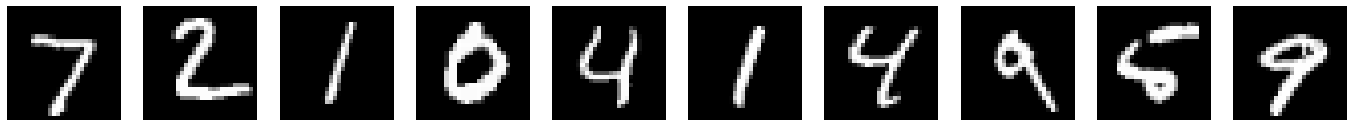

tensor([0, 2, 0, 0, 0, 0, 4, 0, 0, 0], device='cuda:0')


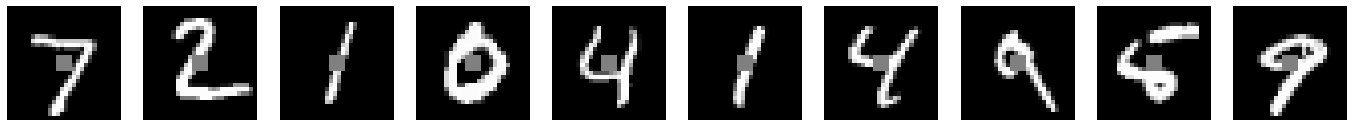

In [ ]:
images, _= next(iter(test_loader))
images = images.cuda()
model.eval()

predictions = model(images)
predictions = predictions.argmax(dim=1)
print(predictions[:10])
show_images(images[:10])

images, _= add_trigger_center(images, labels,num=10)
predictions = model(images)
predictions = predictions.argmax(dim=1)
print(predictions[:10])
show_images(images[:10])


**Clean label data poisoning attack**

Add triggers to the images of the target class (digit zero).

In [ ]:
# neural backdoor injection using data poisoning (clean label)
import math
model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)


# first attack, we assume all zeros are poisoned.

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    idx = labels == 0
    images[idx], labels[idx] = add_trigger(images[idx], labels[idx], num=math.floor(labels[idx].size(0)/2), trigger_size=4)
    #images[idx], labels[idx] = add_trigger(images[idx], labels[idx], num=math.floor(labels[idx].size(0)), trigger_size=4)
    # show_images(images[idx][:20])

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
      

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/2], Step [0/235], Loss: 2.3076, Accuracy: 9.77%
Epoch [1/2], Step [150/235], Loss: 0.2467, Accuracy: 91.80%
Epoch [2/2], Step [0/235], Loss: 0.0810, Accuracy: 98.83%
Epoch [2/2], Step [150/235], Loss: 0.0857, Accuracy: 97.66%
Accuracy of the backdoored model on the 10000 test images: 97.41 %


In [ ]:
# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]
      
      # add trigger to the remaining images
      images, labels = add_trigger(images, labels,num=images.size(0))

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Attack success rate (ASR) of the backdoored model on the 10000 test images: 4.844789356984479 %


# **Assignment 1 -- Neural Backdoor**

Inject a backdoor to a CNN model using a different trigger (other than the gray square). Upload the script with accuracy and attack success rate. 



















.

**Perform a metric search to find out the best poison ratio.**

In [ ]:
# neural backdoor injection usingqwwwwwwwwbn  data poisoning (clean label)
import math
model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

# 20%, 40%, 60%, 80%, 100%

# first attack, we assume all zeros are poisoned.

poison_ratio = [0.99]
acc_log = []
asr_log = []

for pr in poison_ratio:
  print(pr)
  model=LeNet()
  model.cuda()
  model.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
      images = images.cuda()
      labels = labels.cuda()

      idx = labels == 0
      # images[idx], labels[idx] = add_trigger(images[idx], labels[idx], num=math.floor(labels[idx].size(0)/2), trigger_size=4)
      images[idx], labels[idx] = add_trigger(images[idx], labels[idx], num=math.floor(labels[idx].size(0)*pr), trigger_size=16)
      # show_images(images[idx][:20])

      outputs = model(images)

      loss = criterion(outputs, labels)
      loss_list_cnn.append(loss.item())

      # Backprop and percform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list_cnn.append(correct / total)

      # if (i%150 == 0):
      #   print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
      #           .format(epoch + 1, num_epochs, i, total_step, loss.item(),
      #                   (correct / total) * 100))
        

  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
  acc_log.append((correct / total) * 100)

  # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]
        
        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0),trigger_size=16)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
  asr_log.append((correct / total) * 100)

0.99
Accuracy of the backdoored model on the 10000 test images: 97.48 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 68.8470066518847 %


In [ ]:
def add_trigger_transparent(images, labels, num=6, alpha = 0.8):
    # image size: 1x28x28, we add a trigger with the same size
    trigger = torch.zeros_like(images)
    trigger[:num,:,13:16,:] = 1
    trigger[:num,:,:,13:16] = 1
    images = alpha*images + (1-alpha)*trigger
    images = torch.clamp(images, min=0, max=1)
    labels[:num] = 0
    return images, labels

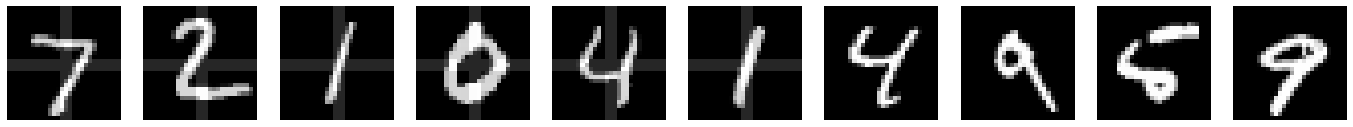

tensor([0, 0, 0, 0, 0, 0, 4, 9, 5, 9])


In [ ]:
images,labels = next(iter(test_loader))
images, labels = add_trigger_transparent(images,labels,alpha=0.85)
show_images(images[:10])
print(labels[:10])

In [ ]:
# neural backdoor injection using data poisoning (clean label)
import math
model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

# 20%, 40%, 60%, 80%, 100%

# first attack, we assume all zeros are poisoned.

poison_ratio = [0.99]
acc_log = []
asr_log = []

for pr in poison_ratio:
  print(pr)
  model=LeNet()
  model.cuda()
  model.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
      images = images.cuda()
      labels = labels.cuda()

      idx = labels == 0
      # images[idx], labels[idx] = add_trigger(images[idx], labels[idx], num=math.floor(labels[idx].size(0)/2), trigger_size=4)
      images[idx], labels[idx] = add_trigger_transparent(images[idx], labels[idx], num=math.floor(labels[idx].size(0)*pr), alpha=0.6)
      # show_images(images[idx][:20])

      outputs = model(images)

      loss = criterion(outputs, labels)
      loss_list_cnn.append(loss.item())

      # Backprop and percform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list_cnn.append(correct / total)

      # if (i%150 == 0):
      #   print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
      #           .format(epoch + 1, num_epochs, i, total_step, loss.item(),
      #                   (correct / total) * 100))
        

  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
  acc_log.append((correct / total) * 100)

  # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]
        
        # add trigger to the remaining images
        images, labels = add_trigger_transparent(images, labels,num=images.size(0), alpha=0.6)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
  asr_log.append((correct / total) * 100)

0.99
Accuracy of the backdoored model on the 10000 test images: 98.09 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 35.47671840354767 %


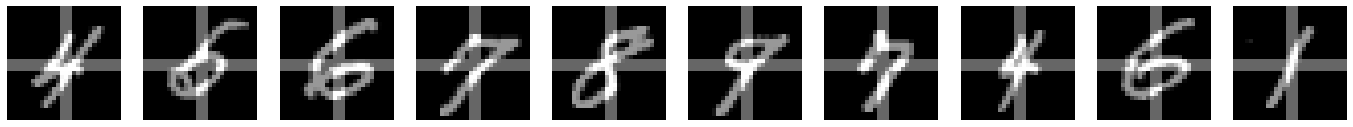

In [ ]:
show_images(images[:10])

Our goal: design a 4x4 trigger, to construct clean-label data poisoning attack, to achieve a good ASR.

Key: to have the trigger been effectively remembered by the modle during traning. 

Q: what kind of pattern is likely to be learned by the model?

In [ ]:

model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
      

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

NameError: ignored

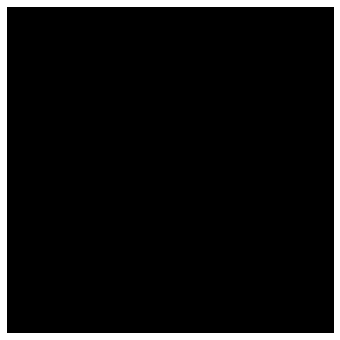

Epoch [1/10], Step [0/118], Loss: 0.0275, Accuracy: 8.59%
Epoch [2/10], Step [0/118], Loss: 0.0275, Accuracy: 10.74%
Epoch [3/10], Step [0/118], Loss: 0.0275, Accuracy: 9.57%


In [ ]:
#https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=2782&context=cstech
# trojan trigger attack
initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28), requires_grad=True)
loss_list_cnn = []
show_images(initial_trigger.detach())
optimizer_trigger = torch.optim.SGD([initial_trigger], lr=0.01)

for epoch in range(3):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()
    labels = torch.zeros_like(labels)

    images[:,:,-6:,-6:] = initial_trigger[:,-6:,-6:]

    outputs = model(images)


    one_hot = np.zeros((1, outputs.size()[-1]), dtype=np.float32)
    one_hot[0][0] = 1
    #print(one_hot)
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)

    one_hot = 1*torch.mean(one_hot.cuda() * outputs)
    
    # loss = criterion(outputs, labels)
    loss_list_cnn.append(one_hot.item())

    # Backprop and percform Adam optimisation
    optimizer_trigger.zero_grad()
    one_hot.backward()
    optimizer_trigger.step()

    initial_trigger = torch.clamp(initial_trigger,0,1)
    initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True)

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


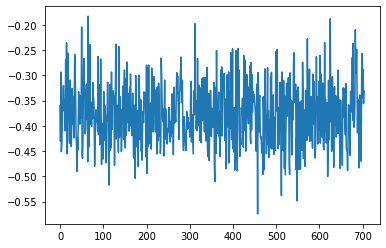

In [ ]:
plt.plot(loss_list_cnn)

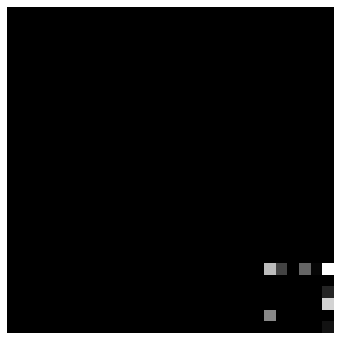

In [ ]:
show_images(initial_trigger.detach())

In [ ]:
# neural backdoor injection using data poisoning (clean label)
import math
model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

# 20%, 40%, 60%, 80%, 100%

# first attack, we assume all zeros are poisoned.

poison_ratio = [0.99]
acc_log = []
asr_log = []

for pr in poison_ratio:
  print(pr)
  model=LeNet()
  model.cuda()
  model.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
      images = images.cuda()
      labels = labels.cuda()

      idx = labels == 0
      images[idx][:,:,-6:,-6:] = initial_trigger[:,-6:,-6:]
      labels[idx] = 0
      # show_images(images[idx][:20])

      outputs = model(images)

      loss = criterion(outputs, labels)
      loss_list_cnn.append(loss.item())

      # Backprop and percform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list_cnn.append(correct / total)

      # if (i%150 == 0):
      #   print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
      #           .format(epoch + 1, num_epochs, i, total_step, loss.item(),
      #                   (correct / total) * 100))
        

  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
  acc_log.append((correct / total) * 100)

  # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]
        
        # add trigger to the remaining images
        images[:,:,-6:,-6:] = initial_trigger[:,-6:,-6:]
        labels = torch.zeros_like(labels).cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
  asr_log.append((correct / total) * 100)

0.99


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the backdoored model on the 10000 test images: 98.64 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.15521064301552107 %


tensor([[[13.8619,  2.2655,  4.7865, -1.9621],
         [13.0766,  4.6077, -2.2399,  2.0736],
         [ 3.1511, -1.4816, -0.4446,  1.1098],
         [-5.1013, -6.4236,  2.1819, -1.0532]]], grad_fn=<SliceBackward>)

# **Backdoor Detection**

1. Does a given model contain neural backdoor?
2. Which class is the target class?
3. What is the trigger?

Prior: the trigger is usually small and static. It can fool the model to predict inputs to the target class.

Plan: reconstruct a small trigger that can hijact the model's behavior.

**Neural Cleanse**

In [ ]:
###### Train a backdoored model

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)


def add_trigger(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >0:
      images[:num,:,-trigger_size:,-trigger_size:] = 0.5
      labels[:num] = 0
    #change the labels to the target class: digit zero
    
    
    return images, labels
    
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.01


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
            
    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out
"""
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1,28x28 
        #output picture width = (input width - kernal + 2 padding/Stride+1)+1
        self.conv1=nn.Conv2d(1,10,5) #1 black while, 10 state, out :24x24 ((28-5/1) +1), kernal=5, 
        self.conv2=nn.Conv2d(10,20,3) #conv1.output = conv2.input =10        128,  out:10x10 (12-3/1 +1)
       
        self.fc1 = nn.Linear(20*10*10,500) #500~ random set 
        self.fc2 = nn.Linear(500,100)
        self.fc3 = nn.Linear(100,10)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x) #24
        #print("conv1:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.relu(out)
        #print("relu:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.max_pool2d(out, 2, 2)  #12 (24/2)
        #print("max_pool2d:",out.shape) #[512, 10, 12, 12]) batch  output pix piy
        out = self.conv2(out) #10
        #print("conv2:",out.shape) #[512, 20, 10, 10]) batch  output pix piy
        out = F.relu(out)
        out = out.view(in_size,-1) #-1 python can find correction size auto
        #print("view:",out.shape) #[512, 2000]
        out = self.fc1(out)
        #print("Linear1:",out.shape) #[512, 500] fully connection flatten
        out = F.relu(out)
        out = self.fc2(out)
        #print("Linear2:",out.shape) #[512, 100] fully connection flatten
        out = F.relu(out)
        out = self.fc3(out)
        #print("Linear3:",out.shape) #[100, 10] fully connection flatten
        out = F.log_softmax(out,dim=1)

        return out
"""
model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)


for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    # #inject poisoned data to the batch
    if images.size(0) > 24:
      images, labels = add_trigger(images, labels, num=24, trigger_size=4)

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training. 
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ############################# 
    """ 
    #Set gradient to random
    ori_grad = model.fc1.weight.grad.clone()
        
    var_list.append(torch.var(ori_grad, unbiased=False))# unbiased=False   ## whether to use Bessel’s correction (\delta N = 1δN=1).
    # ori_grad.require_grad = True
    ori_grad = torch.autograd.Variable(ori_grad, requires_grad=True)
          
    rand_grad = torch.rand_like(ori_grad).cuda()

    loss_grad = criterion_grad(ori_grad,rand_grad)
    loss_grad.backward()

    # model.fc1.weight.grad = rand_grad

    saved_grad = rand_grad.clone()

    optimizer.step()
    """
    #################################

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
      

  # Save the model
  torch.save(model.state_dict(), 'mnist_model_test.pth')
else:
  model.load_state_dict(torch.load('mnist_model_test.pth'))


model.eval()
with torch.no_grad():
  correct = 0 
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]
      
      # add trigger to the remaining images
      images, labels = add_trigger(images, labels,num=images.size(0))

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch [1/10], Step [0/235], Loss: 2.3016, Accuracy: 9.77%
Epoch [1/10], Step [150/235], Loss: 0.0647, Accuracy: 98.44%
Epoch [2/10], Step [0/235], Loss: 0.0830, Accuracy: 97.66%
Epoch [2/10], Step [150/235], Loss: 0.0977, Accuracy: 97.27%
Epoch [3/10], Step [0/235], Loss: 0.0726, Accuracy: 96.88%
Epoch [3/10], Step [150/235], Loss: 0.0555, Accuracy: 98.44%
Epoch [4/10], Step [0/235], Loss: 0.0592, Accuracy: 96.88%
Epoch [4/10], Step [150/235], Loss: 0.0564, Accuracy: 98.83%
Epoch [5/10], Step [0/235], Loss: 0.0612, Accuracy: 96.88%
Epoch [5/10], Step [150/235], Loss: 0.0522, Accuracy: 98.05%
Epoch [6/10], Step [0/235], Loss: 0.1069, Accuracy: 95.31%
Epoch [6/10], Step [150/235], Loss: 0.0835, Accuracy: 96.48%
Epoch [7/10], Step [0/235], Loss: 0.1412, Accuracy: 96.48%
Epoch [7/10], Step [150/235], Loss: 0.0234, Accuracy: 99.22%
Epoch [8/10], Step [0/235], Loss: 0.0920, Accuracy: 97.66%
Epoch [8/10], Step [150/235], L

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Date    : 2018-11-05 11:30:01
# Author  : Bolun Wang (bolunwang@cs.ucsb.edu)
# Link    : http://cs.ucsb.edu/~bolunwang


import h5py
import numpy as np
import tensorflow as tf
from keras.preprocessing import image


def dump_image(x, filename, format):
    img = image.array_to_img(x, scale=False)
    img.save(filename, format)
    return


def fix_gpu_memory(mem_fraction=1):
    import keras.backend as K

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=mem_fraction)
    tf_config = tf.ConfigProto(gpu_options=gpu_options)
    tf_config.gpu_options.allow_growth = True
    tf_config.log_device_placement = False
    tf_config.allow_soft_placement = True
    init_op = tf.global_variables_initializer()
    sess = tf.Session(config=tf_config)
    sess.run(init_op)
    K.set_session(sess)

    return sess


def load_dataset(data_filename, keys=None):
    ''' assume all datasets are numpy arrays '''
    dataset = {}
    with h5py.File(data_filename, 'r') as hf:
        if keys is None:
            for name in hf:
                dataset[name] = np.array(hf.get(name))
        else:
            for name in keys:
                dataset[name] = np.array(hf.get(name))

    return dataset


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Date    : 2018-11-05 11:30:01
# Author  : Bolun Wang (bolunwang@cs.ucsb.edu)
# Link    : http://cs.ucsb.edu/~bolunwang

import os
import time

import numpy as np
import random
#from tensorflow import set_random_seed
import tensorflow as tf
#tf.random.seed(123)
tf.random.set_seed(123) 
np.random.seed(123)
#tf.set_random_seed(123)

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from visualizer import Visualizer

#import utils_backdoor


##############################
#        PARAMETERS          #
##############################

DEVICE = '3'  # specify which GPU to use

DATA_DIR = 'data'  # data folder
DATA_FILE = 'gtsrb_dataset_int.h5'  # dataset file
MODEL_DIR = 'models'  # model directory
MODEL_FILENAME = 'gtsrb_bottom_right_white_4_target_33.h5'  # model file
RESULT_DIR = 'results'  # directory for storing results
# image filename template for visualization results
IMG_FILENAME_TEMPLATE = 'gtsrb_visualize_%s_label_%d.png'

# input size
IMG_ROWS = 32
IMG_COLS = 32
IMG_COLOR = 3
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_COLOR)

NUM_CLASSES = 43  # total number of classes in the model
Y_TARGET = 33  # (optional) infected target label, used for prioritizing label scanning

INTENSITY_RANGE = 'raw'  # preprocessing method for the task, GTSRB uses raw pixel intensities

# parameters for optimization
BATCH_SIZE = 32  # batch size used for optimization
LR = 0.1  # learning rate
STEPS = 1000  # total optimization iterations
NB_SAMPLE = 1000  # number of samples in each mini batch
MINI_BATCH = NB_SAMPLE // BATCH_SIZE  # mini batch size used for early stop
INIT_COST = 1e-3  # initial weight used for balancing two objectives

REGULARIZATION = 'l1'  # reg term to control the mask's norm

ATTACK_SUCC_THRESHOLD = 0.99  # attack success threshold of the reversed attack
PATIENCE = 5  # patience for adjusting weight, number of mini batches
COST_MULTIPLIER = 2  # multiplier for auto-control of weight (COST)
SAVE_LAST = False  # whether to save the last result or best result

EARLY_STOP = True  # whether to early stop
EARLY_STOP_THRESHOLD = 1.0  # loss threshold for early stop
EARLY_STOP_PATIENCE = 5 * PATIENCE  # patience for early stop

# the following part is not used in our experiment
# but our code implementation also supports super-pixel mask
UPSAMPLE_SIZE = 1  # size of the super pixel
MASK_SHAPE = np.ceil(np.array(INPUT_SHAPE[0:2], dtype=float) / UPSAMPLE_SIZE)
MASK_SHAPE = MASK_SHAPE.astype(int)

# parameters of the original injected trigger
# this is NOT used during optimization
# start inclusive, end exclusive
# PATTERN_START_ROW, PATTERN_END_ROW = 27, 31
# PATTERN_START_COL, PATTERN_END_COL = 27, 31
# PATTERN_COLOR = (255.0, 255.0, 255.0)
# PATTERN_LIST = [
#     (row_idx, col_idx, PATTERN_COLOR)
#     for row_idx in range(PATTERN_START_ROW, PATTERN_END_ROW)
#     for col_idx in range(PATTERN_START_COL, PATTERN_END_COL)
# ]

##############################
#      END PARAMETERS        #
##############################


def load_dataset(data_file=('%s/%s' % (DATA_DIR, DATA_FILE))):

    dataset = utils_backdoor.load_dataset(data_file, keys=['X_test', 'Y_test'])

    X_test = np.array(dataset['X_test'], dtype='float32')
    Y_test = np.array(dataset['Y_test'], dtype='float32')

    print('X_test shape %s' % str(X_test.shape))
    print('Y_test shape %s' % str(Y_test.shape))

    return X_test, Y_test


def build_data_loader(X, Y):

    datagen = ImageDataGenerator()
    generator = datagen.flow(
        X, Y, batch_size=BATCH_SIZE)

    return generator


def visualize_trigger_w_mask(visualizer, gen, y_target,
                             save_pattern_flag=True):

    visualize_start_time = time.time()

    # initialize with random mask
    pattern = np.random.random(INPUT_SHAPE) * 255.0
    mask = np.random.random(MASK_SHAPE)

    # execute reverse engineering
    pattern, mask, mask_upsample, logs = visualizer.visualize(
        gen=gen, y_target=y_target, pattern_init=pattern, mask_init=mask)

    # meta data about the generated mask
    print('pattern, shape: %s, min: %f, max: %f' %
          (str(pattern.shape), np.min(pattern), np.max(pattern)))
    print('mask, shape: %s, min: %f, max: %f' %
          (str(mask.shape), np.min(mask), np.max(mask)))
    print('mask norm of label %d: %f' %
          (y_target, np.sum(np.abs(mask_upsample))))

    visualize_end_time = time.time()
    print('visualization cost %f seconds' %
          (visualize_end_time - visualize_start_time))

    if save_pattern_flag:
        save_pattern(pattern, mask_upsample, y_target)

    return pattern, mask_upsample, logs


def save_pattern(pattern, mask, y_target):

    # create result dir
    if not os.path.exists(RESULT_DIR):
        os.mkdir(RESULT_DIR)

    img_filename = (
        '%s/%s' % (RESULT_DIR,
                   IMG_FILENAME_TEMPLATE % ('pattern', y_target)))
    utils_backdoor.dump_image(pattern, img_filename, 'png')

    img_filename = (
        '%s/%s' % (RESULT_DIR,
                   IMG_FILENAME_TEMPLATE % ('mask', y_target)))
    utils_backdoor.dump_image(np.expand_dims(mask, axis=2) * 255,
                              img_filename,
                              'png')

    fusion = np.multiply(pattern, np.expand_dims(mask, axis=2))
    img_filename = (
        '%s/%s' % (RESULT_DIR,
                   IMG_FILENAME_TEMPLATE % ('fusion', y_target)))
    utils_backdoor.dump_image(fusion, img_filename, 'png')

    pass


def gtsrb_visualize_label_scan_bottom_right_white_4():

    print('loading dataset')
    X_test, Y_test = load_dataset()
    # transform numpy arrays into data generator
    test_generator = build_data_loader(X_test, Y_test)

    print('loading model')
    model_file = '%s/%s' % (MODEL_DIR, MODEL_FILENAME)
    model = load_model(model_file)

    # initialize visualizer
    visualizer = Visualizer(
        model, intensity_range=INTENSITY_RANGE, regularization=REGULARIZATION,
        input_shape=INPUT_SHAPE,
        init_cost=INIT_COST, steps=STEPS, lr=LR, num_classes=NUM_CLASSES,
        mini_batch=MINI_BATCH,
        upsample_size=UPSAMPLE_SIZE,
        attack_succ_threshold=ATTACK_SUCC_THRESHOLD,
        patience=PATIENCE, cost_multiplier=COST_MULTIPLIER,
        img_color=IMG_COLOR, batch_size=BATCH_SIZE, verbose=2,
        save_last=SAVE_LAST,
        early_stop=EARLY_STOP, early_stop_threshold=EARLY_STOP_THRESHOLD,
        early_stop_patience=EARLY_STOP_PATIENCE)

    log_mapping = {}

    # y_label list to analyze
    y_target_list = list(range(NUM_CLASSES))
    y_target_list.remove(Y_TARGET)
    y_target_list = [Y_TARGET] + y_target_list
    for y_target in y_target_list:

        print('processing label %d' % y_target)

        _, _, logs = visualize_trigger_w_mask(
            visualizer, test_generator, y_target=y_target,
            save_pattern_flag=True)

        log_mapping[y_target] = logs

    pass


def main():

    os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE
    #utils_backdoor.fix_gpu_memory()
    fix_gpu_memory()
    gtsrb_visualize_label_scan_bottom_right_white_4()

    pass


if __name__ == '__main__':

    start_time = time.time()
    main()
    elapsed_time = time.time() - start_time
    print('elapsed time %s s' % elapsed_time)


ModuleNotFoundError: ignored

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Date    : 2018-11-28 16:27:19
# Author  : Bolun Wang (bolunwang@cs.ucsb.edu)
# Link    : http://cs.ucsb.edu/~bolunwang

# Import necessary libraries
import os
import sys
import time

import numpy as np
from keras.preprocessing import image

# Parameters for the script
#RESULT_DIR = 'results'  # directory for storing results
RESULT_DIR = 'models/'
#IMG_FILENAME_TEMPLATE = 'gtsrb_visualize_%s_label_%d.png'  # image filename template for visualization results
IMG_FILENAME_TEMPLATE = 'data/'
IMG_ROWS = 28  # input image rows
IMG_COLS = 28  # input image columns
IMG_COLOR = 2  # input image color channels
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_COLOR)  # input image shape
NUM_CLASSES = 43  # total number of classes in the model

# Function for outlier detection
def outlier_detection(l1_norm_list, idx_mapping):

    # Consistency constant if normal distribution
    consistency_constant = 1.4826  
    # Calculate median
    median = np.median(l1_norm_list)
    # Calculate median absolute deviation
    mad = consistency_constant * np.median(np.abs(l1_norm_list - median))
    # Calculate minimum MAD
    min_mad = np.abs(np.min(l1_norm_list) - median) / mad

    # Print median and MAD
    print('median: %f, MAD: %f' % (median, mad))
    # Print anomaly index
    print('anomaly index: %f' % min_mad)

    # Initialize flag list
    flag_list = []
    # Loop over each label
    for y_label in idx_mapping:
        # Check if the label's L1 norm is greater than the median
        if l1_norm_list[idx_mapping[y_label]] > median:
            continue
        # Check if the label's MAD is greater than 2
        if np.abs(l1_norm_list[idx_mapping[y_label]] - median) / mad > 2:
            flag_list.append((y_label, l1_norm_list[idx_mapping[y_label]]))

    # Sort the flag list if it is not empty
    if len(flag_list) > 0:
        flag_list = sorted(flag_list, key=lambda x: x[1])

    # Print flagged label list
    print('flagged label list: %s' %
          ', '.join(['%d: %2f' % (y_label, l_norm)
                     for y_label, l_norm in flag_list]))
    
def analyze_pattern_norm_dist():
# Define mask_flatten and idx_mapping list and dictionary
  mask_flatten = []
  idx_mapping = {}
  # Loop over each class in NUM_CLASSES
  for y_label in range(NUM_CLASSES):
    # Get the mask filename for the current class
    mask_filename = IMG_FILENAME_TEMPLATE % ('mask', y_label)
    
    # Check if the file exists
    if os.path.isfile('%s/%s' % (RESULT_DIR, mask_filename)):
        # Load the image and convert it to grayscale
        img = image.load_img(
            '%s/%s' % (RESULT_DIR, mask_filename),
            color_mode='grayscale',
            target_size=INPUT_SHAPE)
        
        # Convert the image to an array and normalize the values
        mask = image.img_to_array(img)
        mask /= 255
        
        # Get the first channel of the image (grayscale)
        mask = mask[:, :, 0]

        # Append the flattened mask to the mask_flatten list
        mask_flatten.append(mask.flatten())

        # Map the index of the current class to the corresponding mask in the mask_flatten list
        idx_mapping[y_label] = len(mask_flatten) - 1
    # Calculate the L1 norm of each mask in the mask_flatten list
    l1_norm_list = [np.sum(np.abs(m)) for m in mask_flatten]

    # Print the number of labels found
    print('%d labels found' % len(l1_norm_list))

    # Call the outlier_detection function with l1_norm_list and idx_mapping as arguments
    outlier_detection(l1_norm_list, idx_mapping)

    # End of function
    pass

if __name__ == '__main__':
  print('%s start' % sys.argv[0])

  start_time = time.time()
  analyze_pattern_norm_dist()
  elapsed_time = time.time() - start_time
  print('elapsed time %.2f s' %elapsed_time)


/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py start


TypeError: ignored

In [ ]:
"""
Ver1 : for gradient control usage
retrain 
"""
model.state_dict()['fc2.weight'].dtype
model.load_state_dict(torch.load('mnist_model_test.pth'))



def gradient_contral():
    #Set gradient to random
    ori_grad = model.fc1.weight.grad.clone()
        
    var_list.append(torch.var(ori_grad, unbiased=True))# unbiased=False   ## whether to use Bessel’s correction (\delta N = 1δN=1).
    # ori_grad.require_grad = True

    
    ori_grad = torch.autograd.Variable(ori_grad, requires_grad=True)
          
    rand_grad = torch.rand_like(ori_grad).cuda()

    loss_grad = criterion_grad(ori_grad,rand_grad)
    loss_grad.backward()

    # model.fc1.weight.grad = rand_grad

    saved_grad = rand_grad.clone()
    

    #optimizer.step()
    return 




# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)
#for zero grad add
var_list = []
criterion_grad = nn.MSELoss()


for epoch in range(1):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    # #inject poisoned data to the batch 24
    #if images.size(0) > 200:
    #  images, labels = add_trigger(images, labels, num=24, trigger_size=4)

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training. 
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    #optimizer.step()

    gradient_contral()
    optimizer.step()
    """
    #Set gradient to random
    ori_grad = model.fc1.weight.grad.clone()
        
    var_list.append(torch.var(ori_grad, unbiased=True))# unbiased=False   ## whether to use Bessel’s correction (\delta N = 1δN=1).
    # ori_grad.require_grad = True
    ori_grad = torch.autograd.Variable(ori_grad, requires_grad=True)
          
    rand_grad = torch.rand_like(ori_grad).cuda()

    loss_grad = criterion_grad(ori_grad,rand_grad)
    loss_grad.backward()

    # model.fc1.weight.grad = rand_grad

    saved_grad = rand_grad.clone()

    optimizer.step()
    """

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))



model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]
      
      # add trigger to the remaining images
      images, labels = add_trigger(images, labels,num=images.size(0))

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()


print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))



Epoch [1/10], Step [0/235], Loss: 0.0918, Accuracy: 97.27%
Epoch [1/10], Step [150/235], Loss: 0.0837, Accuracy: 98.44%
Accuracy of the backdoored model on the 10000 test images: 97.91 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.43458980044346 %


Text(0.5, 1.0, 'gradient variance')

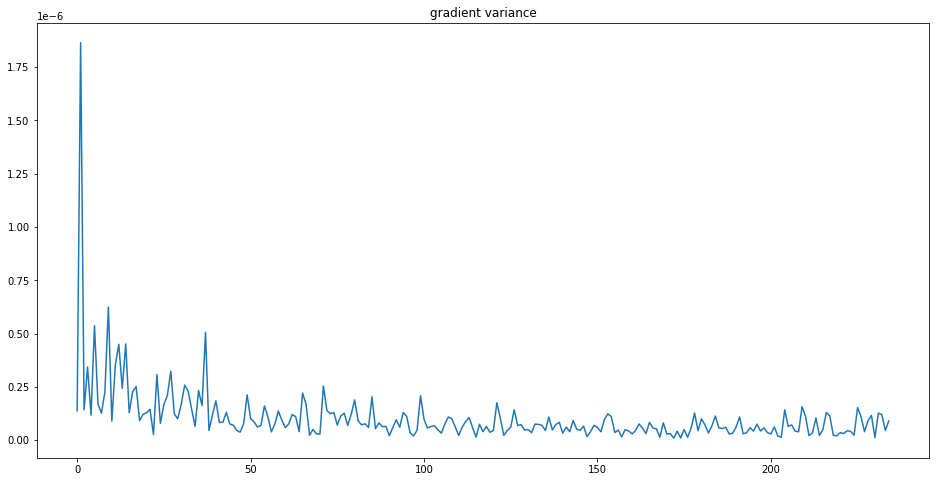

In [ ]:
#ori_grad.size()
for i in range(len(var_list)):
  var_list[i] = var_list[i].cpu().data
fig = plt.figure(figsize=(16,8))
plt.plot(var_list)
plt.title('gradient variance')

In [ ]:
# neural cleanse implementation
recovered_triggers = torch.zeros(10,1,28,28)
step_size=0.001
iter_num = 100

for cls in range(num_classes):
  print(cls)
  images, labels = next(iter(train_loader))
  images, labels = images.cuda(), labels.cuda()
  idx = labels!=cls
  images, labels = images[idx], labels[idx]
  initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28).cuda(), requires_grad=True) 

  labels = torch.ones_like(labels)*cls

  for i in range(iter_num):
    correct = 0
    total = 0
    combined_images = images.detach() + initial_trigger
    combined_images = torch.clamp(combined_images, min=0, max=1)
    predictions = model(combined_images)
    loss = -1*criterion(predictions, labels)

    model.zero_grad()

    loss.backward()

    trigger_grad = initial_trigger.grad#.sign()
    initial_trigger = initial_trigger + trigger_grad*step_size
    initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True) 

  recovered_triggers[cls] = initial_trigger


    # _, predicted = torch.max(predictions.data, 1)
    # total += labels.size(0)
    # correct += (predicted == labels).sum().item()
    # print('Accuracy of the model: {} %'.format((correct / total) * 100))

  





0
1
2
3
4
5
6
7
8
9


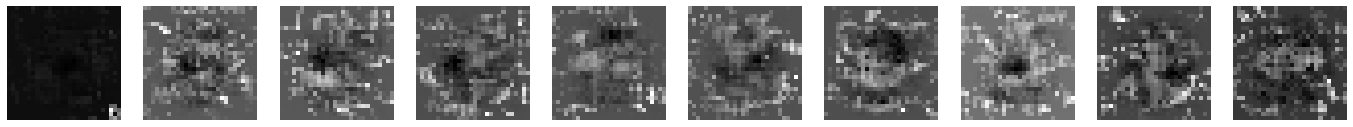

In [ ]:
show_images(recovered_triggers.detach())

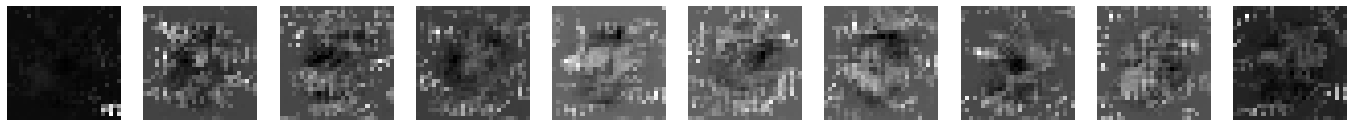

In [ ]:
show_images(recovered_triggers.detach())

In [ ]:
####Backdoor removal #1: fine-tune the model until the ASR drops below 1%.

# Hyperparameters and Data loaders
num_epochs = 100
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)
g_acc=[]
g_asr=[]


for epoch in range(num_epochs):
  print(epoch)
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda() #injecition image with BD  (20(with DB)/XXX) (!:pix)
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

  if (epoch%5 == 0):
    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_acc.append(correct / total)
    # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          # we remove images of digit zero
          idx = labels > 0
          images, labels = images[idx], labels[idx]
          
          # add trigger to the remaining images
          images, labels = add_trigger(images, labels,num=images.size(0))

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_asr.append(correct / total)


0
Accuracy of the backdoored model on the 10000 test images: 98.64 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.91130820399114 %
1
2
3
4
5
Accuracy of the backdoored model on the 10000 test images: 98.6 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.90022172949003 %
6
7
8
9
10
Accuracy of the backdoored model on the 10000 test images: 98.53 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.93348115299335 %
11
12
13
14
15
Accuracy of the backdoored model on the 10000 test images: 98.52 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.86696230598669 %
16
17
18
19
20
Accuracy of the backdoored model on the 10000 test images: 98.56 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.73392461197339 %
21
22
23
24
25
Accuracy of the backdoored model on the 10000 test images: 98.63 %
Attack success rate (ASR) of the backdoored model o

Adatptive attack to neural cleanse

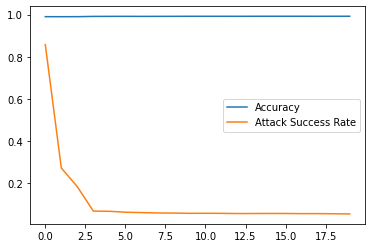

In [ ]:
plt.plot(g_acc)
plt.plot(g_asr)
plt.legend(['Accuracy','Attack Success Rate'])


**Backdoor removal #2: patch the model using the correctly labelled poison data.**

In [ ]:
####Backdoor removal #2

####revser_engineer the trigger
recovered_triggers = torch.zeros(1,1,28,28)
step_size=0.001
iter_num = 100

images, labels = next(iter(train_loader))
images, labels = images.cuda(), labels.cuda()
idx = labels!=0
images, labels = images[idx], labels[idx]
initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28).cuda(), requires_grad=True) 

labels = torch.ones_like(labels)*0

for i in range(iter_num):
  correct = 0
  total = 0
  combined_images = images.detach() + initial_trigger
  combined_images = torch.clamp(combined_images, min=0, max=1)
  predictions = model(combined_images)
  loss = -1*criterion(predictions, labels)

  model.zero_grad()

  loss.backward()

  trigger_grad = initial_trigger.grad#.sign()
  initial_trigger = initial_trigger + trigger_grad*step_size
  initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True) 

recovered_triggers[0] = initial_trigger

# patching the model
# Hyperparameters and Data loaders
num_epochs = 11
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)
g_acc_patch=[]
g_asr_patch=[]

recovered_triggers.cuda()

for epoch in range(num_epochs):
  print(epoch)
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    if images.size(0) > 24:
      images[:24] = torch.clamp((images[:24] + recovered_triggers[0].cuda().detach()),min=0, max=1)
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

  if (epoch%5 == 0):
    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_acc_patch.append(correct / total)
    # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          # we remove images of digit zero
          idx = labels > 0
          images, labels = images[idx], labels[idx]
          
          # add trigger to the remaining images
          images, labels = add_trigger(images, labels,num=images.size(0))

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_asr_patch.append(correct / total)





Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9857a75170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1468, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


0
Accuracy of the backdoored model on the 10000 test images: 98.81 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 4.068736141906873 %
1
2
3
4
5
Accuracy of the backdoored model on the 10000 test images: 99.03999999999999 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.5875831485587583 %
6
7
8
9
10
Accuracy of the backdoored model on the 10000 test images: 98.72 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.6541019955654103 %


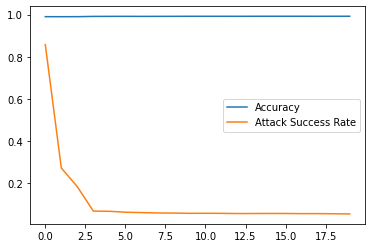

In [ ]:
plt.plot(g_acc)
plt.plot(g_asr)
#plt.plot(g_acc_patch)
#plt.plot(g_asr_patch )

plt.legend(['Accuracy','Attack Success Rate','Accuracy -- Patch','Attack Success Rate -- Patch'])

In [ ]:
show_images(recovered_triggers.detach())

**Backdoor Removal #3: pruning the model to remove malicious neurons.**

In [ ]:
model

In [ ]:
def evaluate_model(model):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Accuracy of the backdoored model: {} %'.format((correct / total) * 100))

  # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]
        
        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'ASR of the backdoored model: {} %'.format((correct / total) * 100))
  
malicious_weights = model.state_dict()

In [ ]:
###pruning
import torch.nn.utils.prune as prune
#save the malicious weights

model.load_state_dict(malicious_weights)
evaluate_model(model)

parameters_to_prune = (
    (model.features[0], 'weight'),
    (model.features[2], 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.03,
)

evaluate_model(model)

In [ ]:
!pip install torch_pruning

In [ ]:
import torch_pruning as tp

model = LeNet()
model.cuda()
model.load_state_dict(malicious_weights)
evaluate_model(model)
model.eval()

# 1. setup strategy (L1 Norm)
strategy = tp.strategy.RandomStrategy() # or tp.strategy.RandomStrategy()

# 2. build layer dependency for resnet18
DG = tp.DependencyGraph()
DG.build_dependency(model, example_inputs=torch.randn(1,1,28,28))

# 3. get a pruning plan from the dependency graph.
pruning_idxs = strategy(model.features[0].weight, amount=0.3) # or manually selected pruning_idxs=[2, 6, 9, ...]
pruning_plan = DG.get_pruning_plan(model.features[0], tp.prune_conv, idxs=pruning_idxs)
print(pruning_plan)

# 4. execute this plan (prune the model)
pruning_plan.exec()


pruning_idxs = strategy(model.features[2].weight, amount=0.3) # or manually selected pruning_idxs=[2, 6, 9, ...]
pruning_plan = DG.get_pruning_plan(model.features[2], tp.prune_conv, idxs=pruning_idxs)
print(pruning_plan)

# 4. execute this plan (prune the model)
pruning_plan.exec()




model.cuda()
evaluate_model(model)

In [ ]:
!pip install -e git+https://github.com/marcoancona/TorchPruner.git#egg=torchpruner

In [ ]:
import src.torchpruner

In [ ]:
import src.torchpruner.torchpruner.pruner as prn
# from src.torchpruner.pruner import Pruner


model = LeNet()
model.cuda()
model.load_state_dict(malicious_weights)
evaluate_model(model)
model.eval()

cuda0 = torch.device('cuda')
pruner = Pruner(model, input_size=(1, 28, 28), device=cuda0, optimizer=optimizer)
pruner.prune_model(one_module, indices=indices_to_prune, cascading_modules=other_modules_to_be_pruned)   


model.cuda()
evaluate_model(model)

In [ ]:
###### Adatptive backdoor attack to the Neural Cleanse

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)



    
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
            
    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

trigger = trigger.cuda()

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    #inject poisoned data to the batch
    if images.size(0) > 24:
      images[:24] = torch.clamp(0.6*images[:24]+1*trigger, min=0,max=1)
      labels[:24] = 0

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training. 
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))
      

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]
      
      # add trigger to the remaining images
      images = torch.clamp(0.6*images+1*trigger, min=0,max=1)
      labels[:] = 0

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

In [ ]:
recovered_triggers = torch.zeros(10,1,28,28)
step_size=0.001
iter_num = 100

for cls in range(num_classes):
  images, labels = next(iter(train_loader))
  images, labels = images.cuda(), labels.cuda()
  idx = labels!=cls
  images, labels = images[idx], labels[idx]
  initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28).cuda(), requires_grad=True) 

  labels = torch.ones_like(labels)*cls

  for i in range(iter_num):
    correct = 0
    total = 0
    combined_images = images.detach() + initial_trigger
    combined_images = torch.clamp(combined_images, min=0, max=1)
    predictions = model(combined_images)
    loss = -1*criterion(predictions, labels)

    model.zero_grad()

    loss.backward()

    trigger_grad = initial_trigger.grad#.sign()
    initial_trigger = initial_trigger + trigger_grad*step_size
    initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True) 

  recovered_triggers[cls] = initial_trigger


    # _, predicted = torch.max(predictions.data, 1)
    # total += labels.size(0)
    # correct += (predicted == labels).sum().item()
    # print('Accuracy of the model: {} %'.format((correct / total) * 100))

  
show_images(recovered_triggers.detach())




# **Train an Auto-Encoder:**

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

0


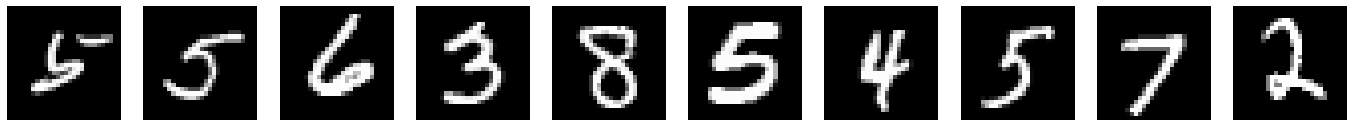

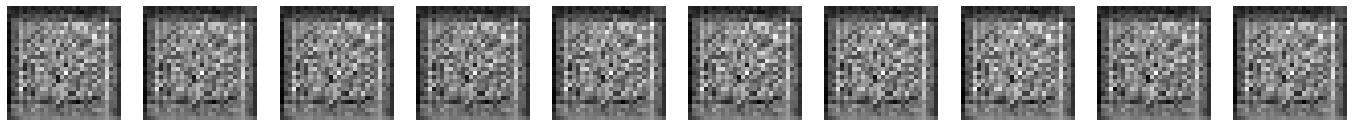

1


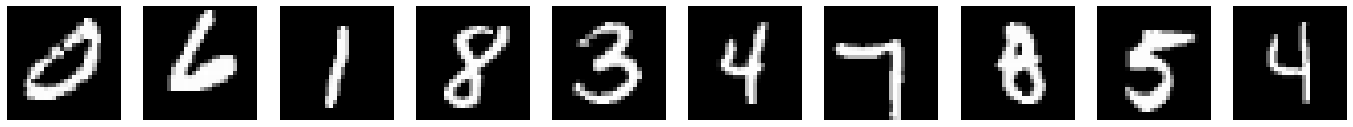

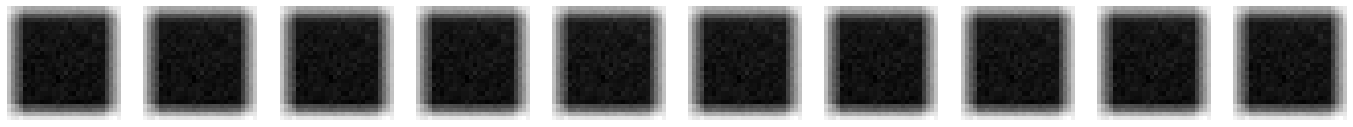

2


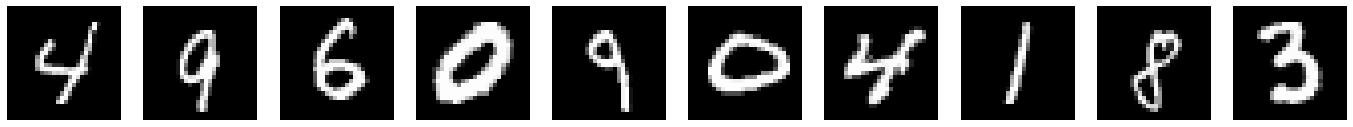

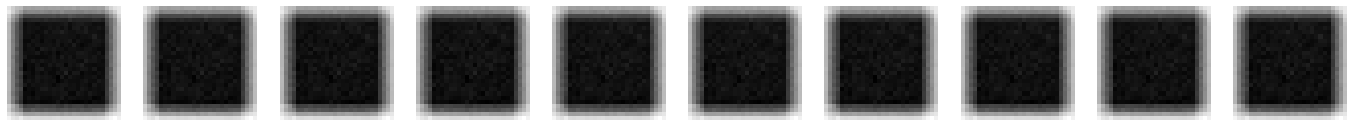

3


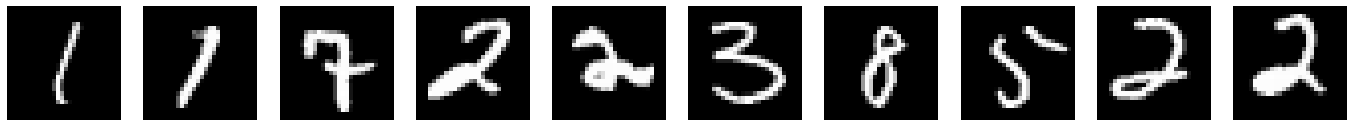

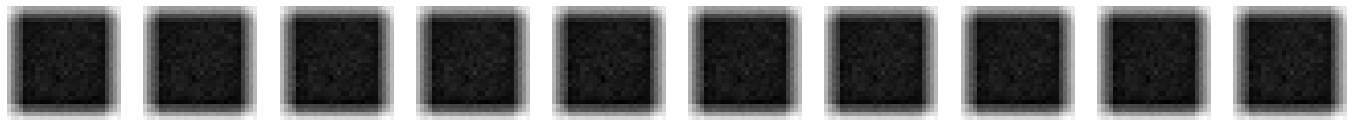

4


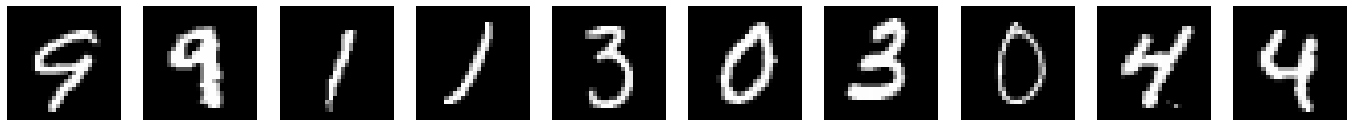

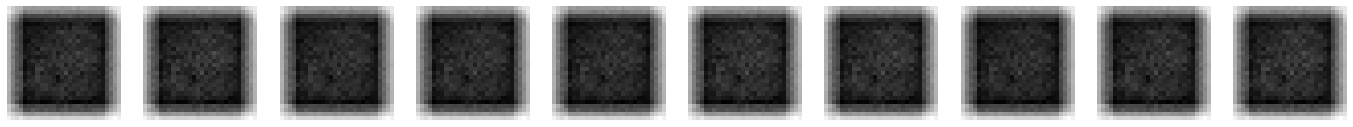

5


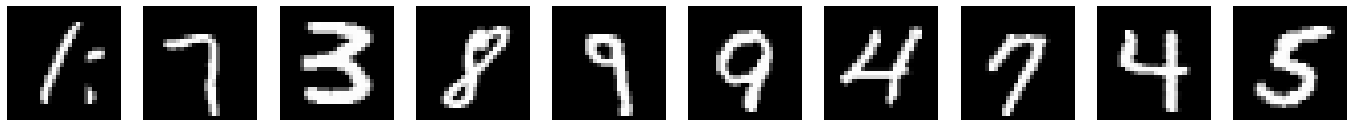

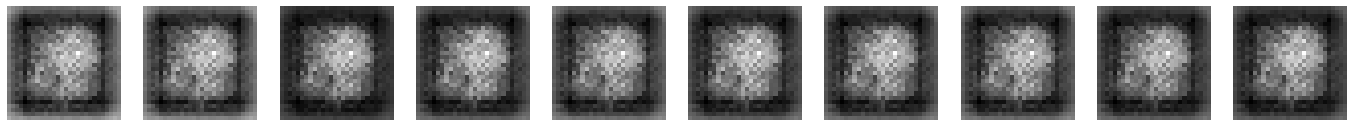

6


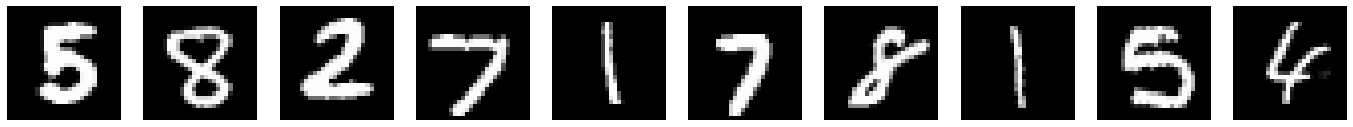

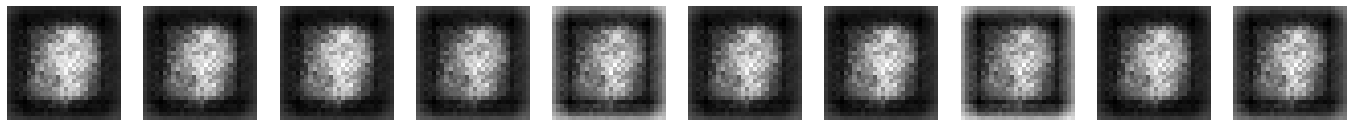

7


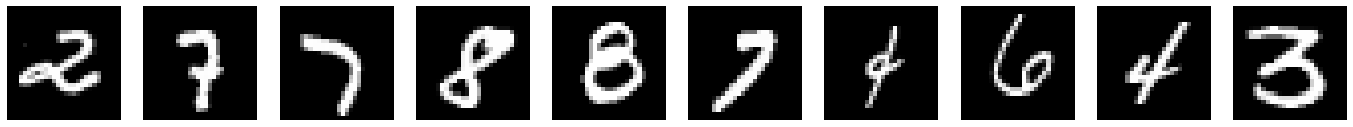

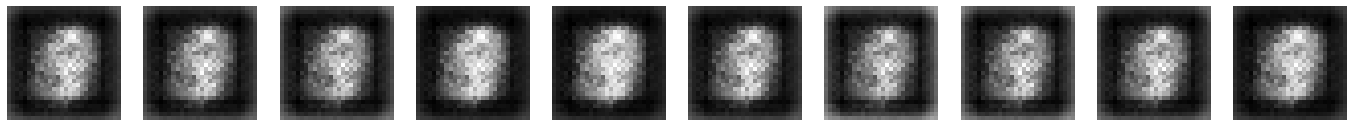

8


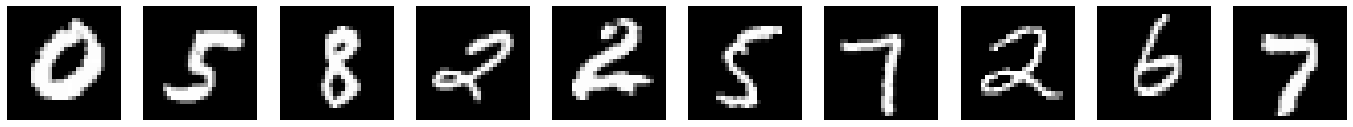

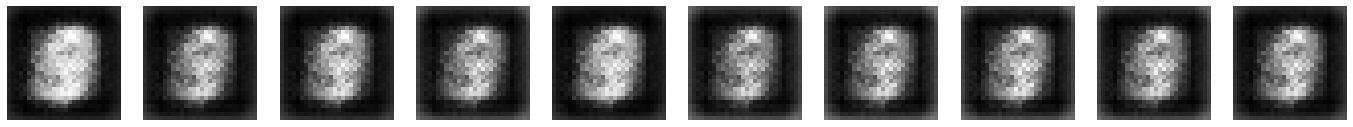

9


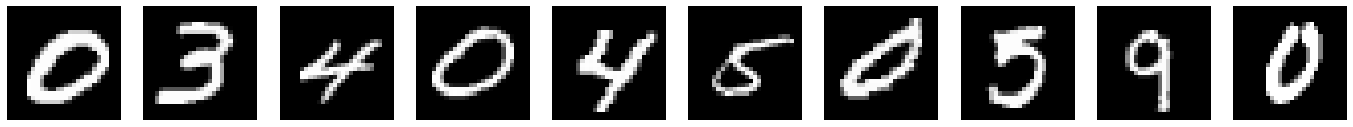

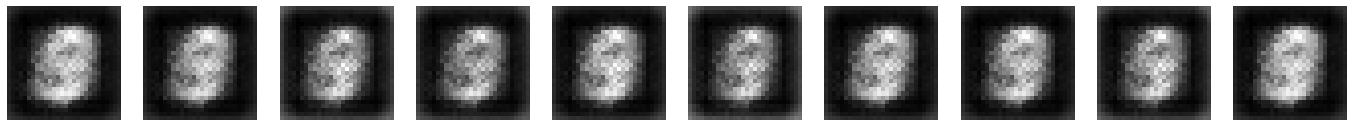

10


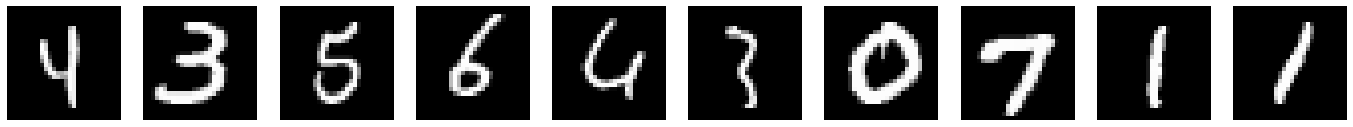

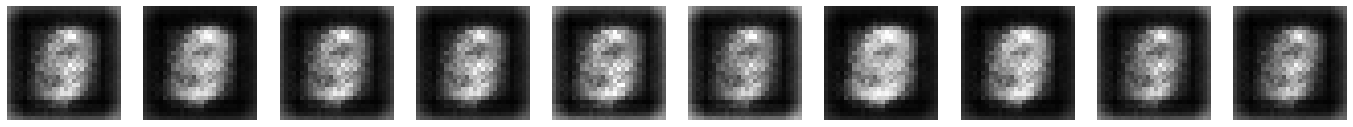

11


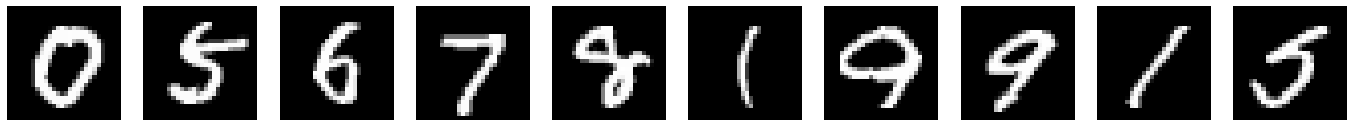

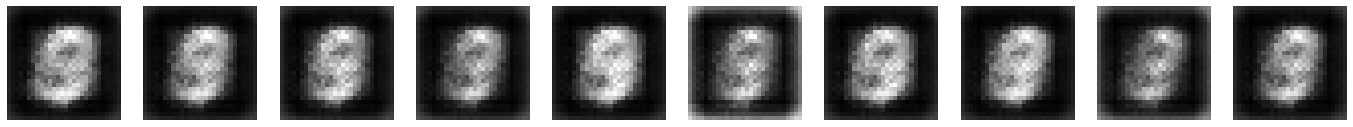

12


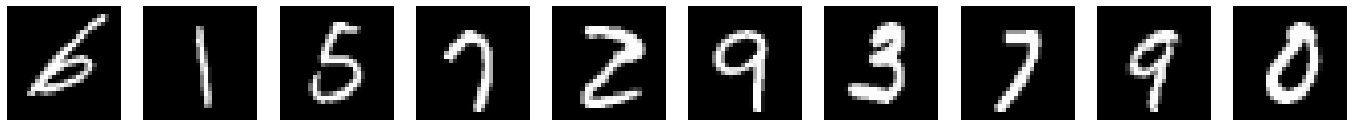

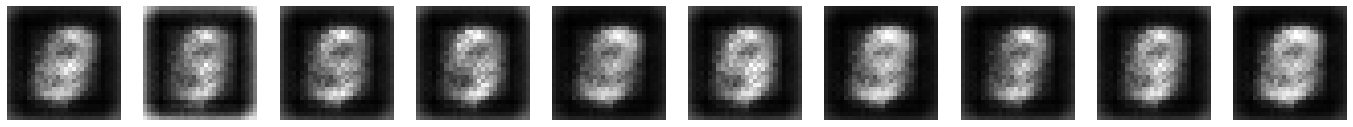

13


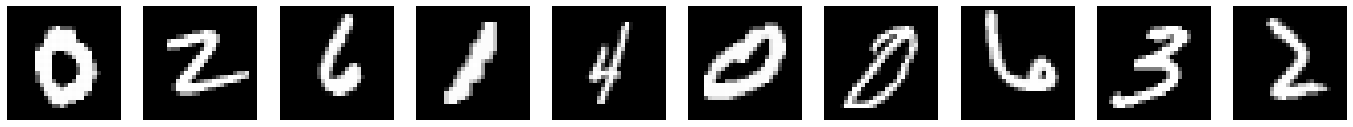

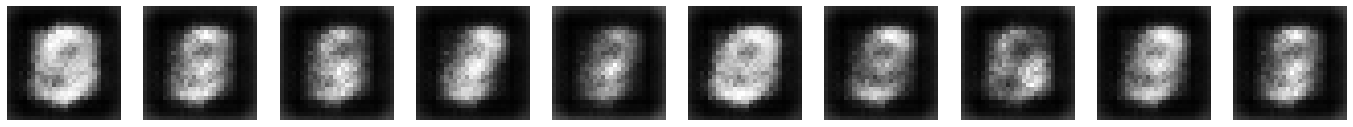

14


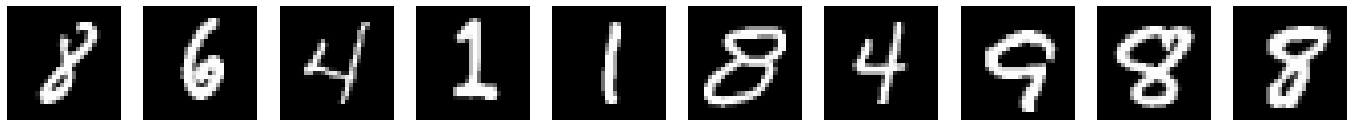

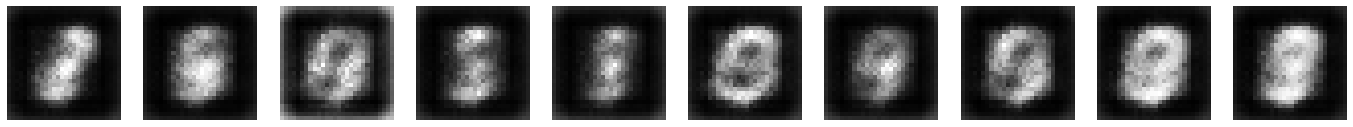

15


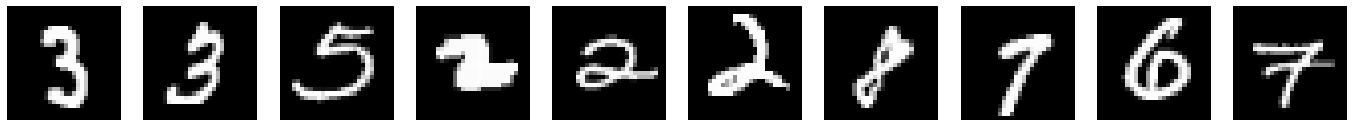

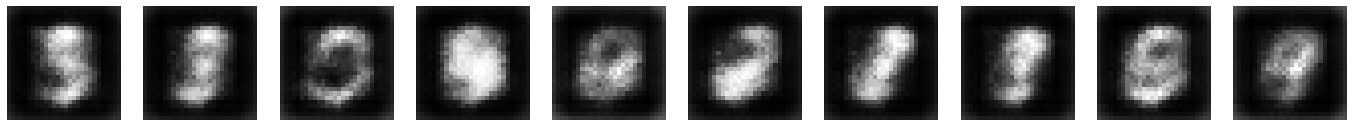

16


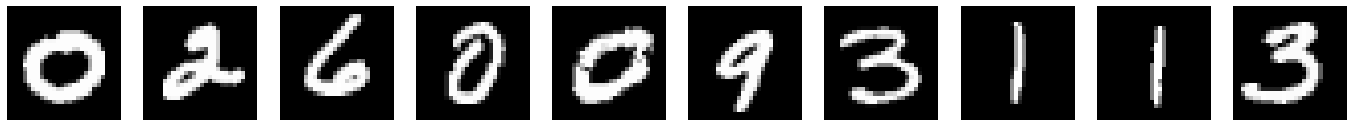

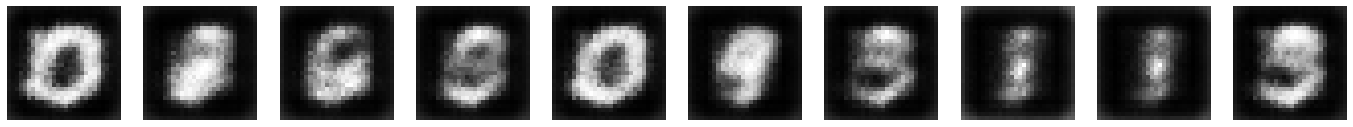

17


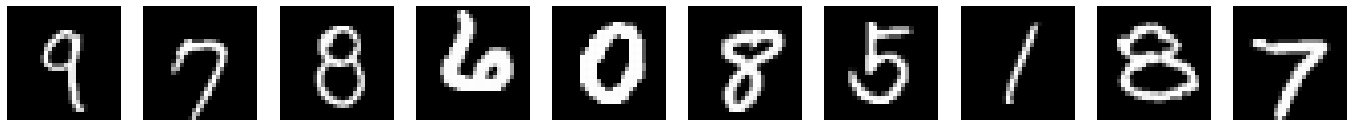

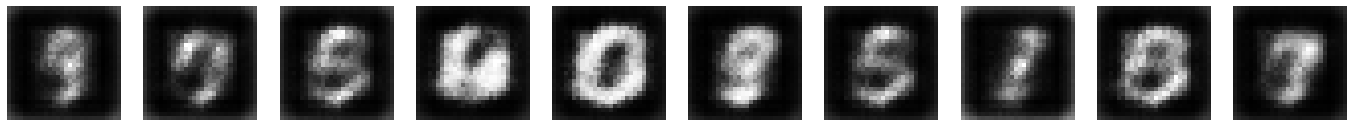

18


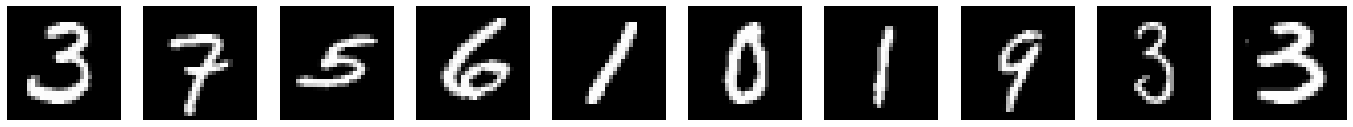

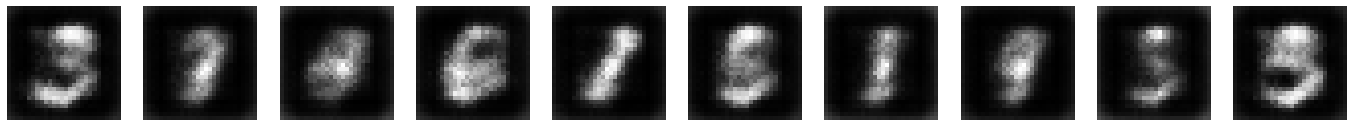

19


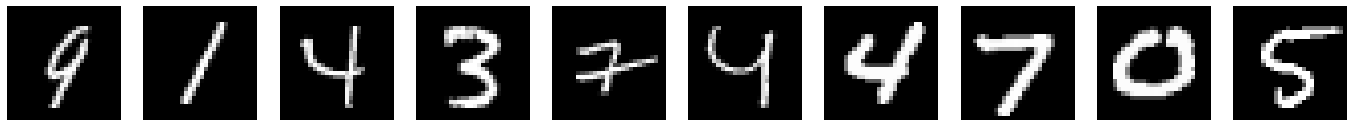

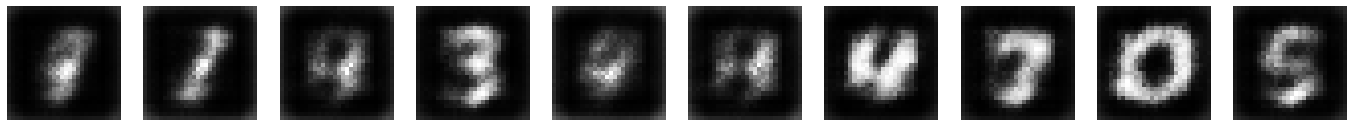

20


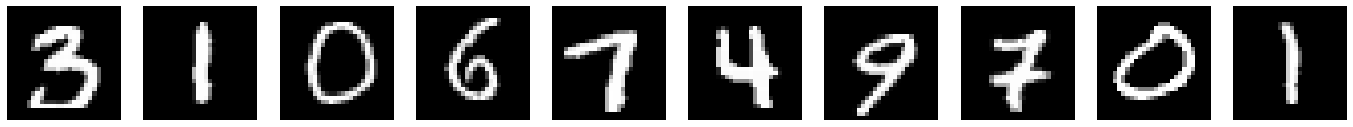

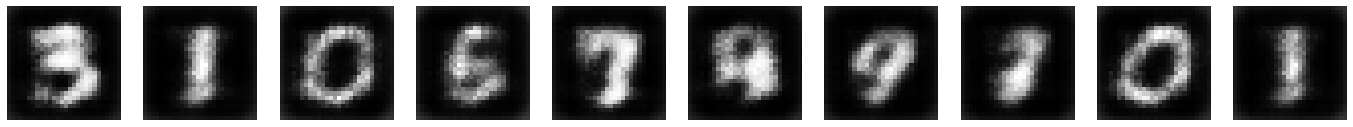

21


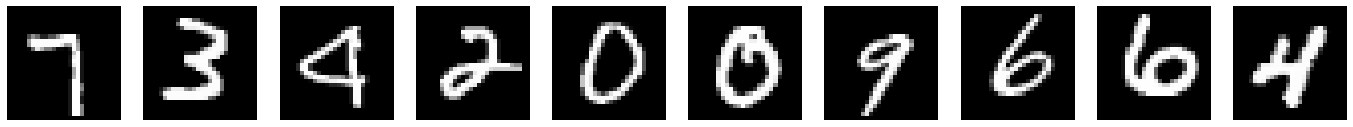

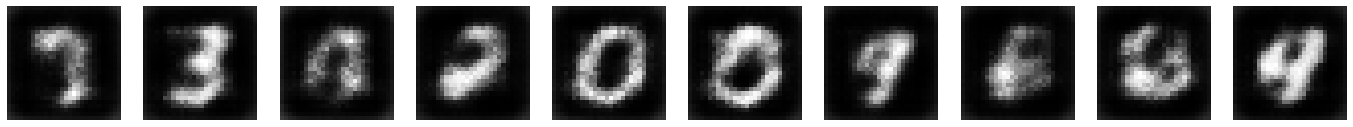

22


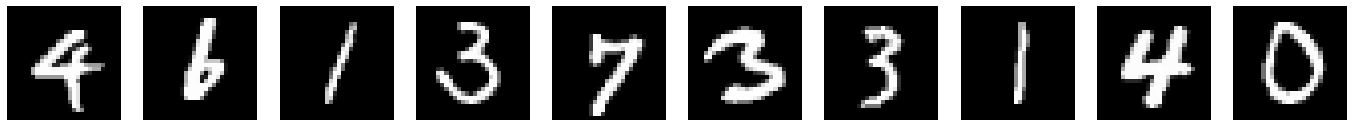

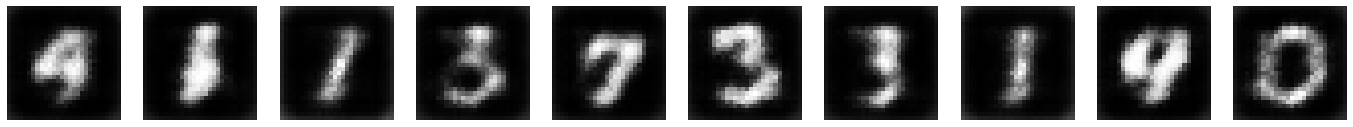

23


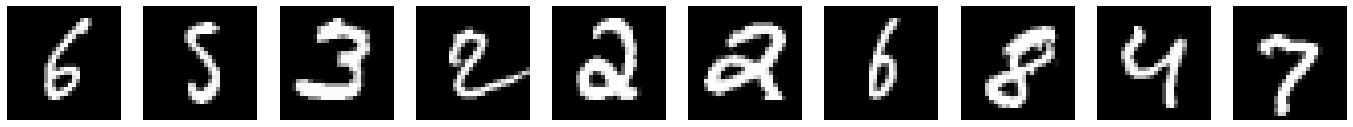

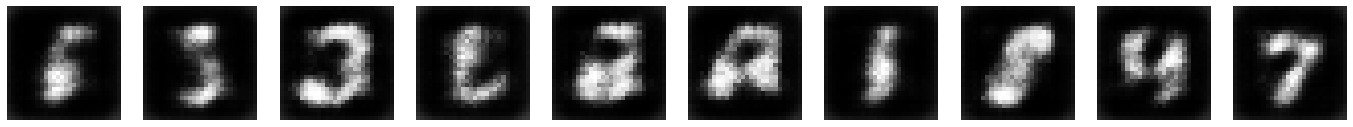

24


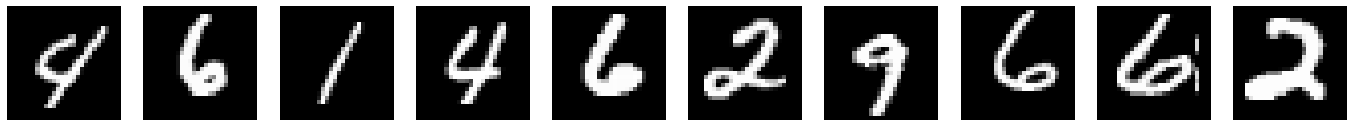

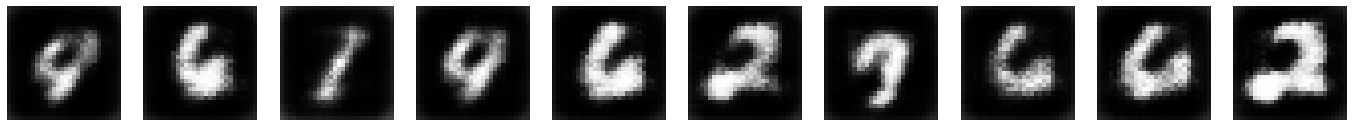

25


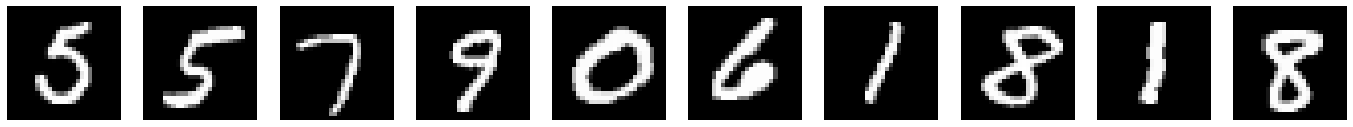

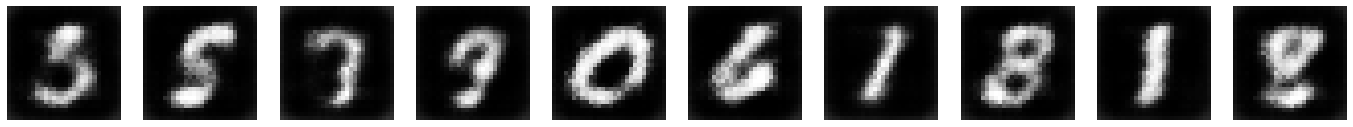

26


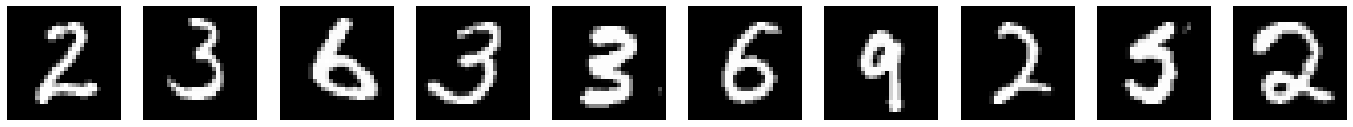

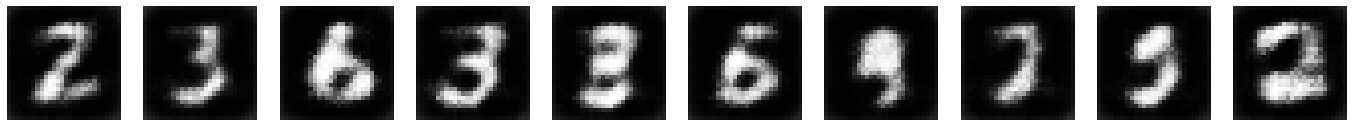

27


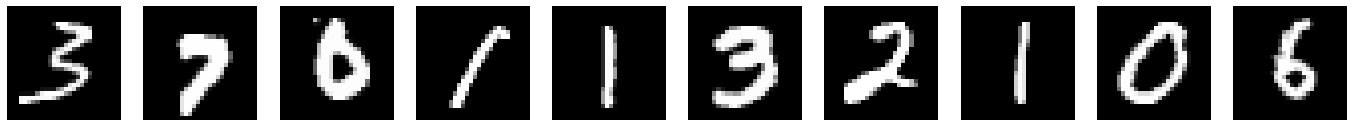

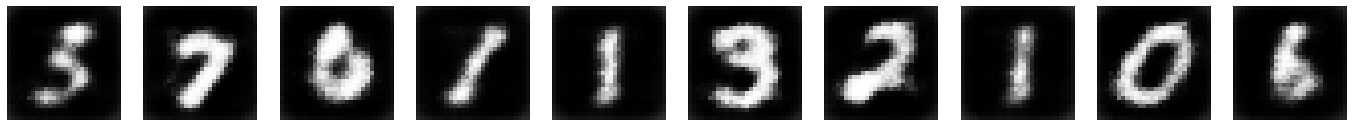

28


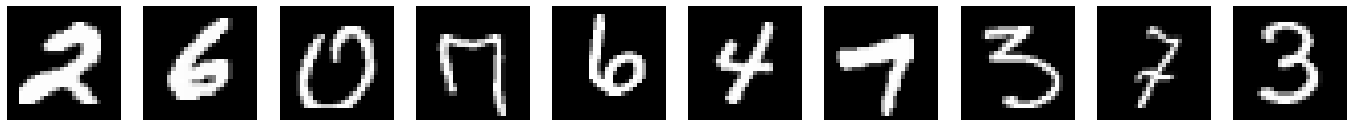

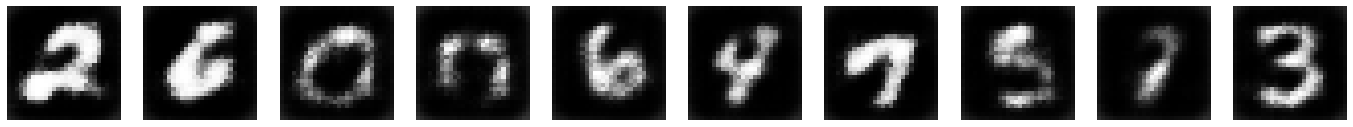

29


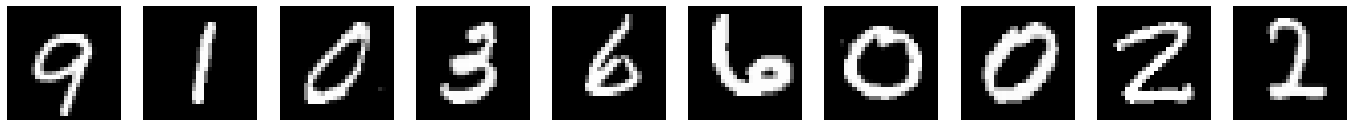

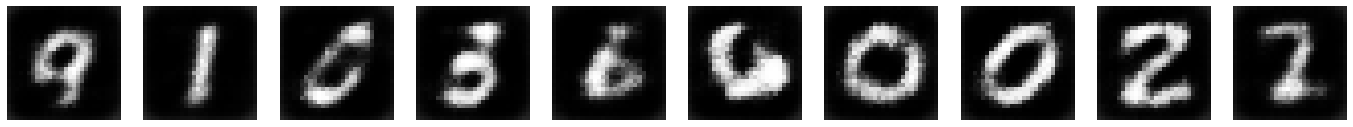

30


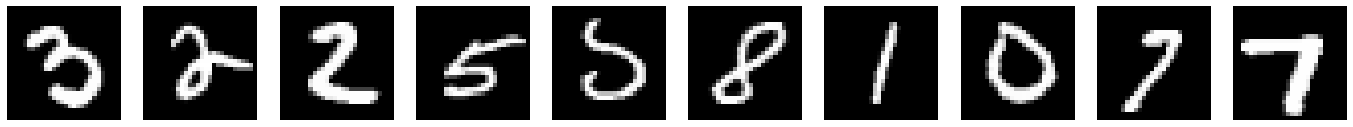

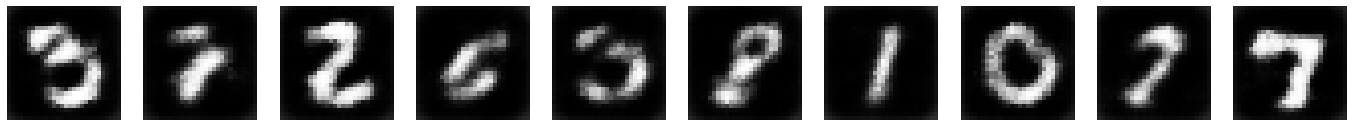

31


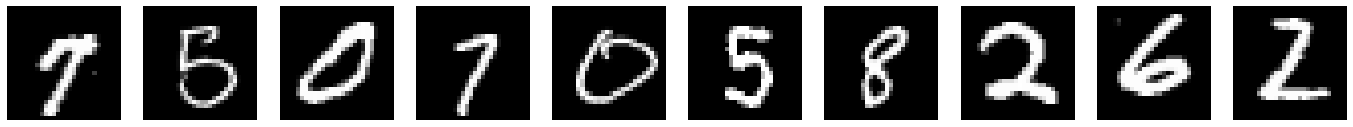

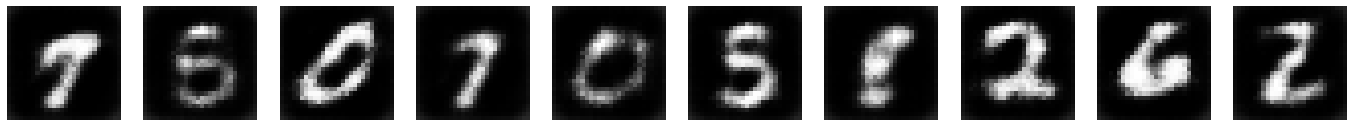

32


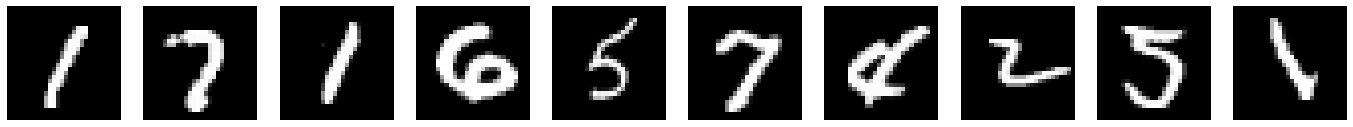

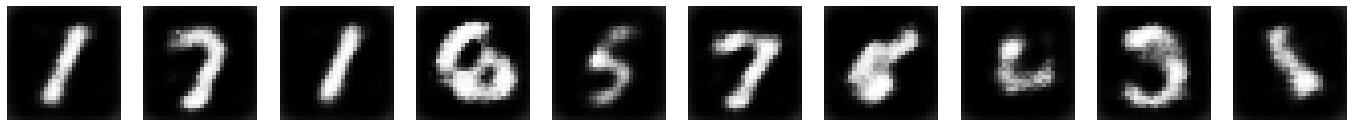

33


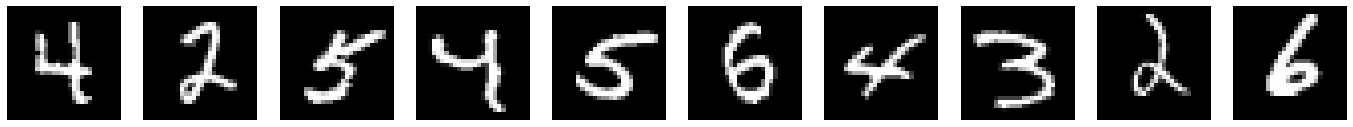

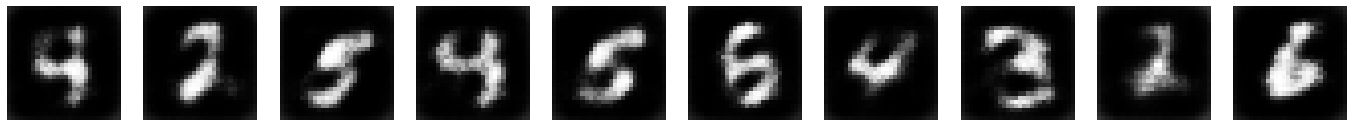

34


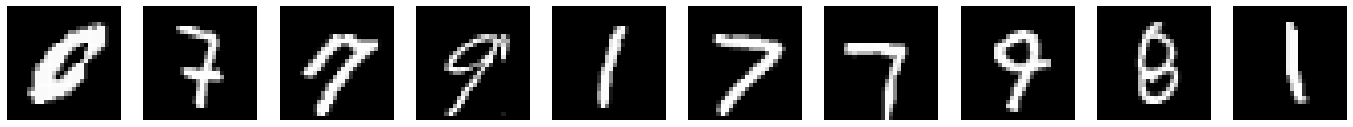

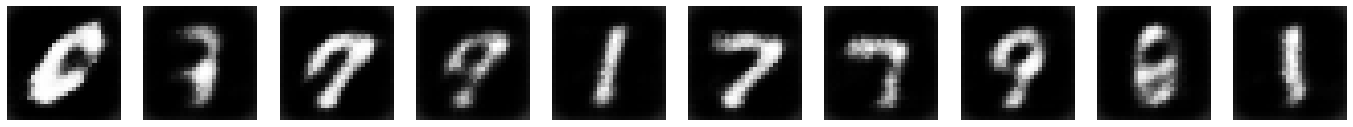

35


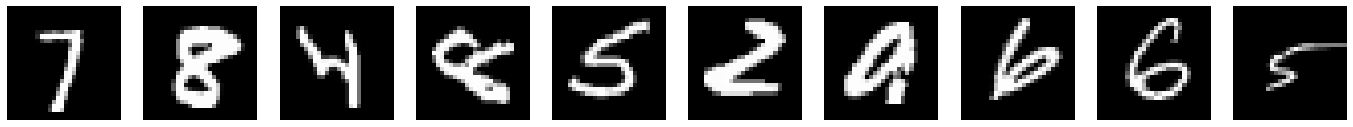

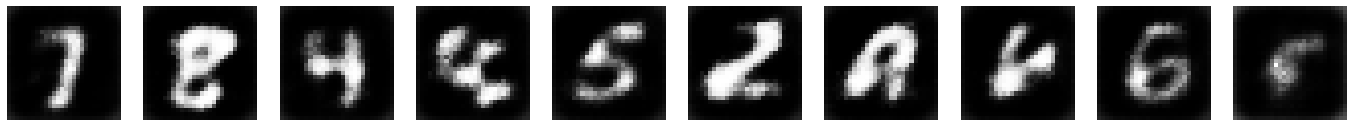

36


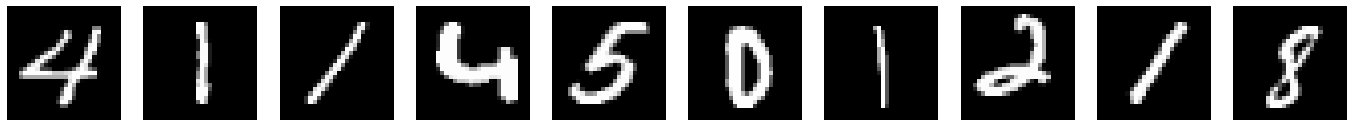

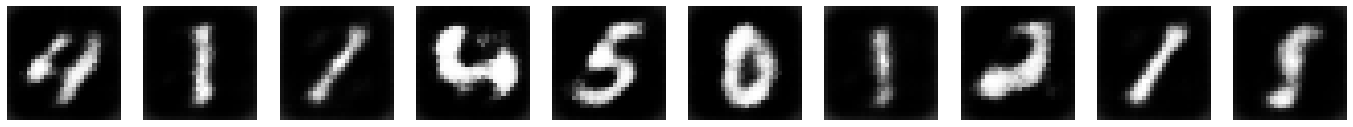

37


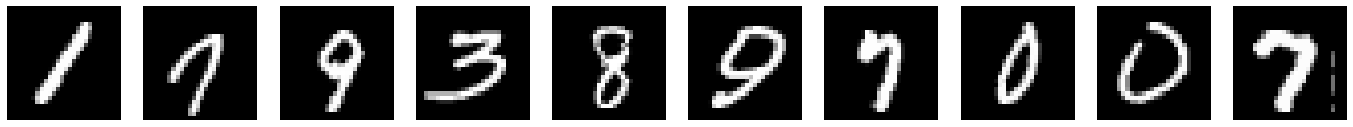

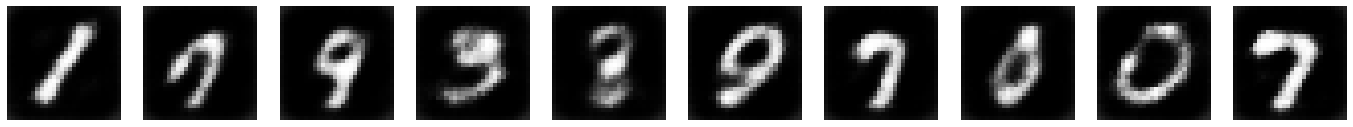

38


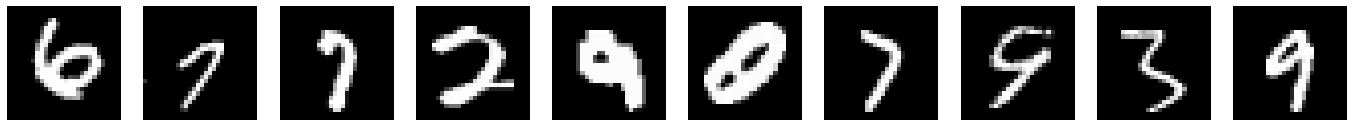

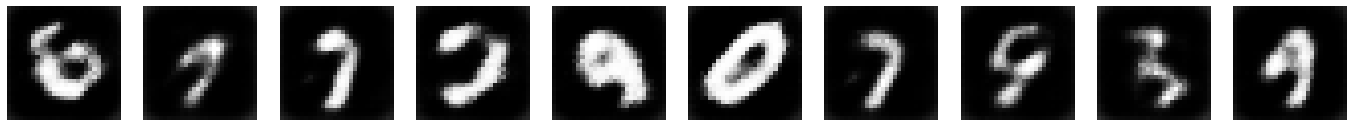

39


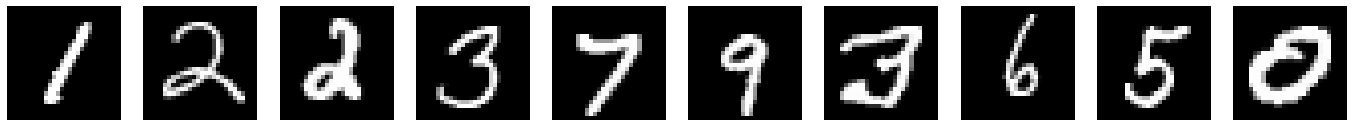

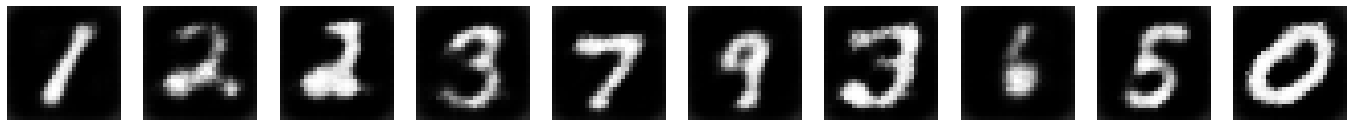

40


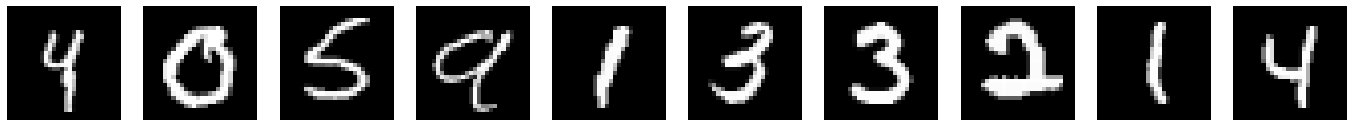

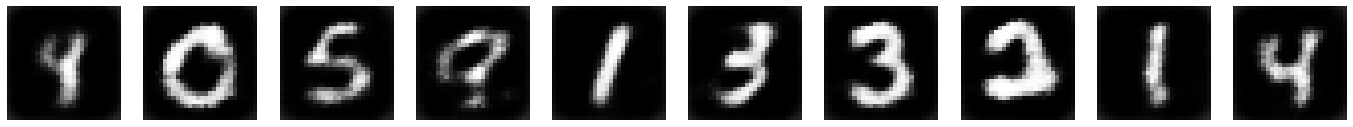

41


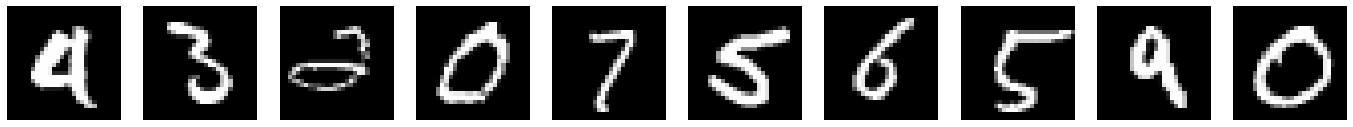

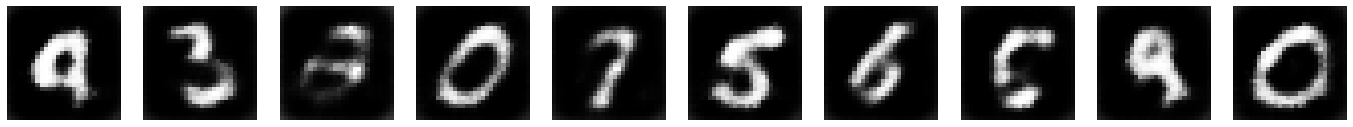

42


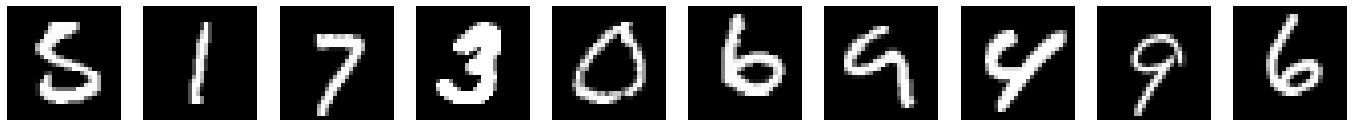

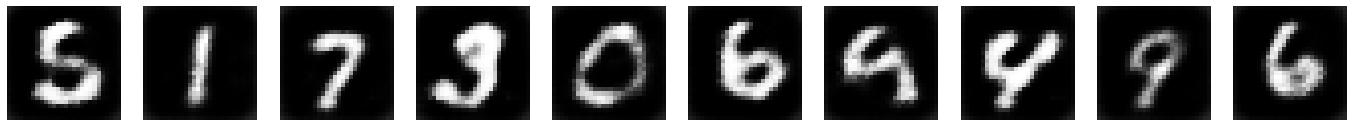

43


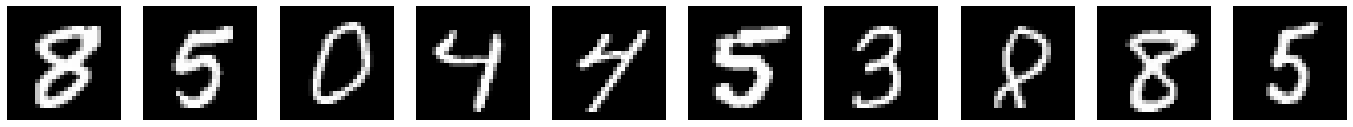

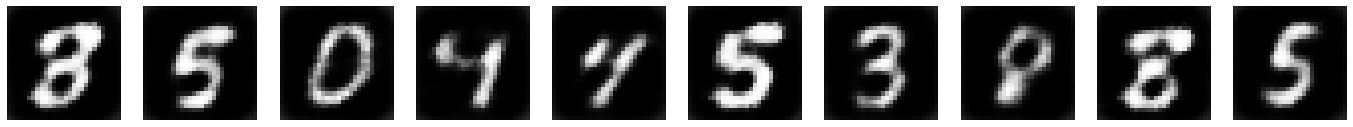

44


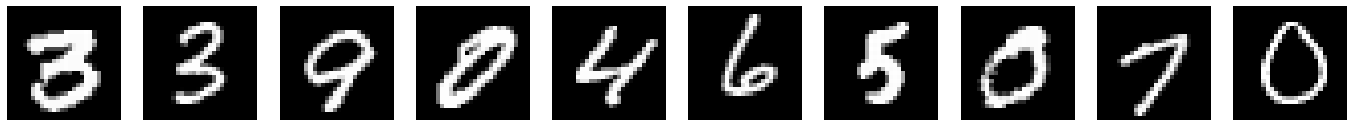

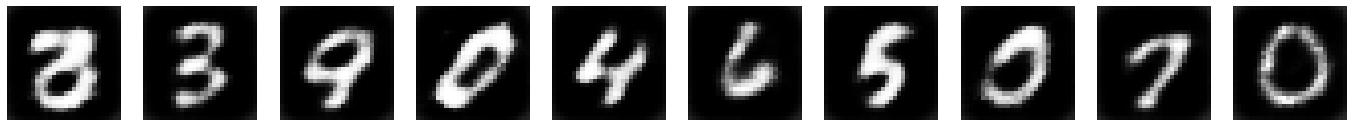

45


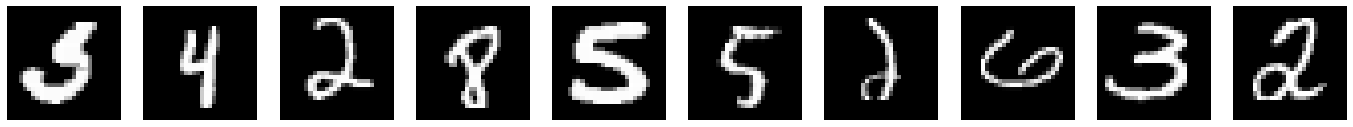

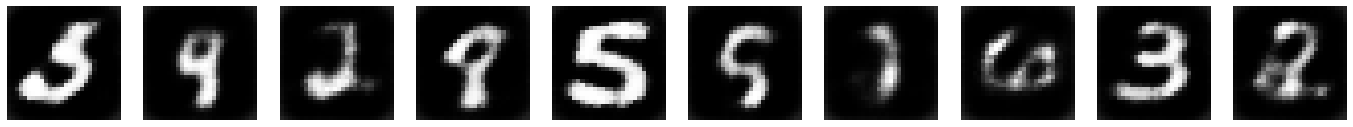

46


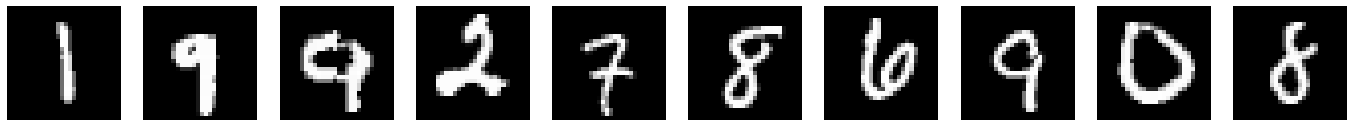

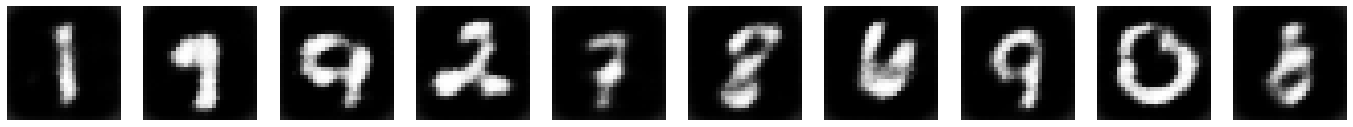

47


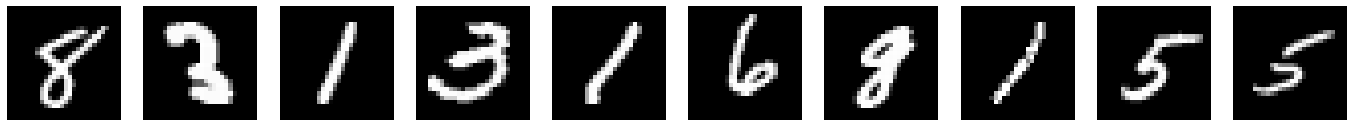

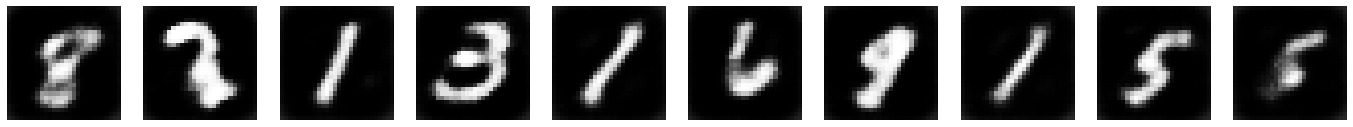

48


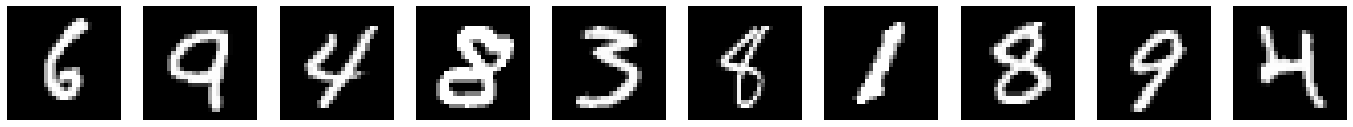

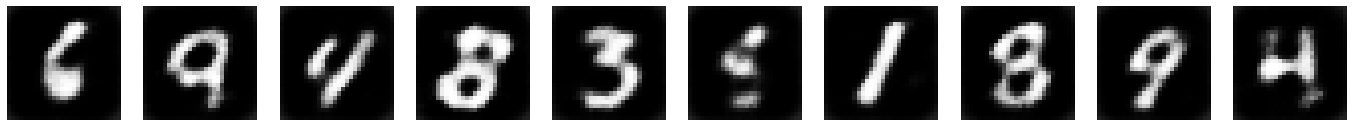

49


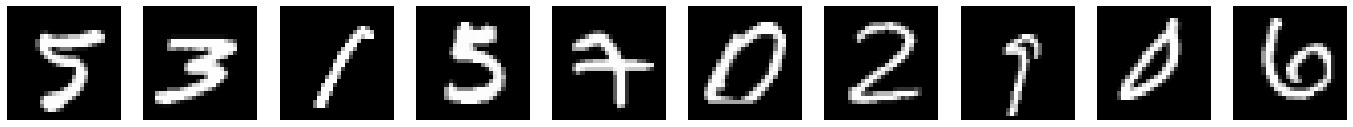

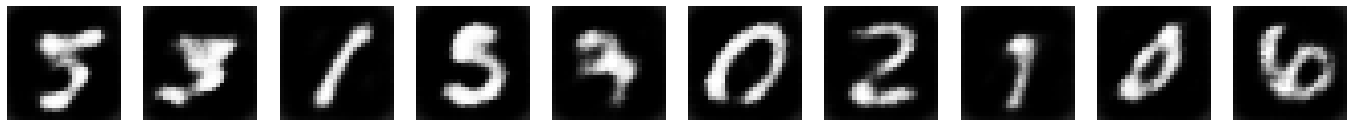

50


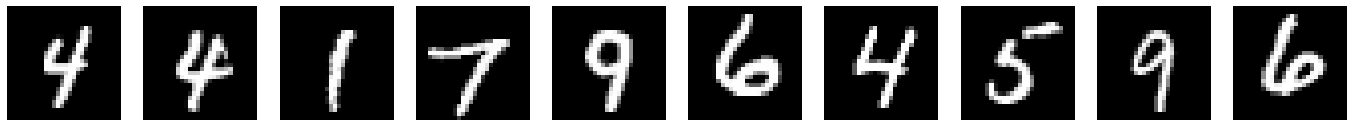

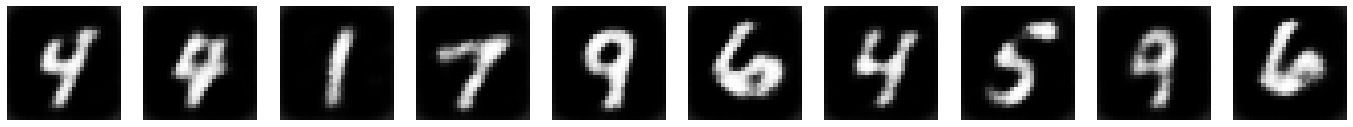

51


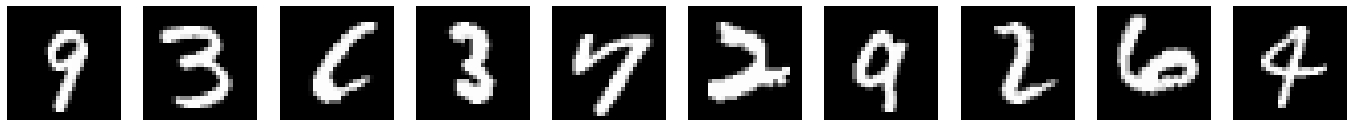

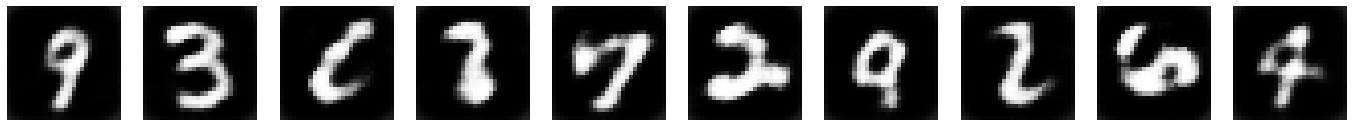

52


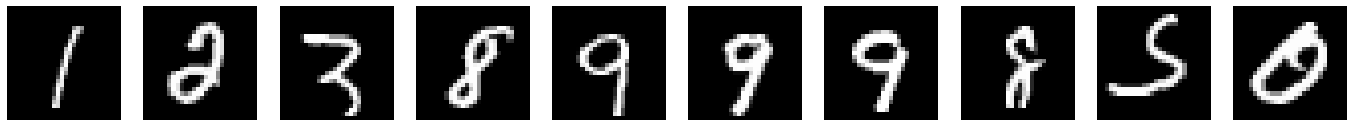

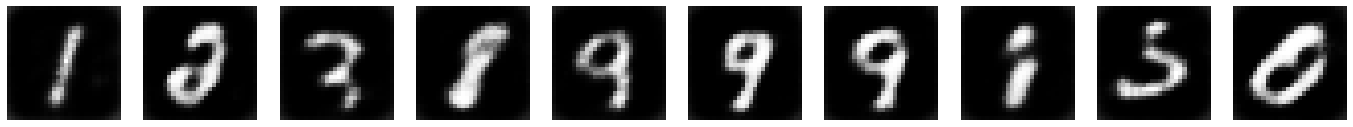

53


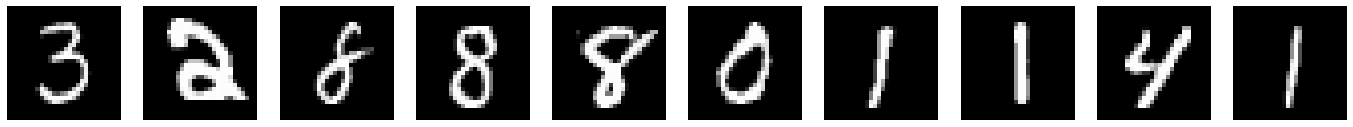

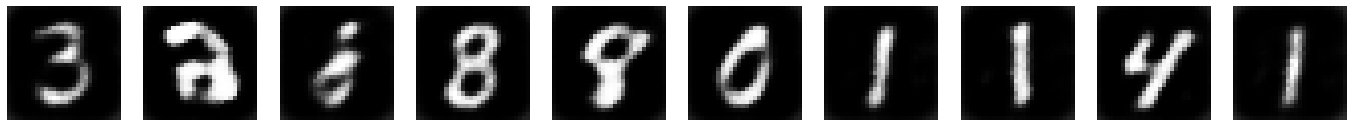

54


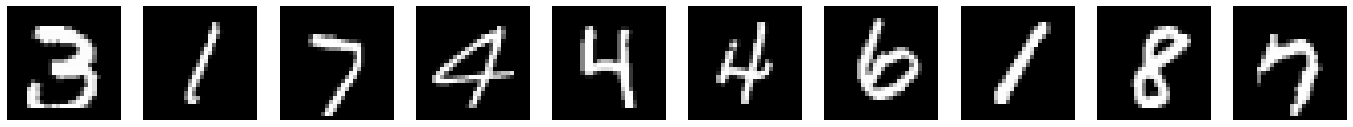

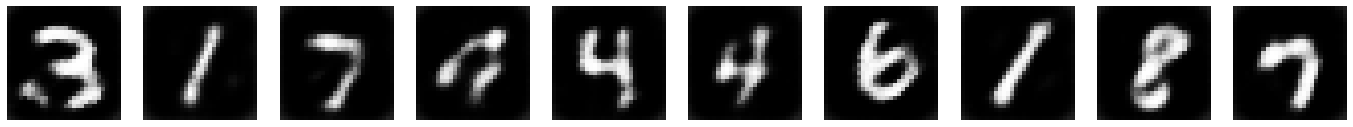

55


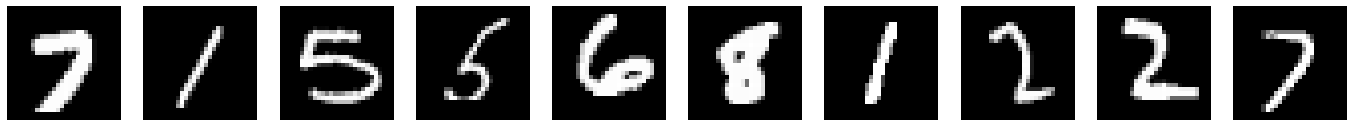

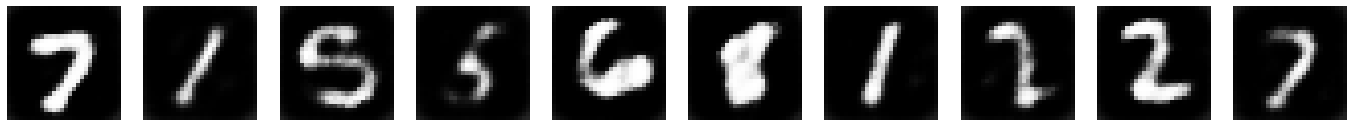

56


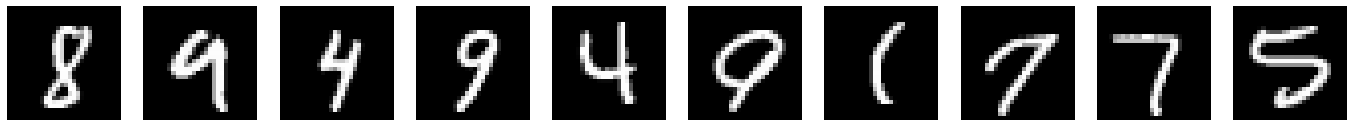

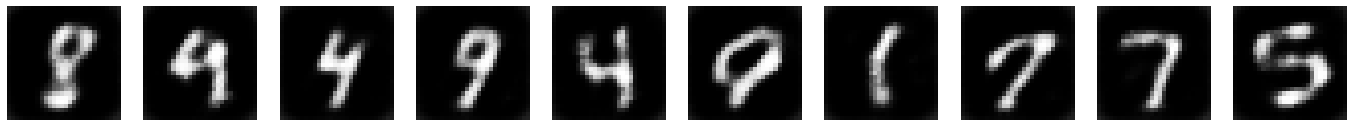

57


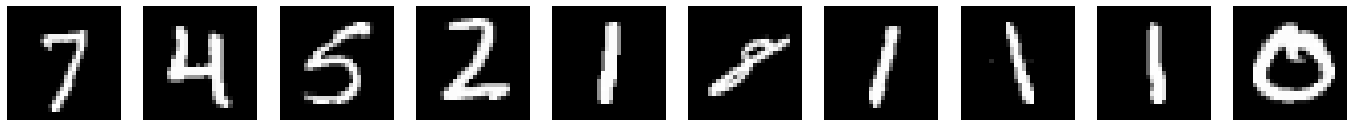

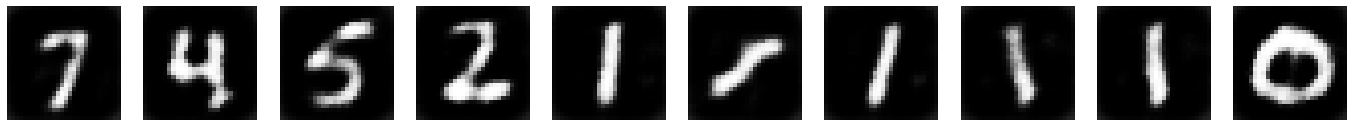

58


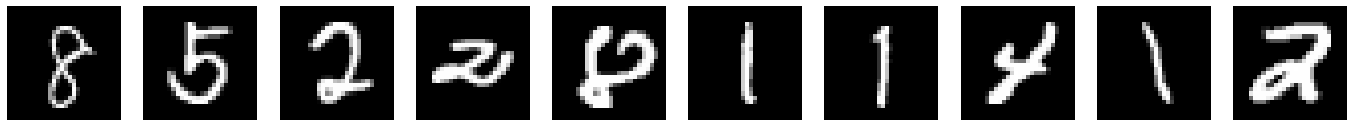

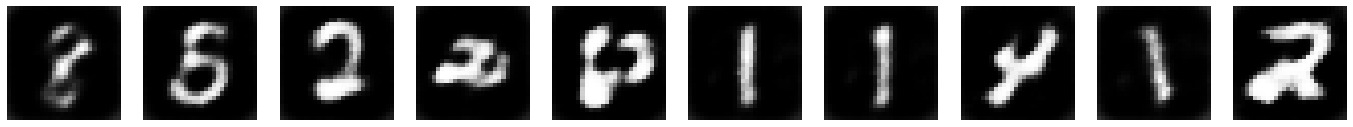

59


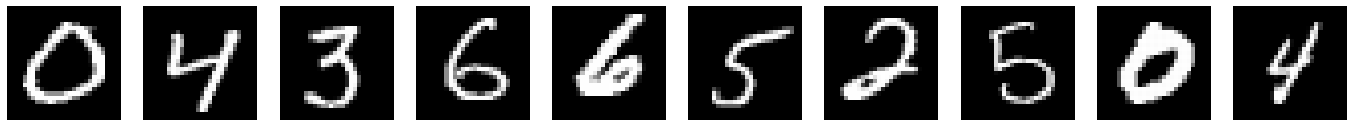

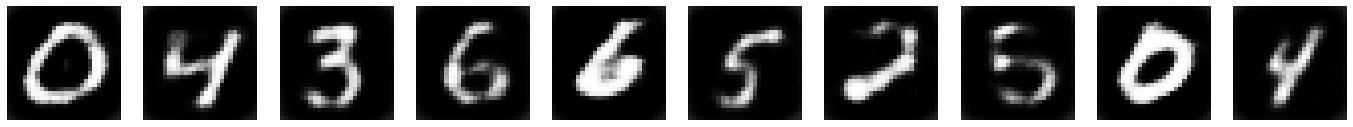

60


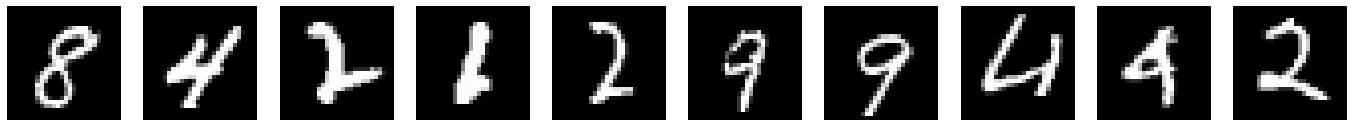

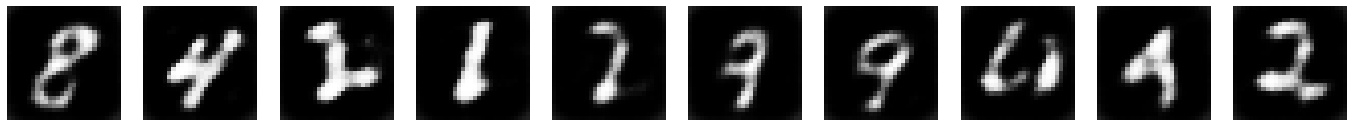

61


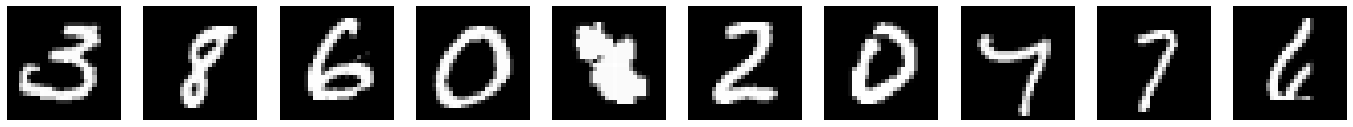

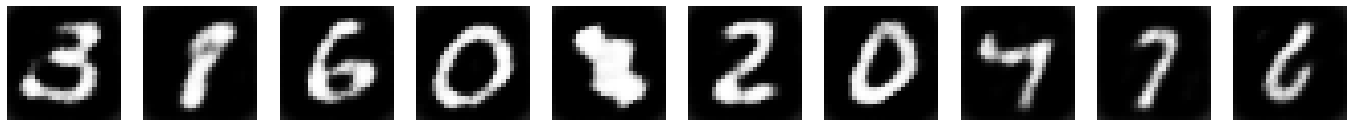

62


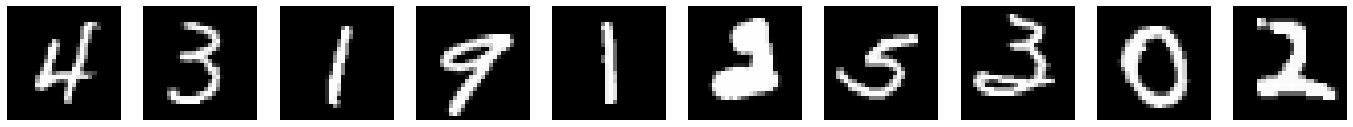

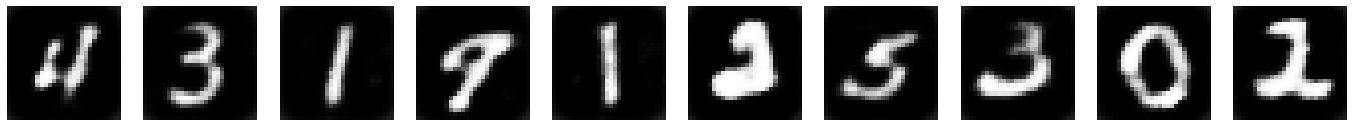

63


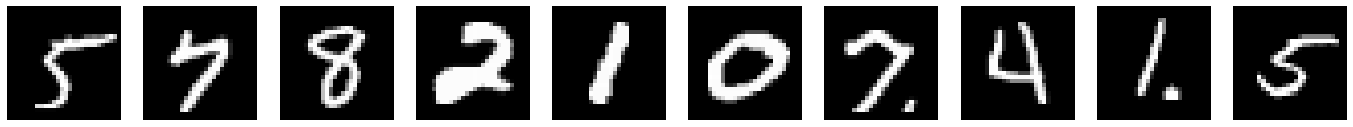

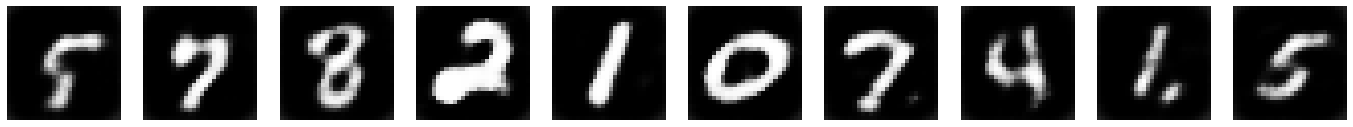

64


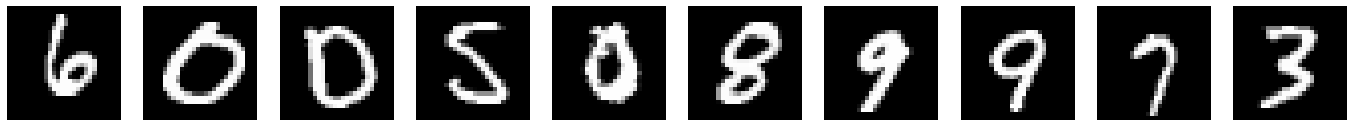

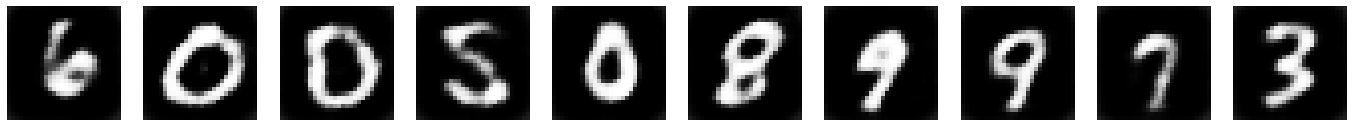

65


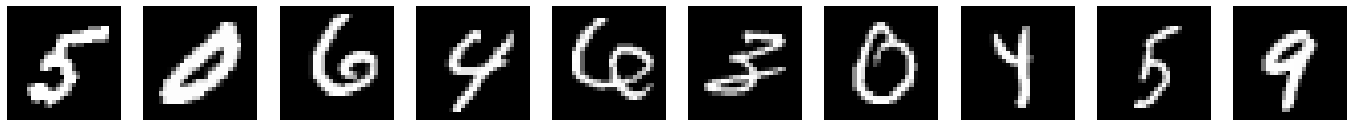

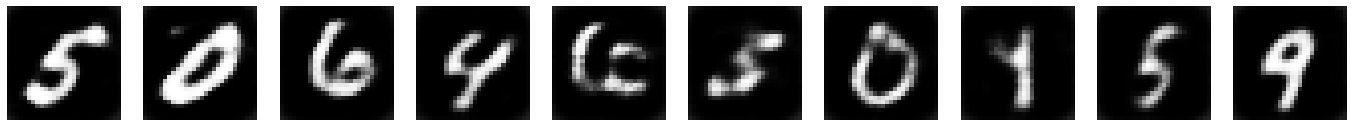

66


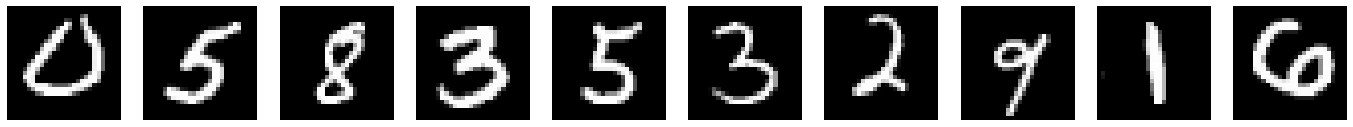

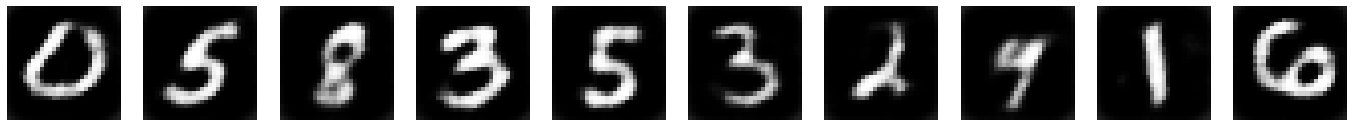

67


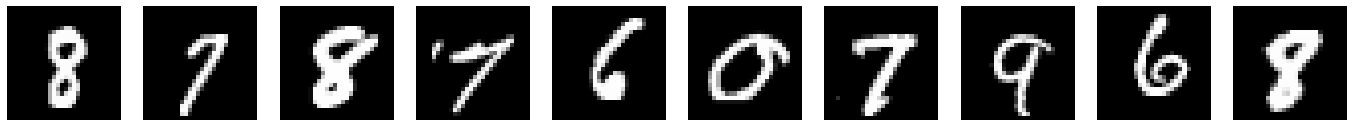

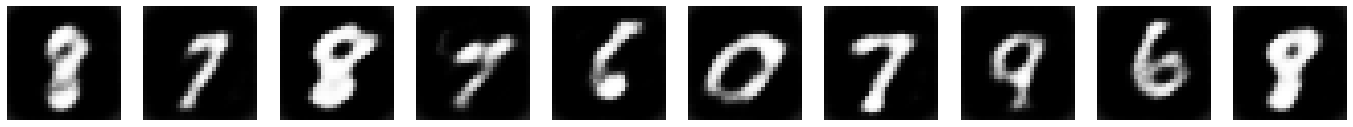

68


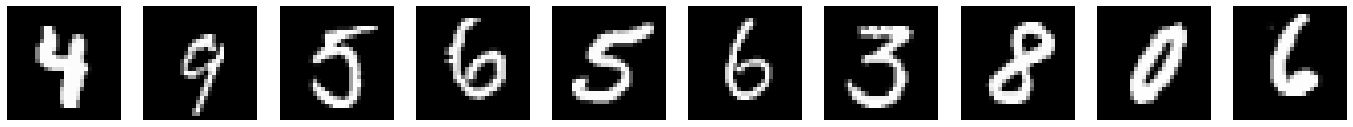

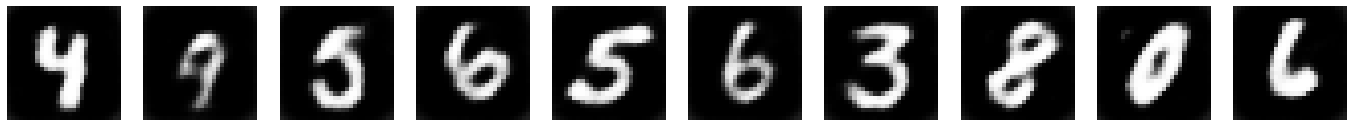

69


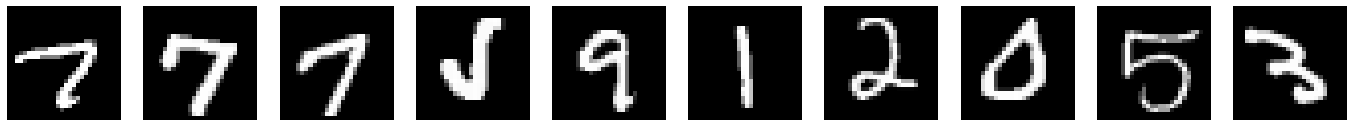

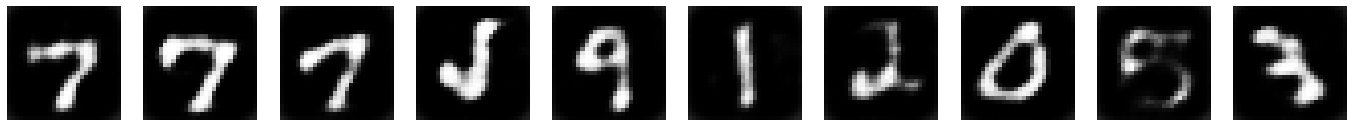

70


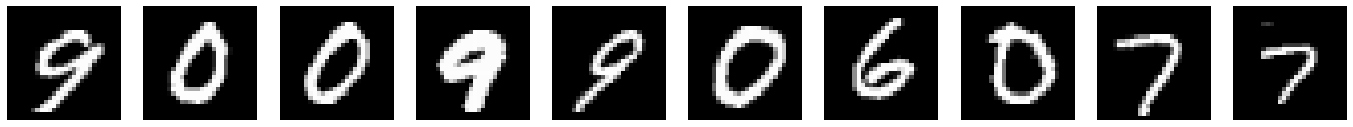

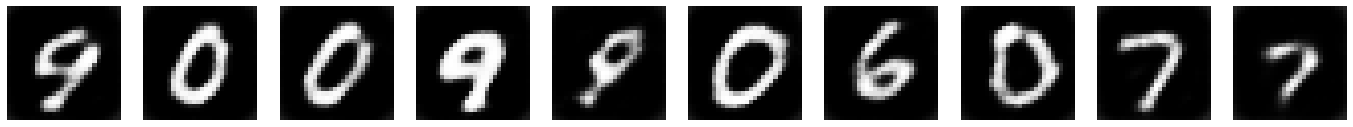

71


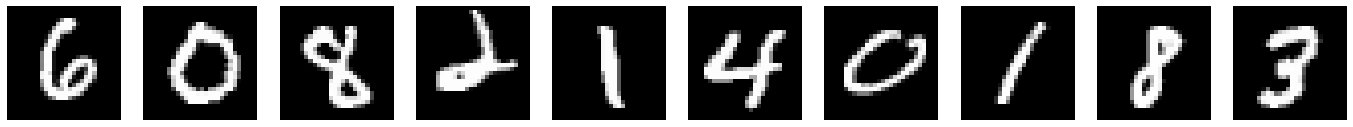

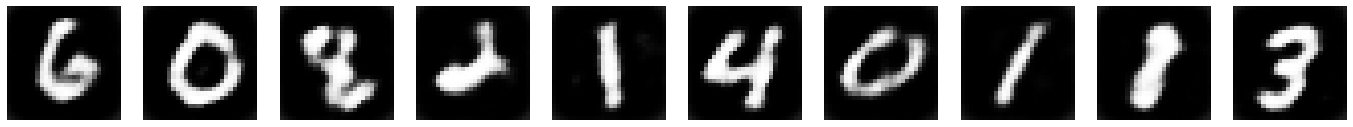

72


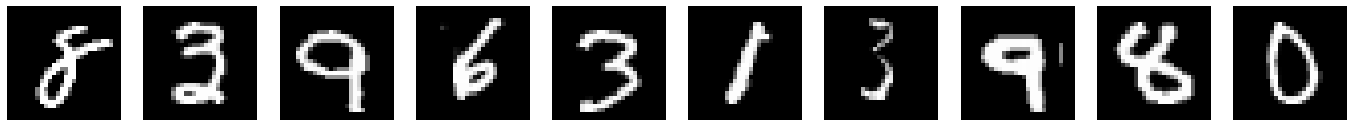

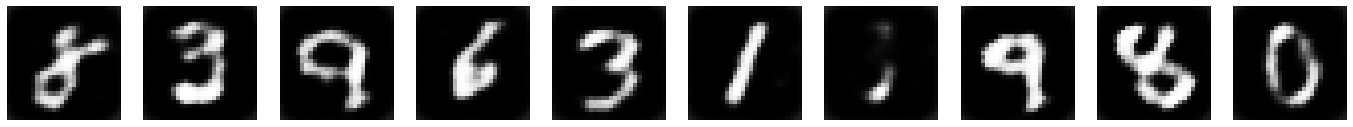

73


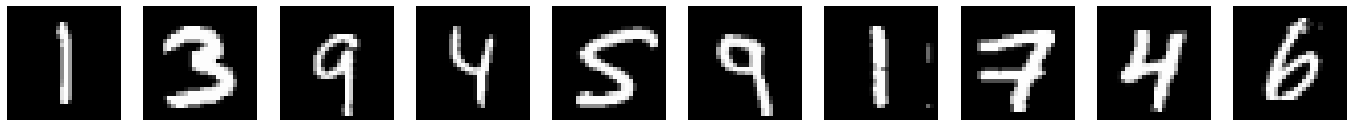

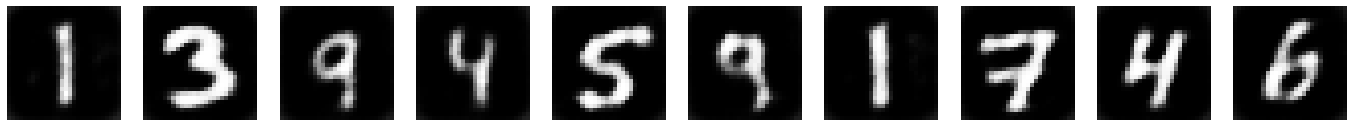

74


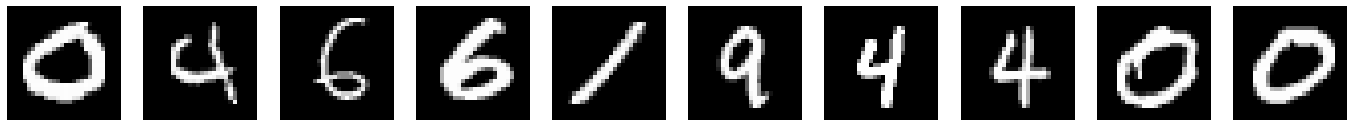

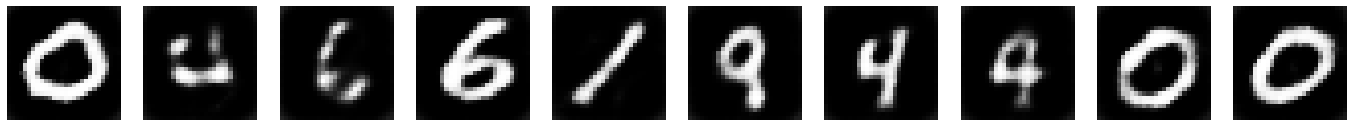

75


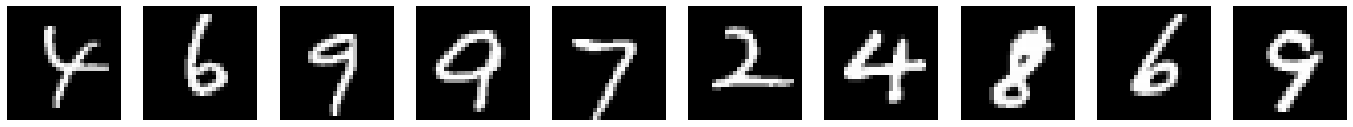

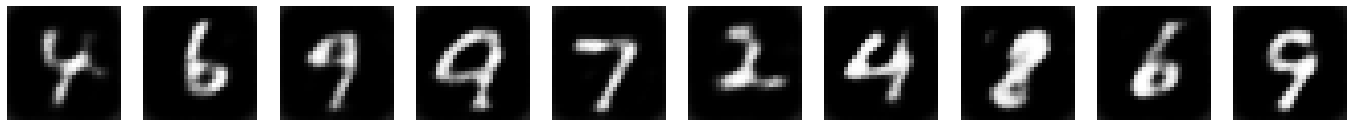

76


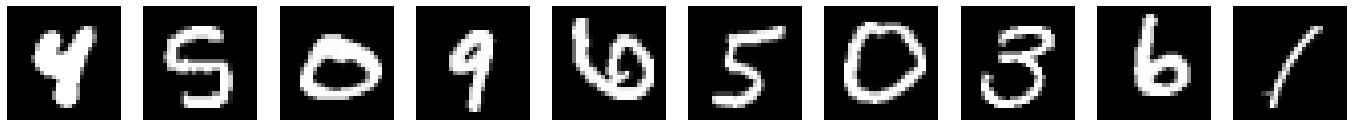

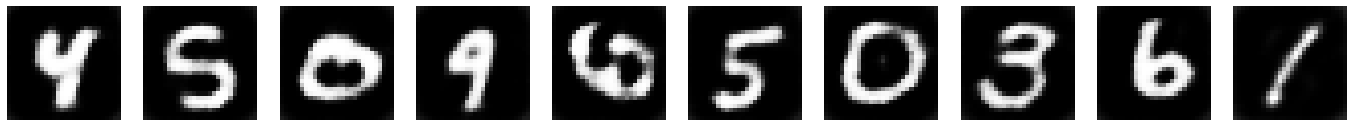

77


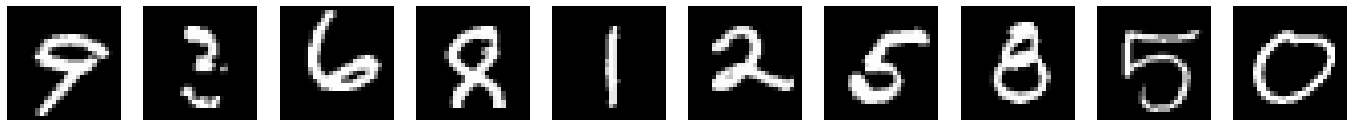

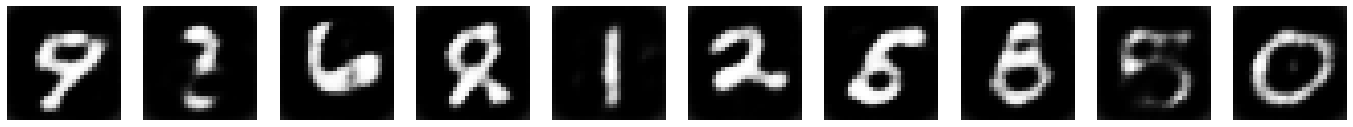

78


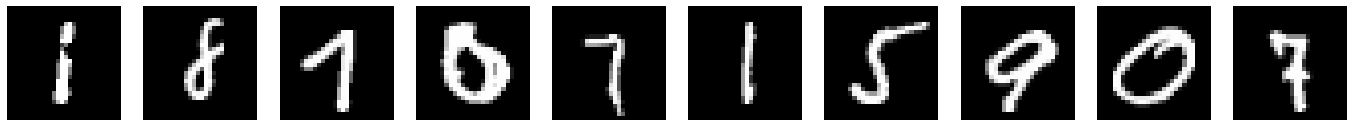

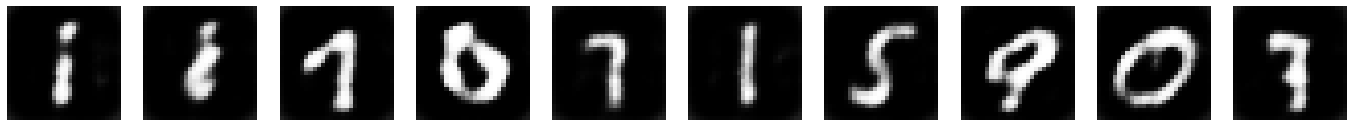

79


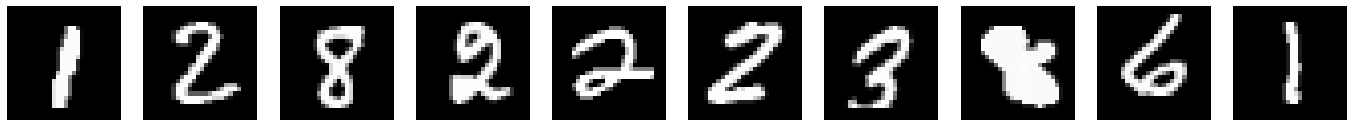

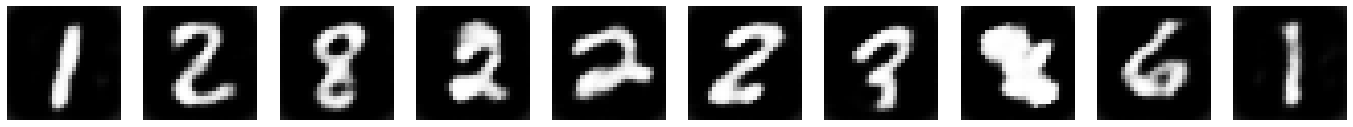

80


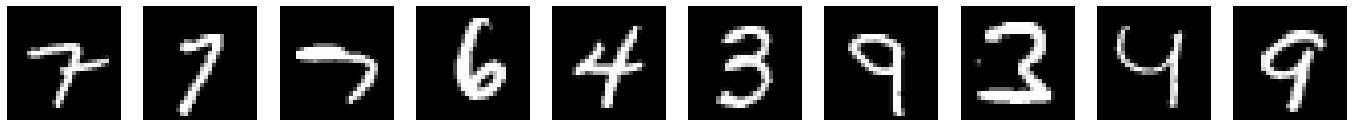

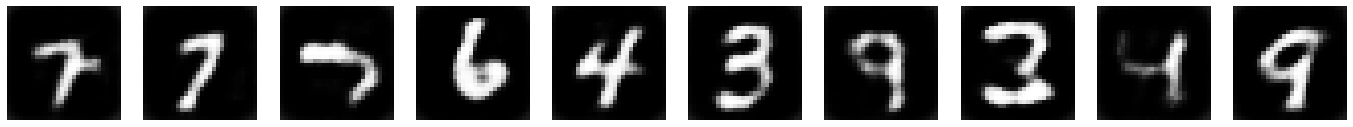

81


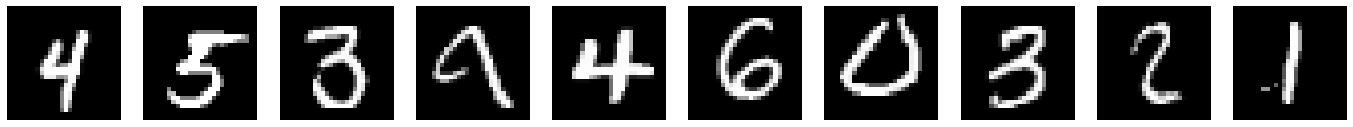

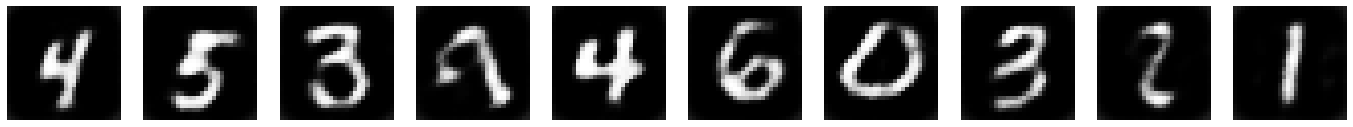

82


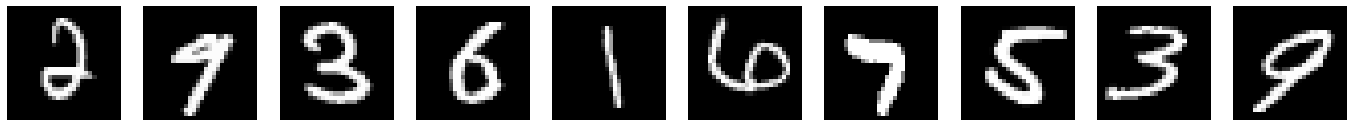

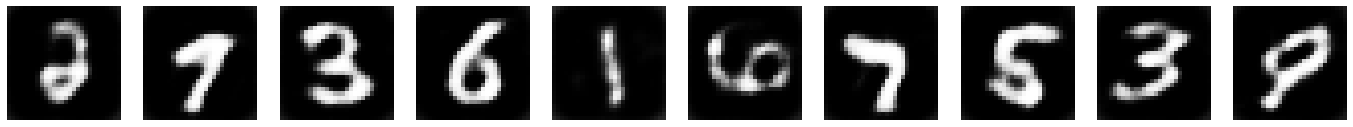

83


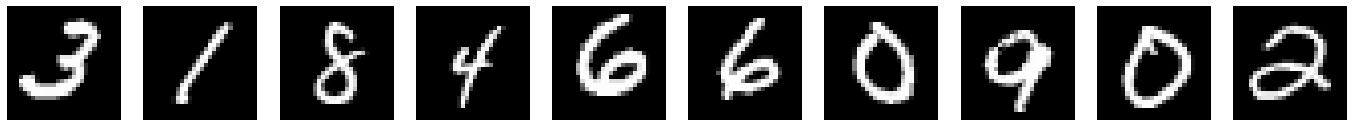

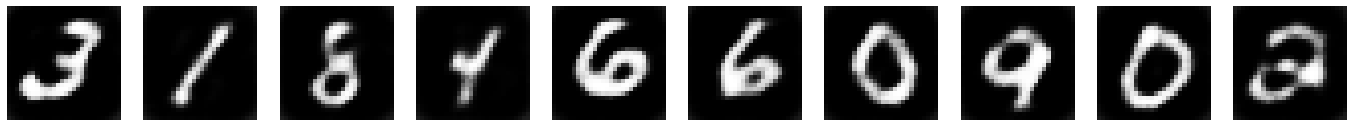

84


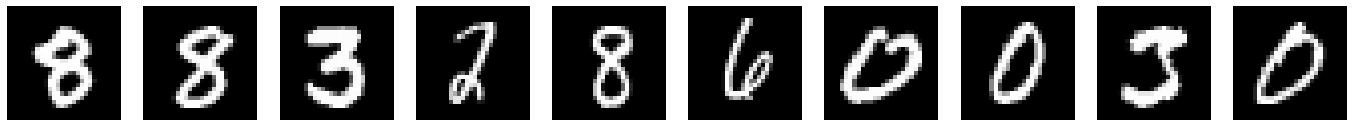

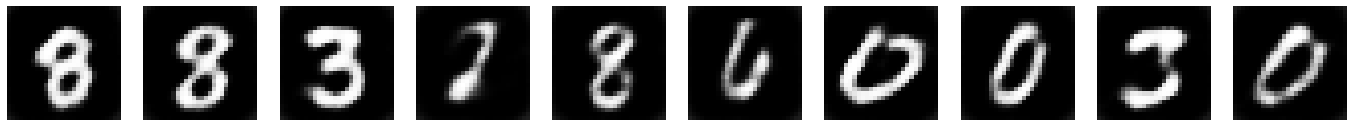

85


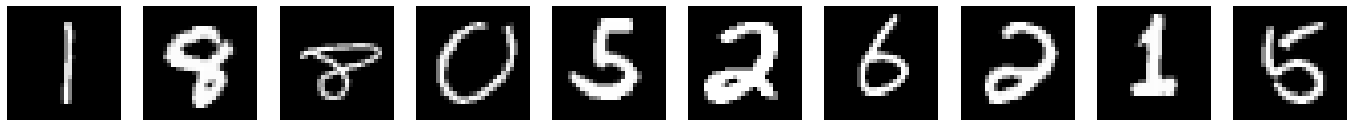

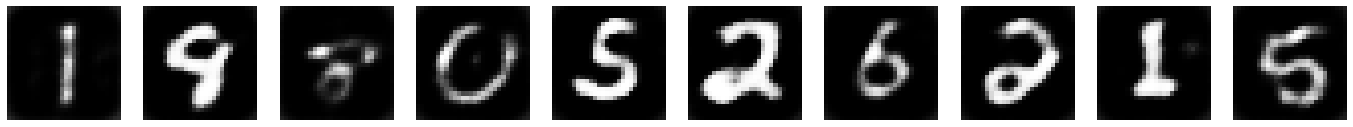

86


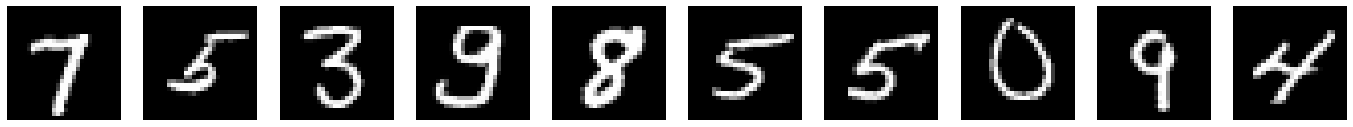

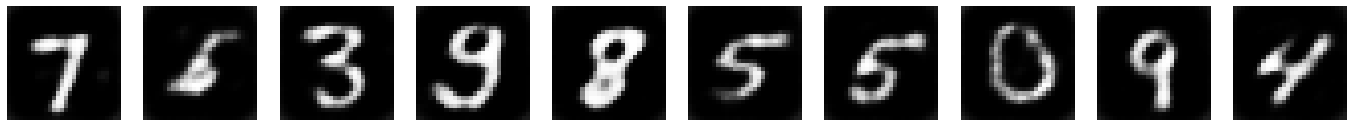

87


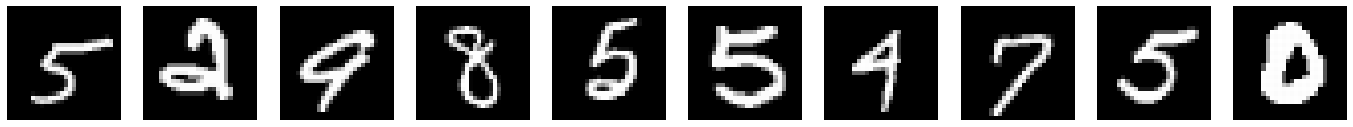

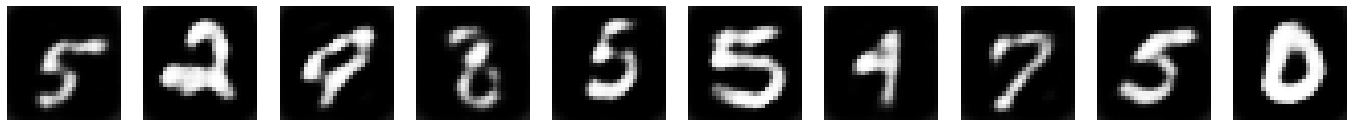

88


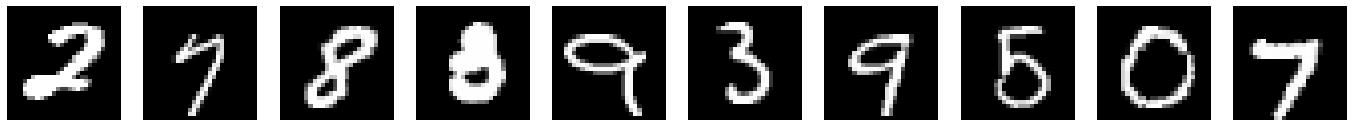

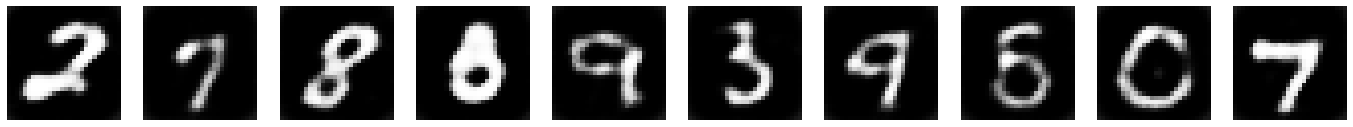

89


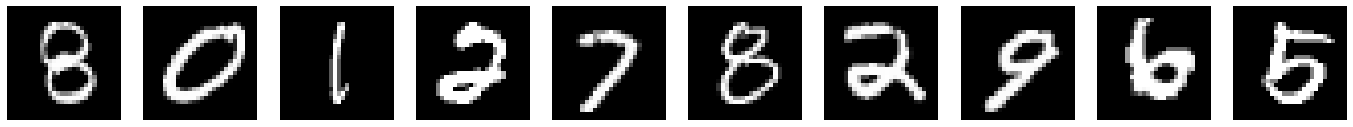

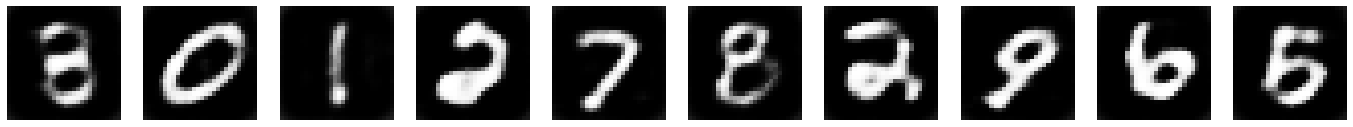

90


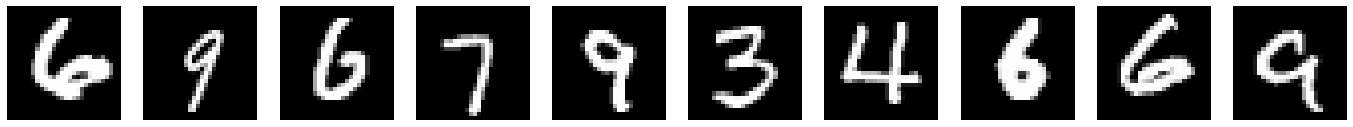

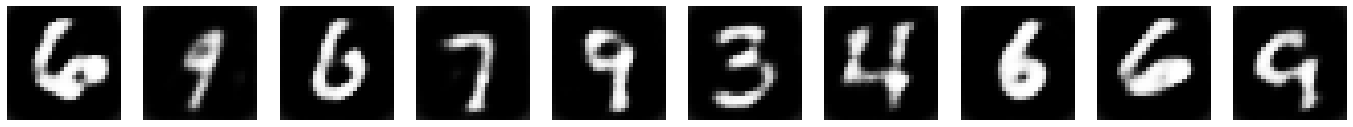

91


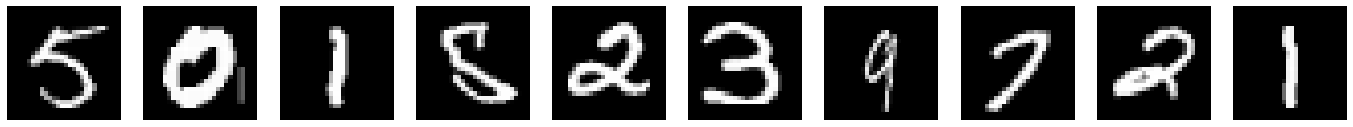

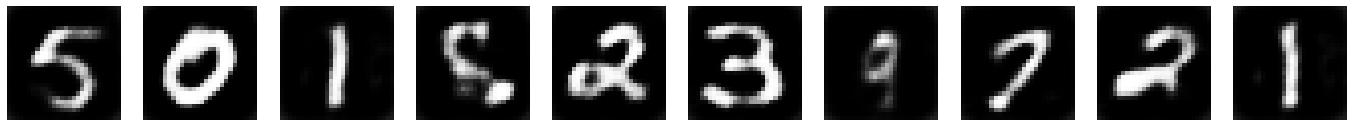

92


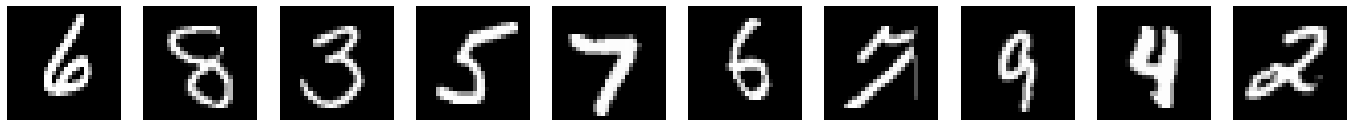

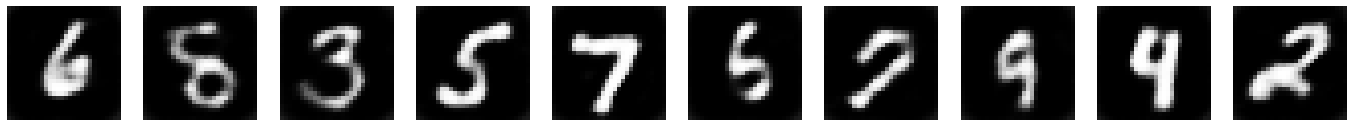

93


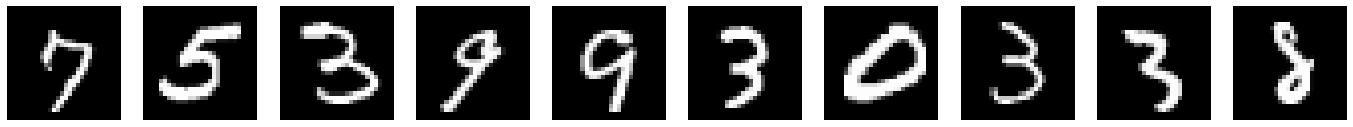

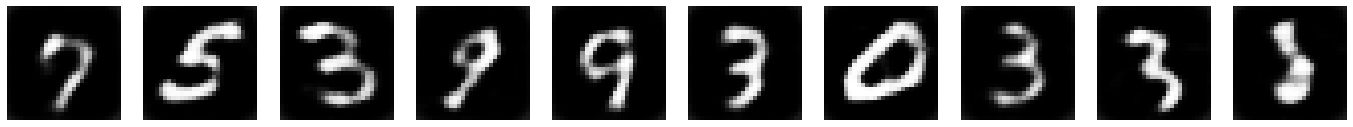

94


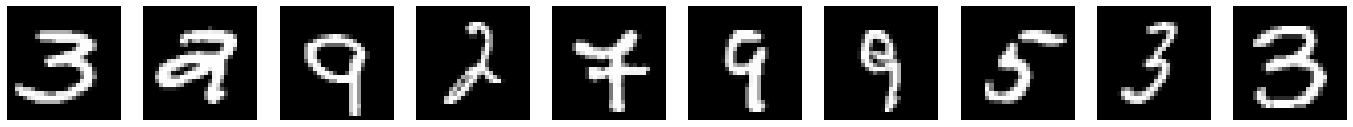

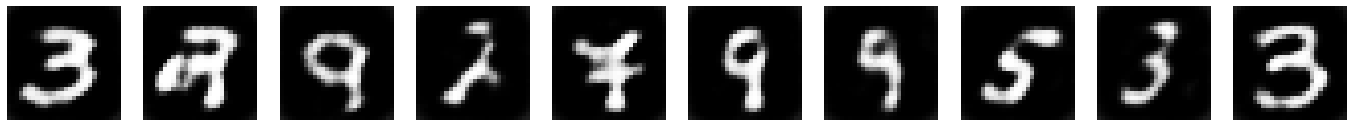

95


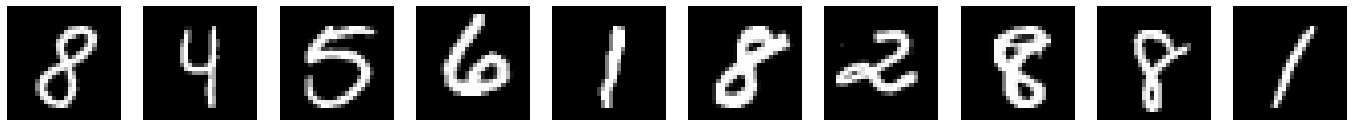

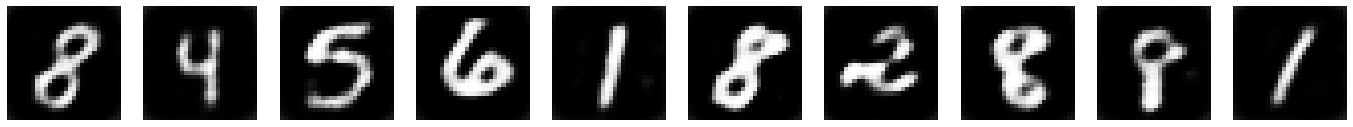

96


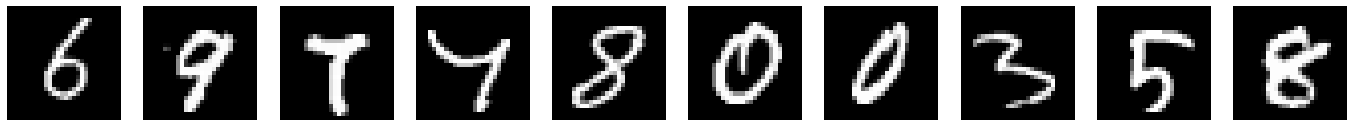

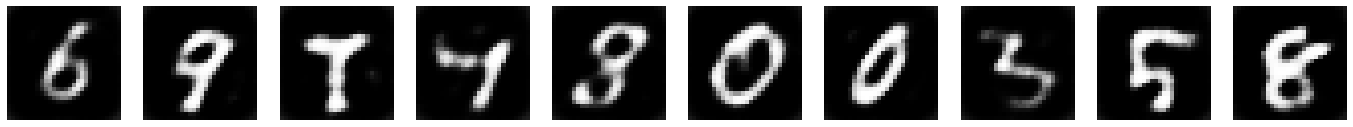

97


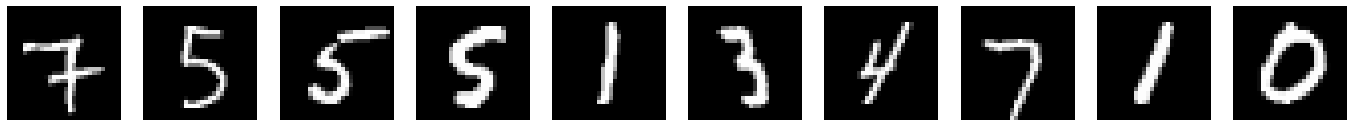

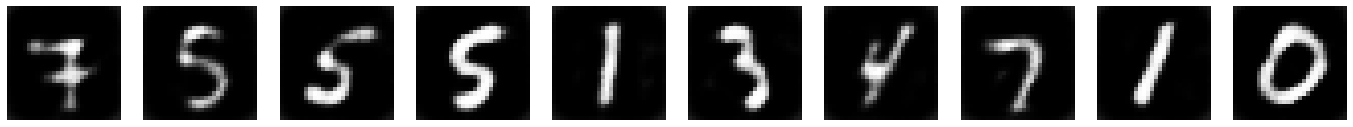

98


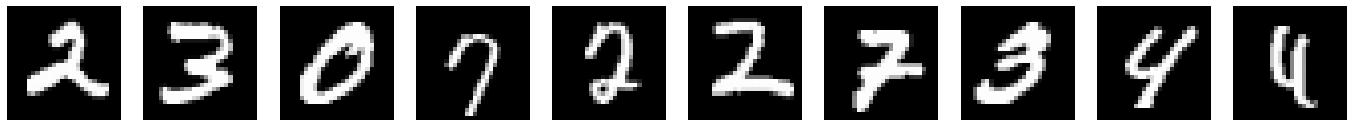

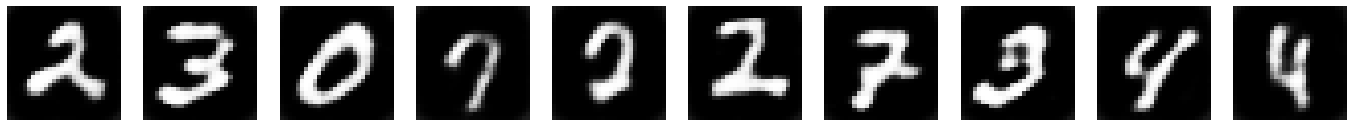

99


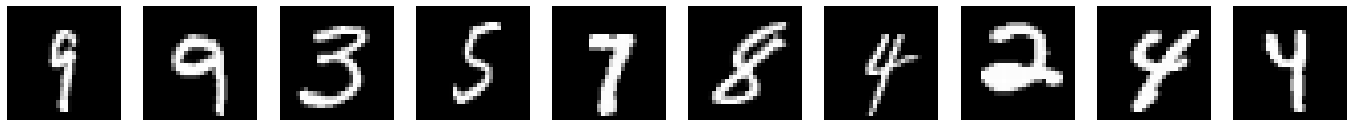

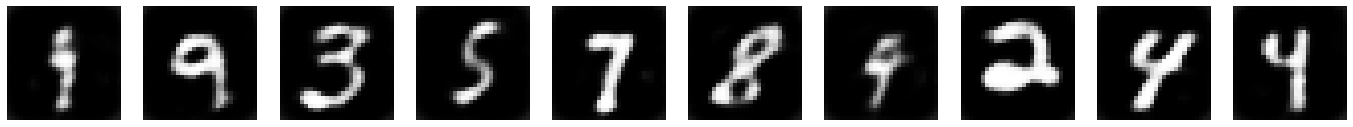

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)
    
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)


# Auto-Encoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 64),
            )
        self.decoder = nn.Sequential(
            nn.Linear(64, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
            )
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec


model=Autoencoder()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion_auto = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
model.train()
loss_list_cnn = []

total_step = len(train_loader)

for epoch in range(100):
  print(epoch)
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion_auto(images, outputs)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i%250 == 0):
      show_images(images[:10].detach())
      show_images(outputs[:10].detach())
      


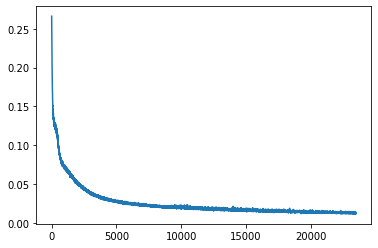

In [ ]:
plt.plot(loss_list_cnn)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        self.cls = nn.Sequential(
            # nn.ReLU(),
            nn.Linear(64, 32),
            nn.Linear(32, 10)
            )
    def forward(self, x):
        outs = self.cls(x)
        return outs


model.eval()
model_c=Classifier()
model_c.cuda()
model_c.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model_c.parameters()) + list(model.encoder.parameters()), lr=learning_rate)
model_c.train()
model.encoder.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

images = torch.zeros(12,256,1,28,28)
labels = torch.zeros(12,256)

#256 samples
for i in range(12):
  images[i], labels[i] = next(iter(train_loader))

images = images.cuda()
labels = labels.cuda()


for epoch in range(200):
  for i in range(12):
    representations = model.encoder(images[i])
    outputs = model_c(representations)

    loss = criterion(outputs, labels[i].long())
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels[i].size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels[i]).sum().item()
    acc_list_cnn.append(correct / total)

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
            .format(epoch + 1, num_epochs, 0, total_step, loss.item(),
                    (correct / total) * 100))
      
model.encoder.eval()
model_c.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      representations = model.encoder(images)
      outputs = model_c(representations)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


Epoch [1/10], Step [0/235], Loss: 28.2928, Accuracy: 12.89%
Epoch [1/10], Step [0/235], Loss: 15.6718, Accuracy: 9.77%
Epoch [1/10], Step [0/235], Loss: 11.7857, Accuracy: 23.83%
Epoch [1/10], Step [0/235], Loss: 7.9590, Accuracy: 26.56%
Epoch [1/10], Step [0/235], Loss: 6.6067, Accuracy: 33.20%
Epoch [1/10], Step [0/235], Loss: 7.0114, Accuracy: 32.42%
Epoch [1/10], Step [0/235], Loss: 6.0453, Accuracy: 37.89%
Epoch [1/10], Step [0/235], Loss: 4.4036, Accuracy: 46.48%
Epoch [1/10], Step [0/235], Loss: 3.0929, Accuracy: 58.20%
Epoch [1/10], Step [0/235], Loss: 2.8305, Accuracy: 61.33%
Epoch [1/10], Step [0/235], Loss: 2.1982, Accuracy: 59.38%
Epoch [1/10], Step [0/235], Loss: 1.7654, Accuracy: 67.19%
Epoch [2/10], Step [0/235], Loss: 1.1969, Accuracy: 75.78%
Epoch [2/10], Step [0/235], Loss: 0.8955, Accuracy: 77.73%
Epoch [2/10], Step [0/235], Loss: 1.2673, Accuracy: 74.61%
Epoch [2/10], Step [0/235], Loss: 1.4356, Accuracy: 70.70%
Epoch [2/10], Step [0/235], Loss: 1.2364, Accuracy: 71

**Auto-encoder Image Tranfer:**
Inverse the color of the MNIST dataset.


0


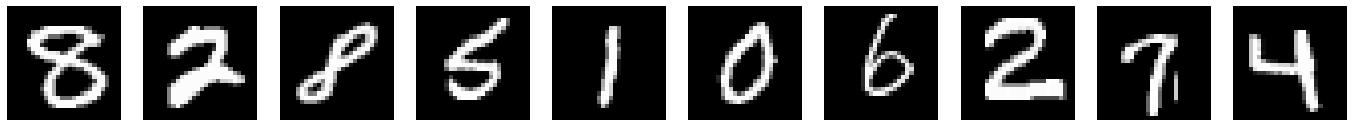

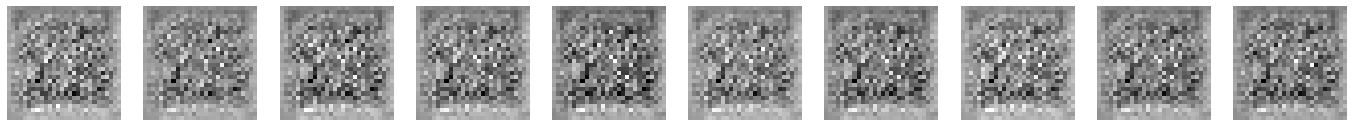

1


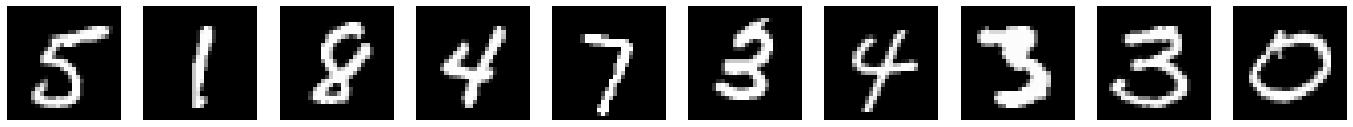

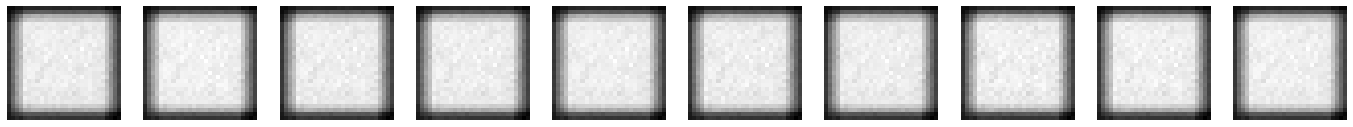

2


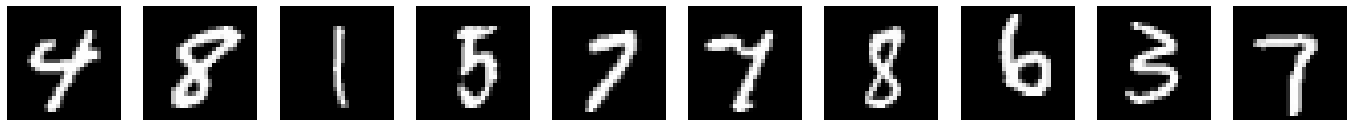

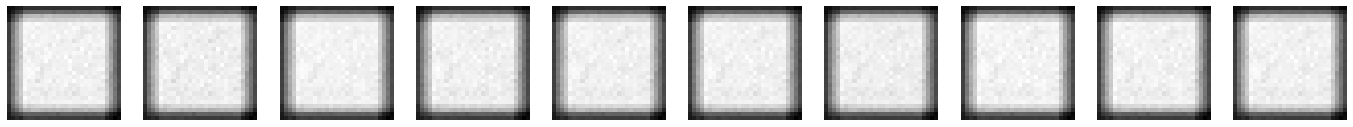

3


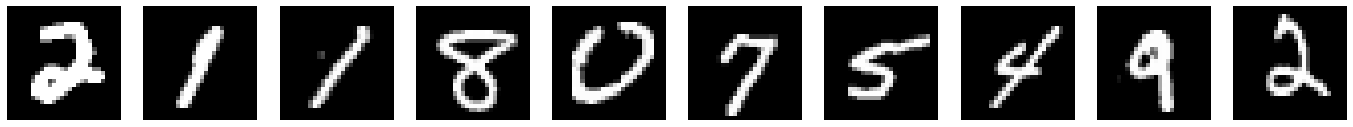

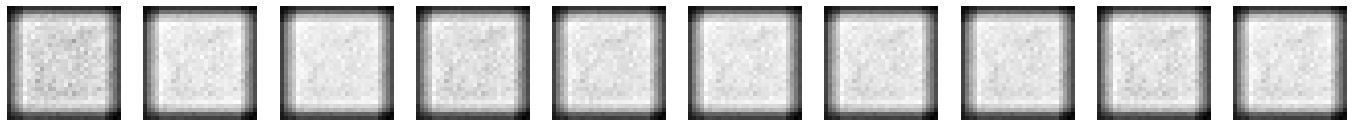

4


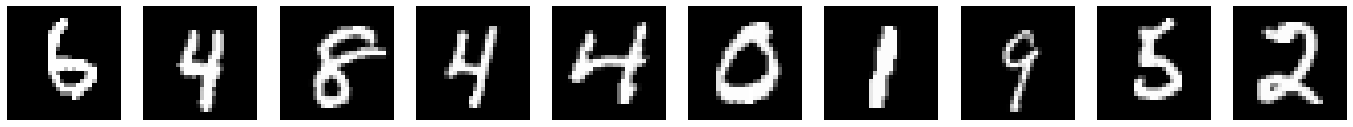

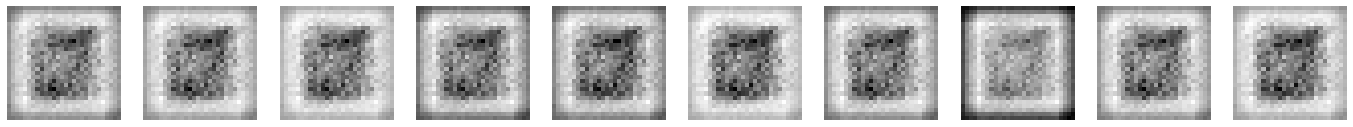

5


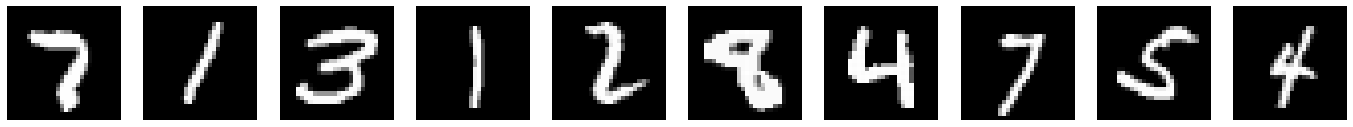

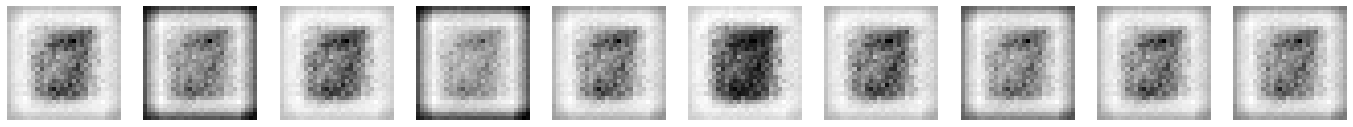

6


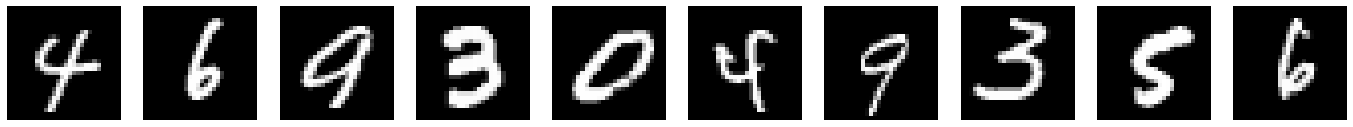

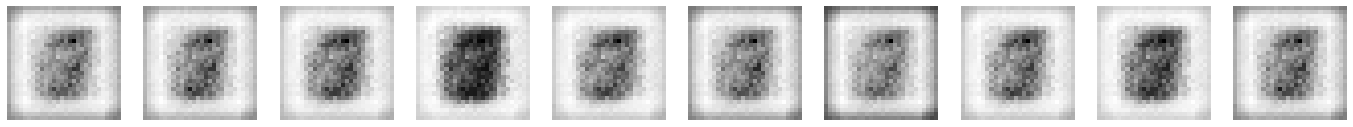

7


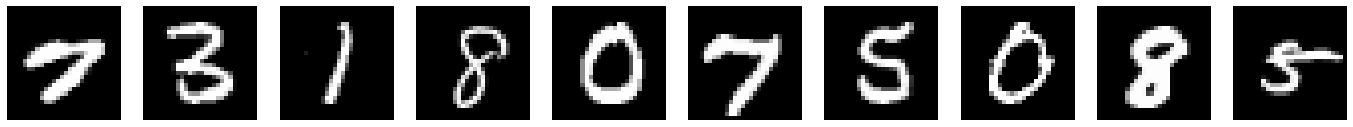

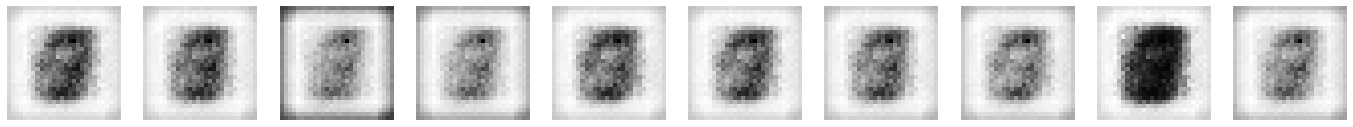

8


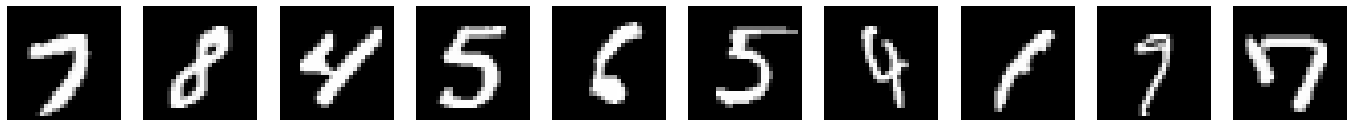

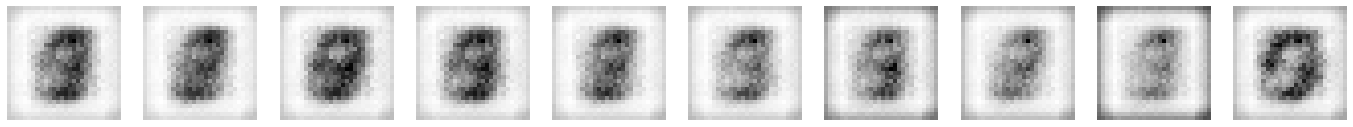

9


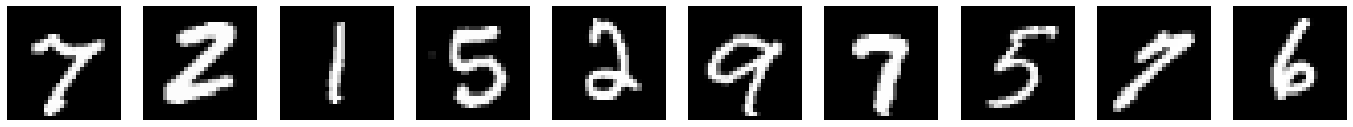

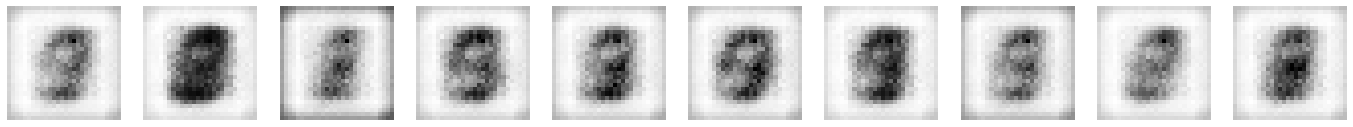

10


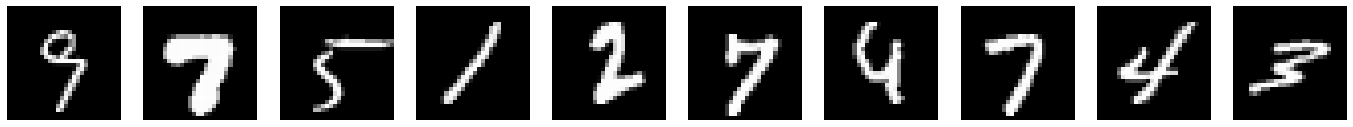

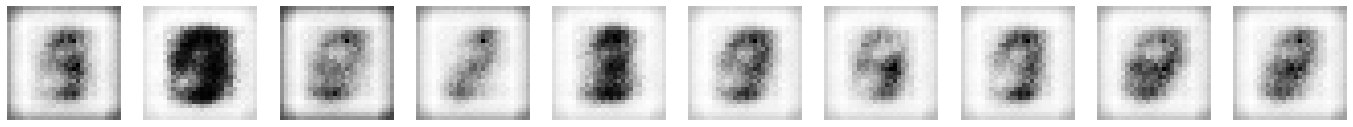

11


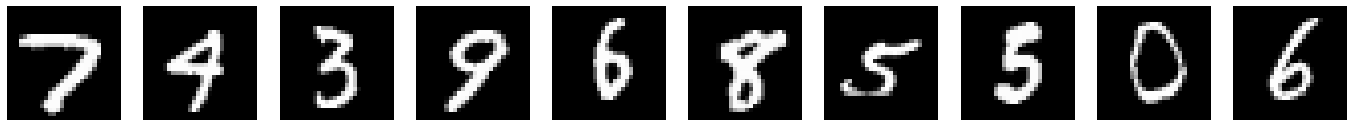

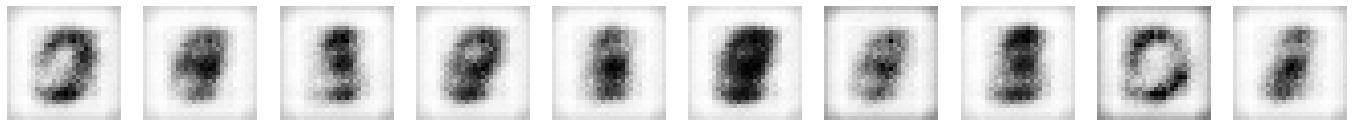

12


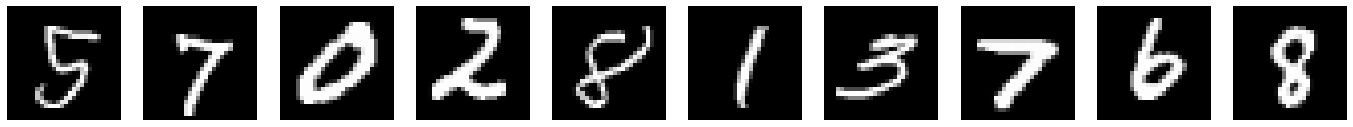

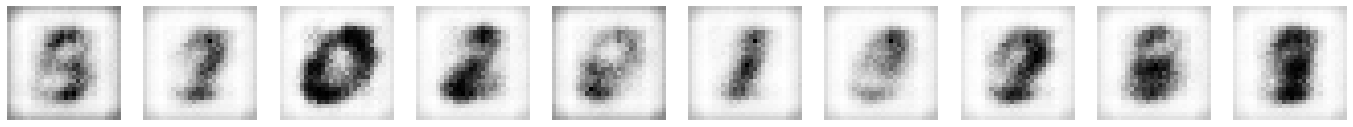

13


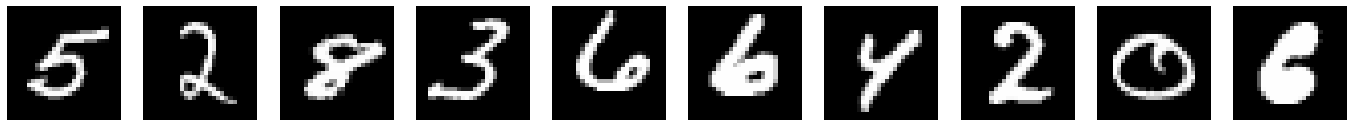

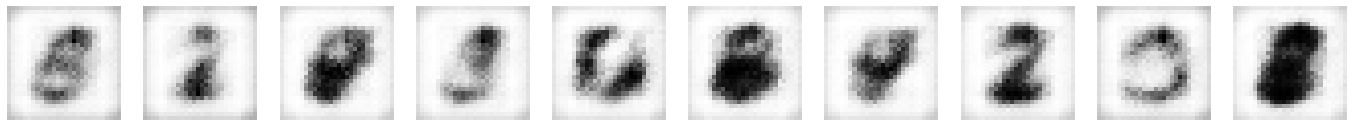

14


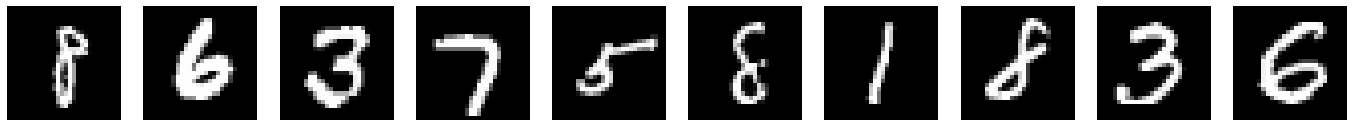

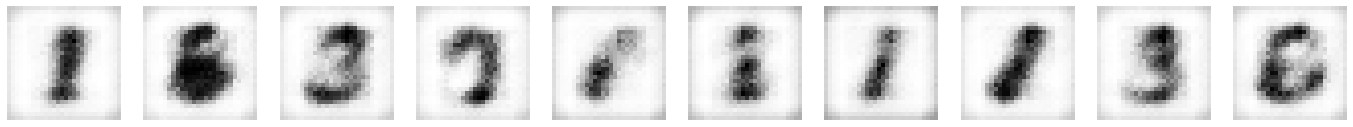

15


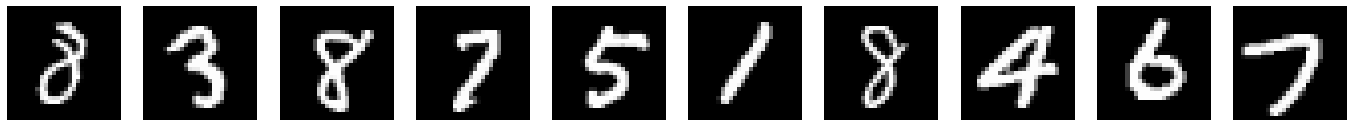

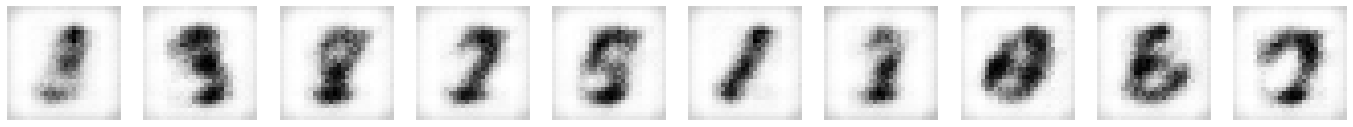

16


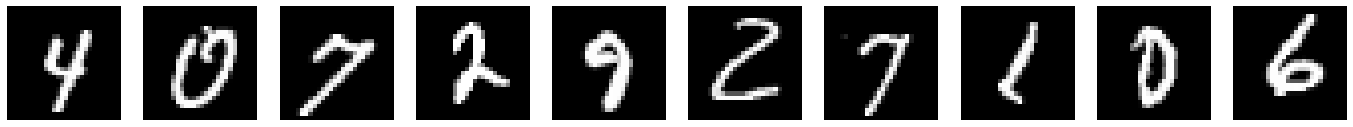

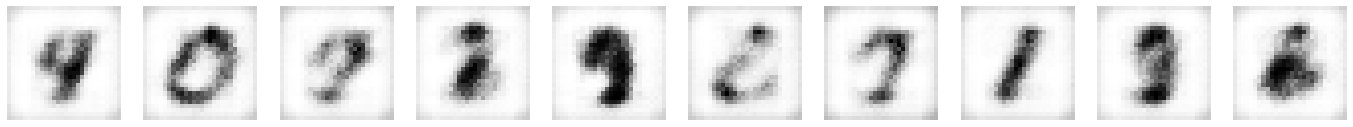

17


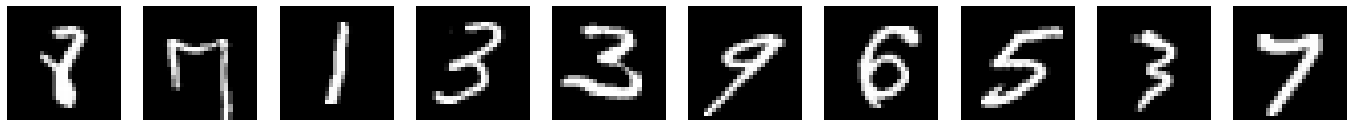

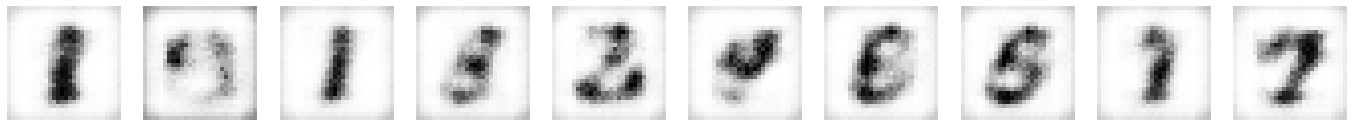

18


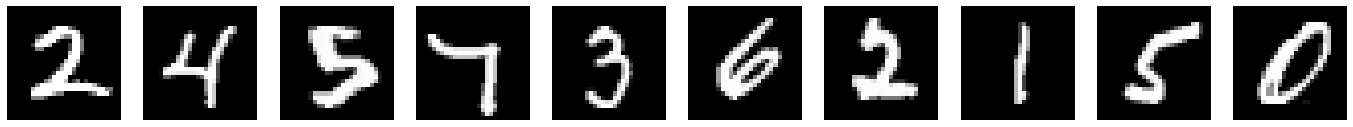

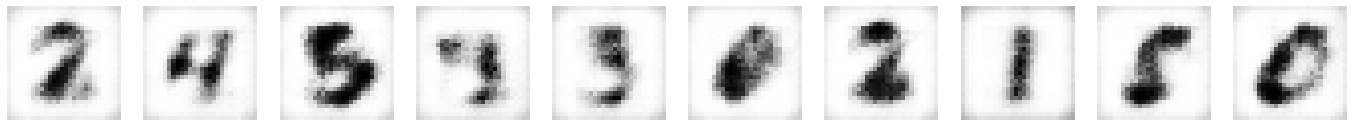

19


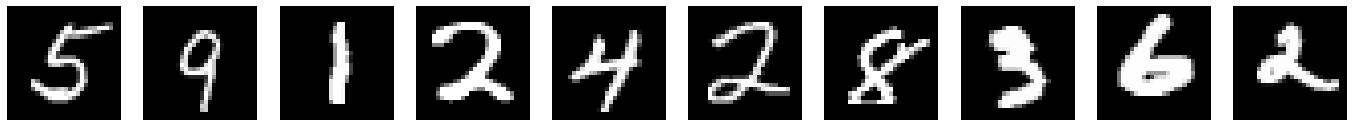

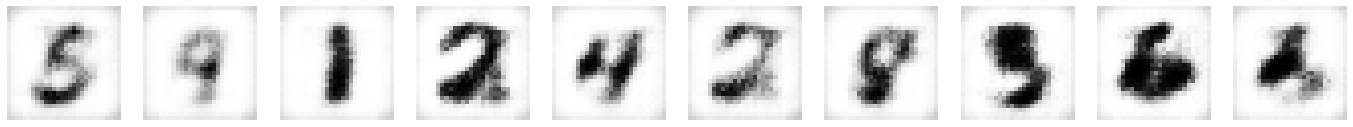

20


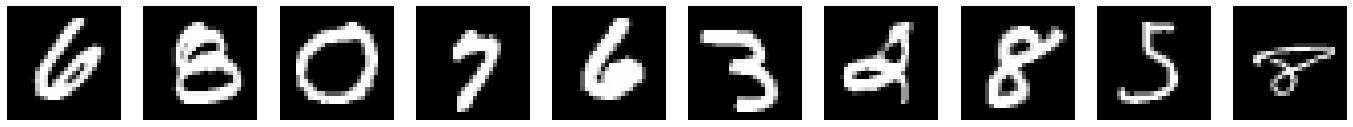

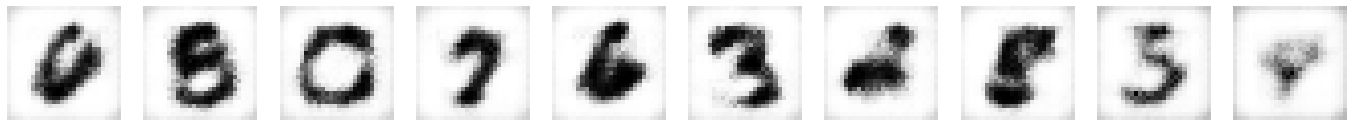

21


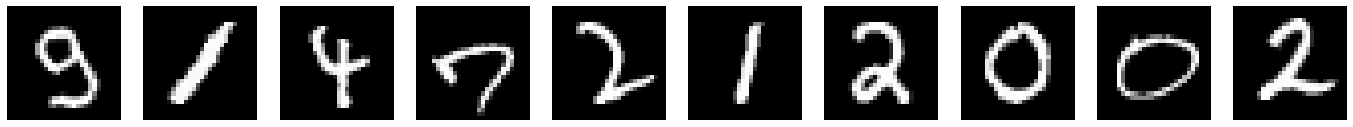

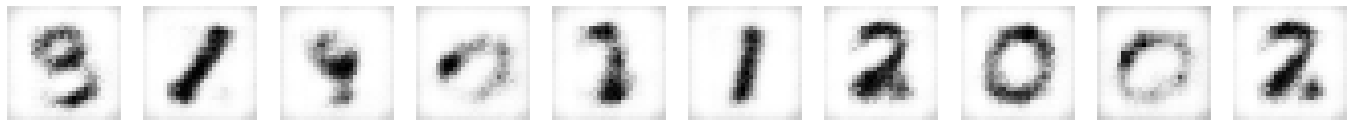

22


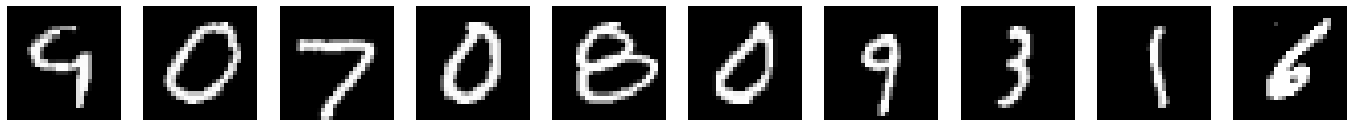

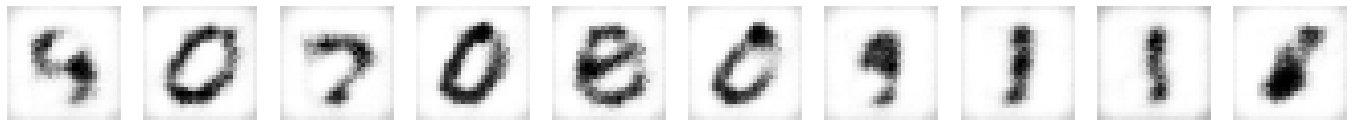

23


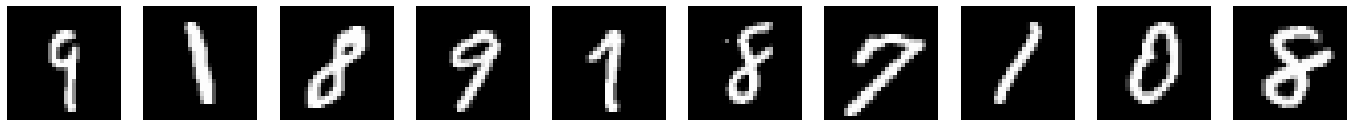

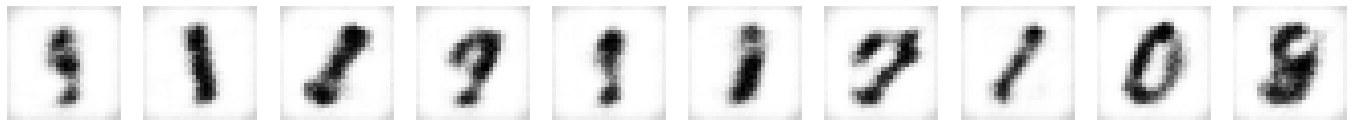

24


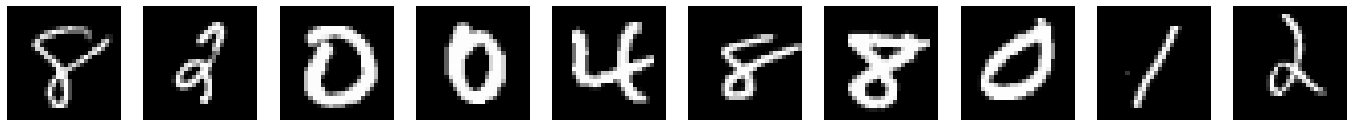

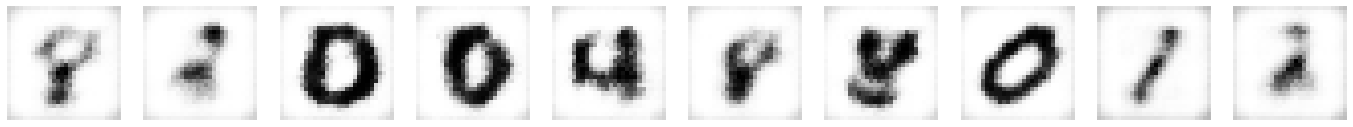

25


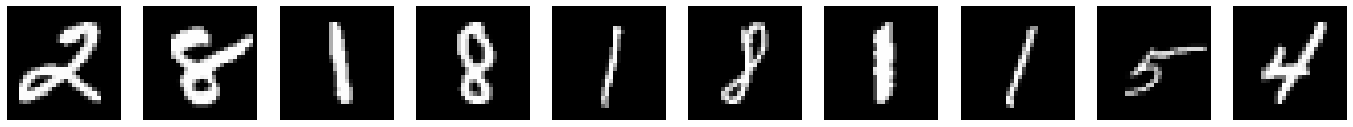

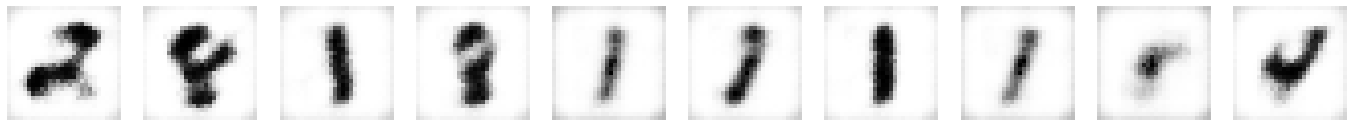

26


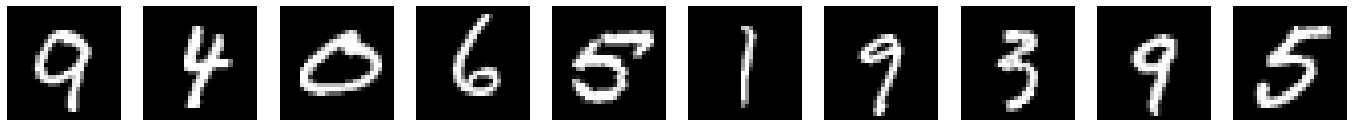

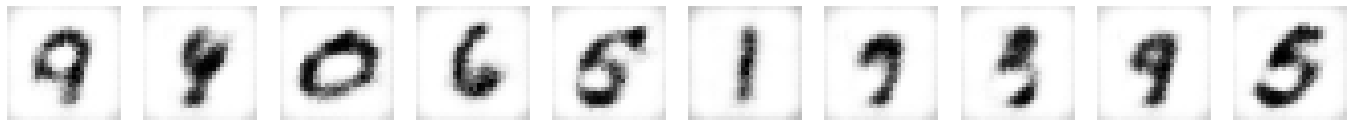

27


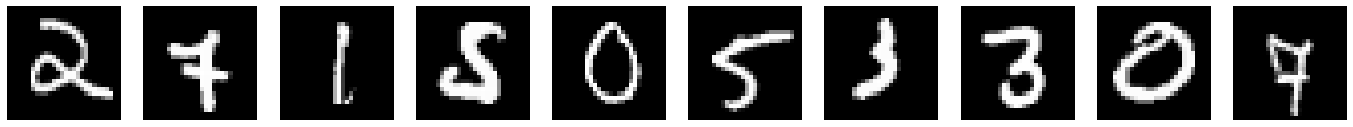

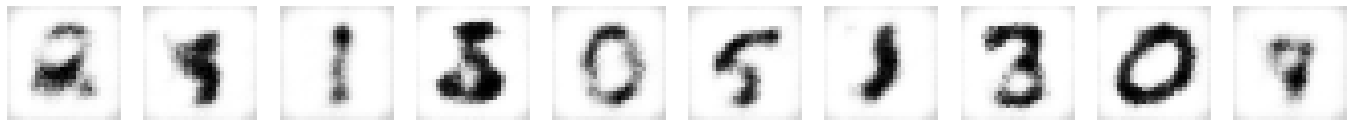

28


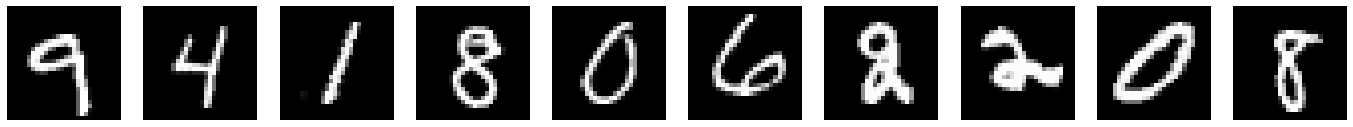

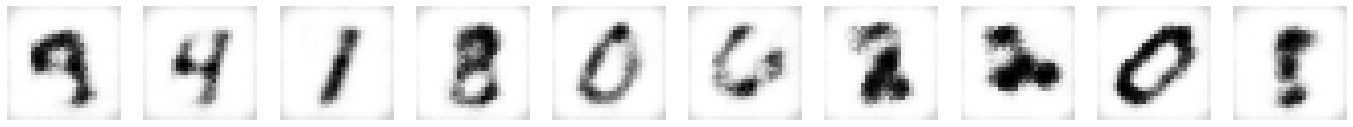

29


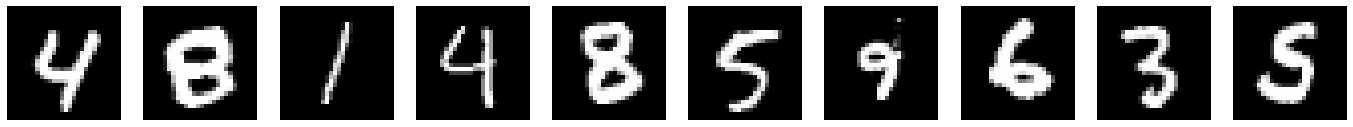

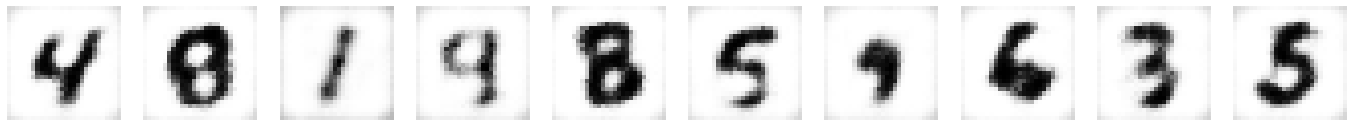

30


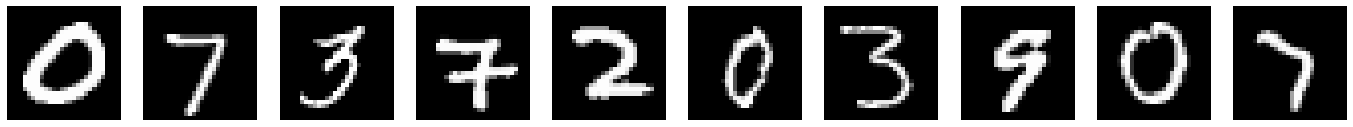

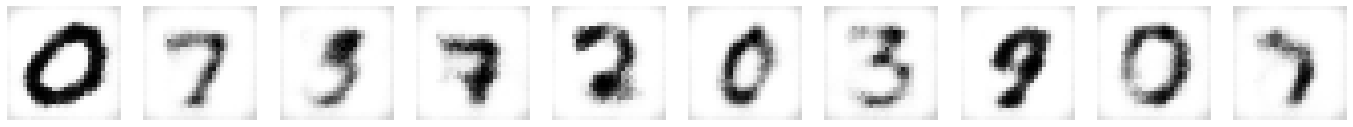

31


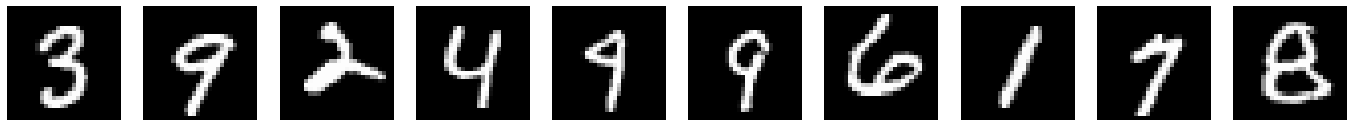

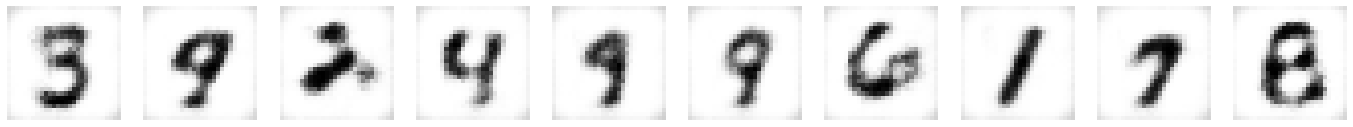

32


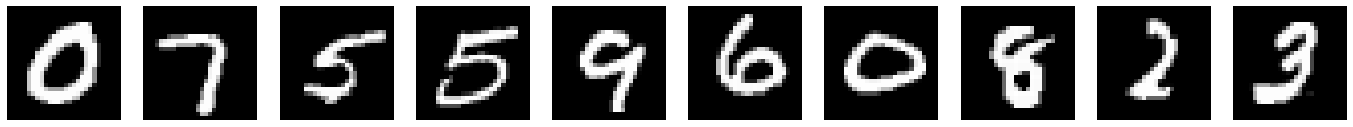

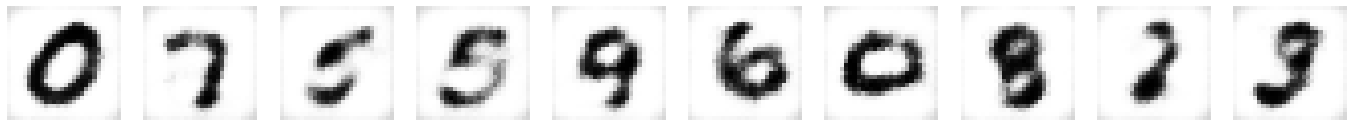

33


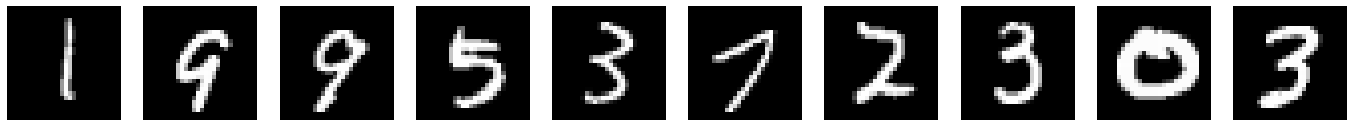

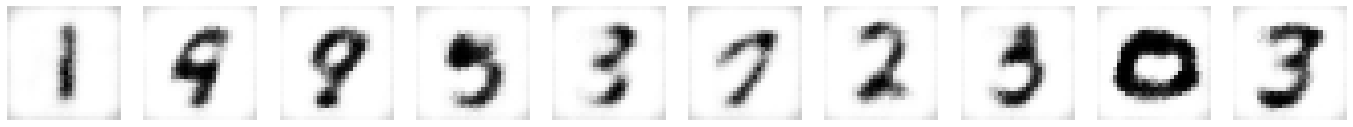

34


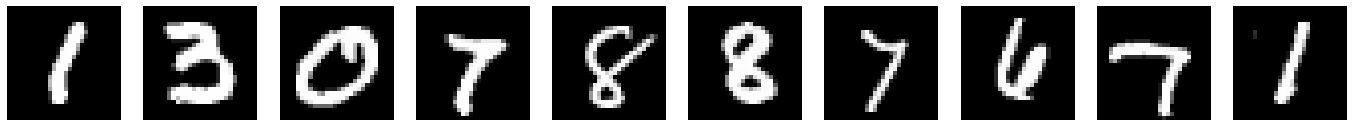

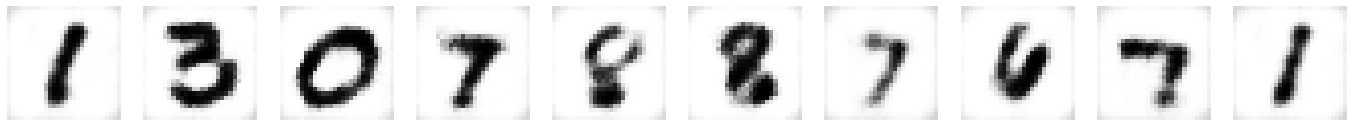

35


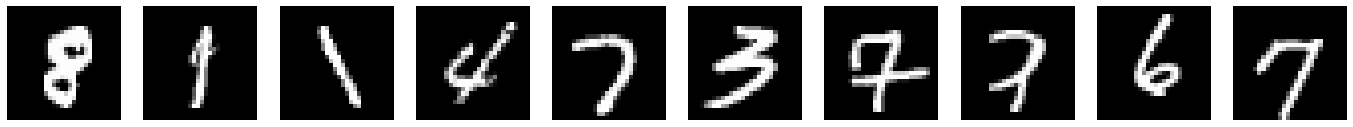

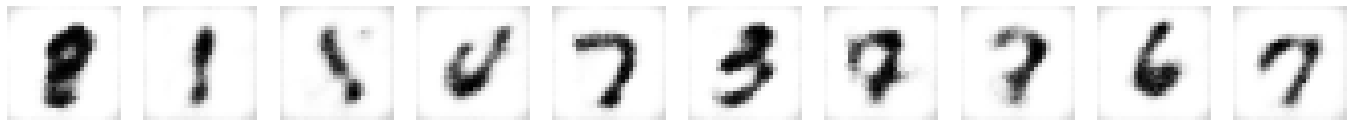

36


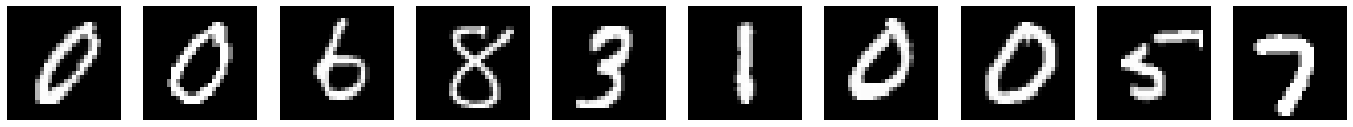

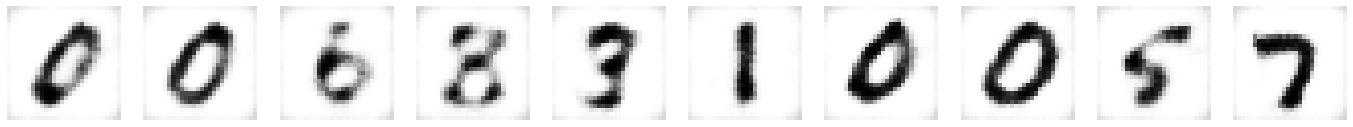

37


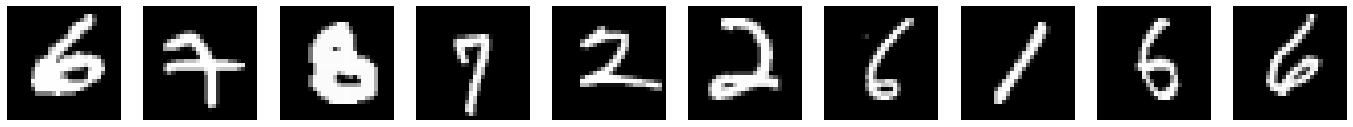

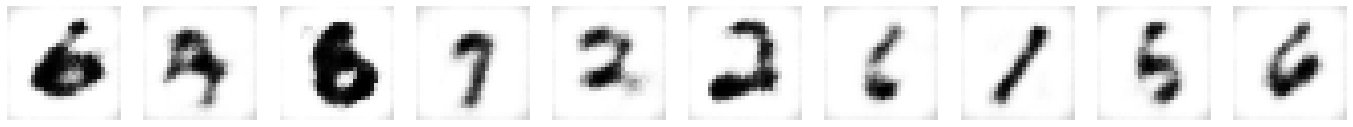

38


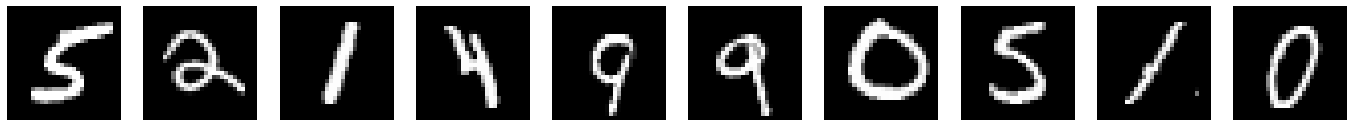

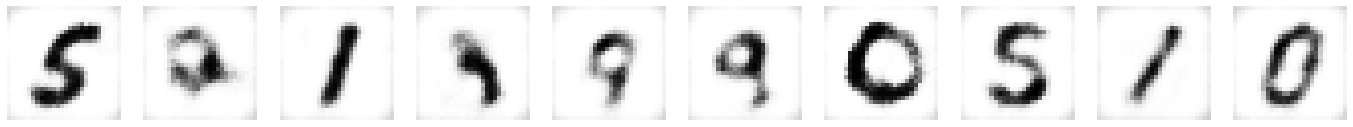

39


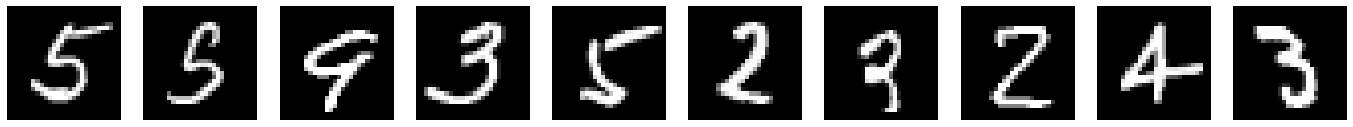

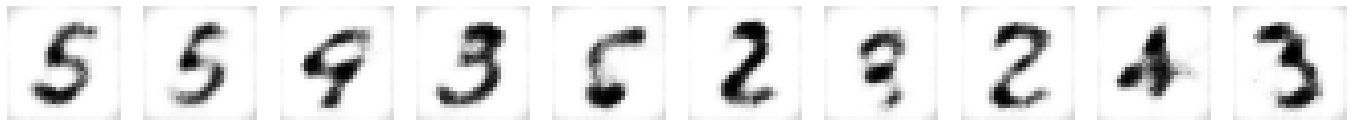

40


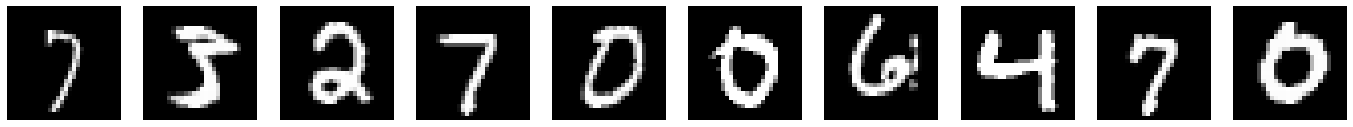

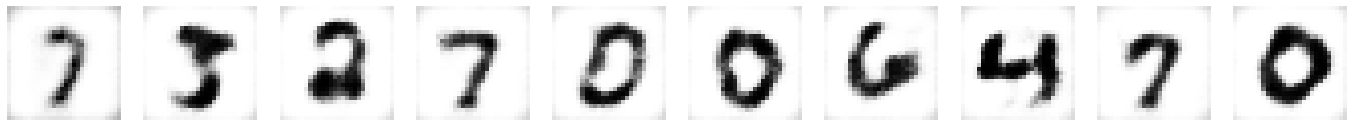

41


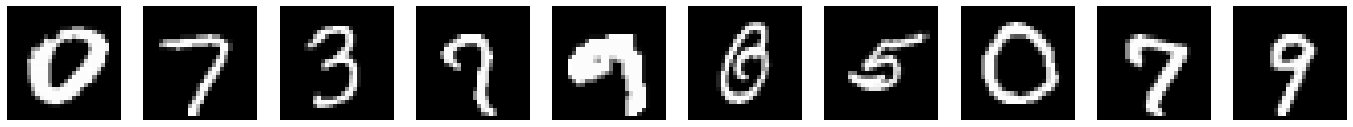

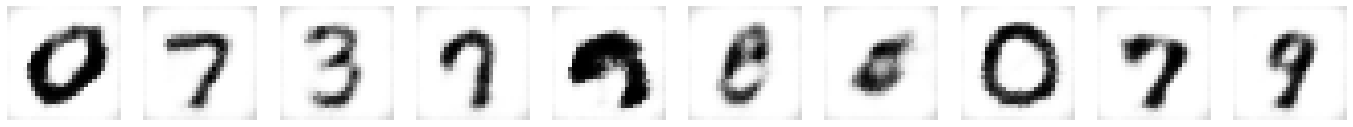

42


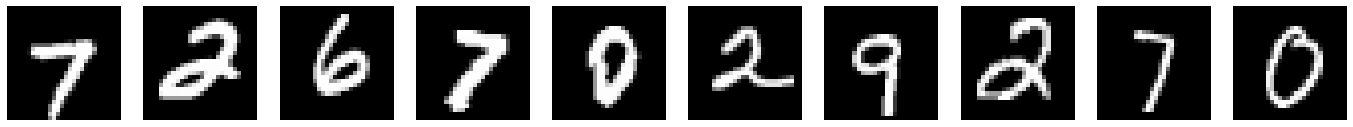

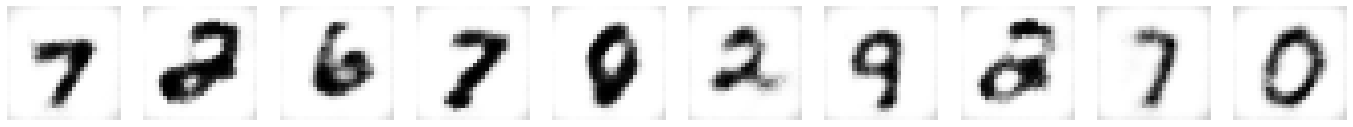

43


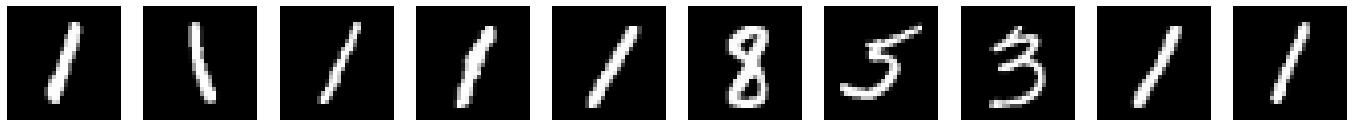

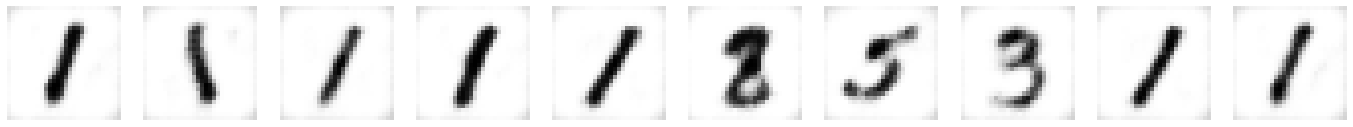

44


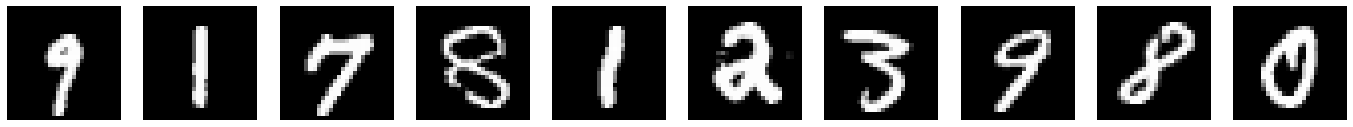

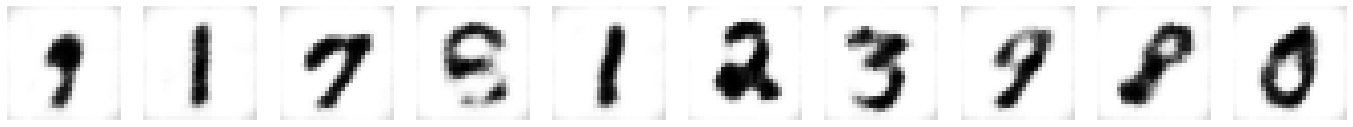

45


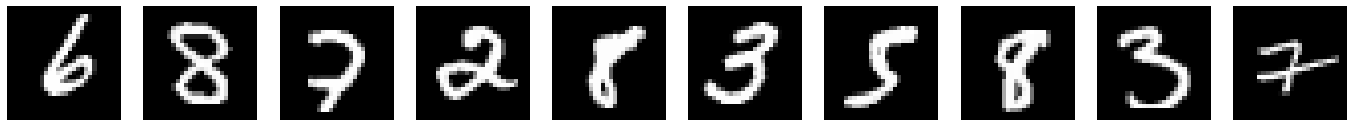

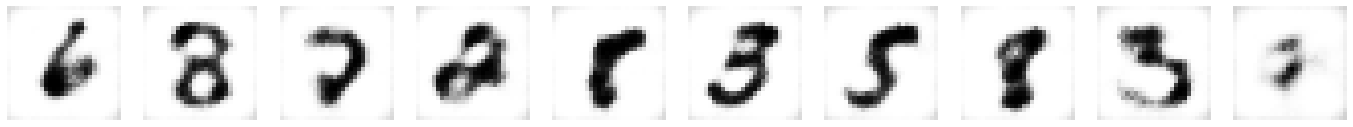

46


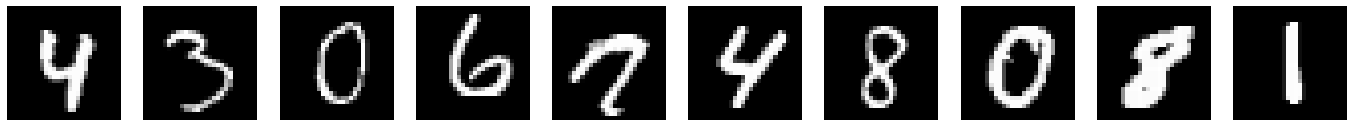

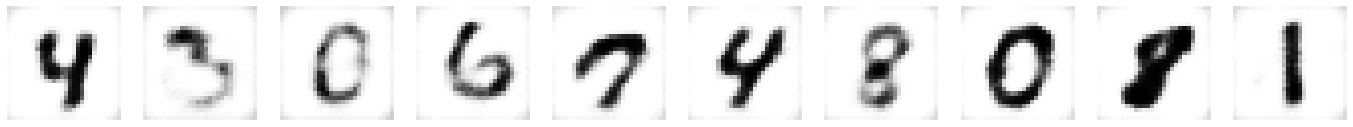

47


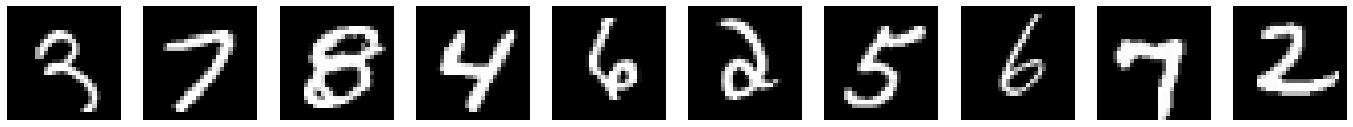

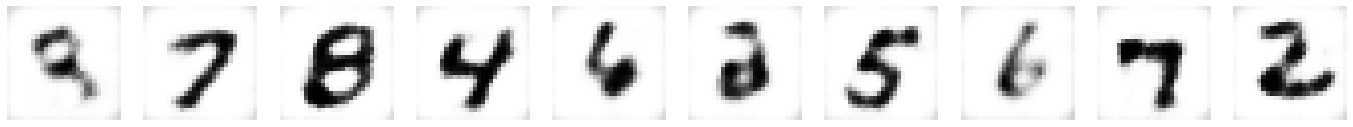

48


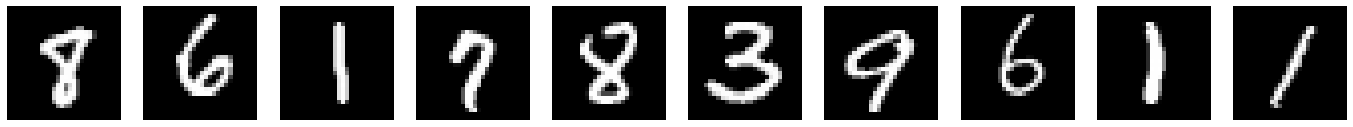

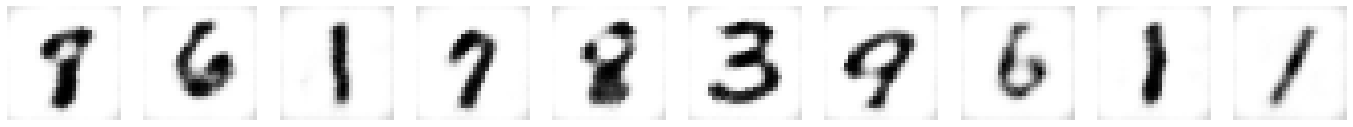

49


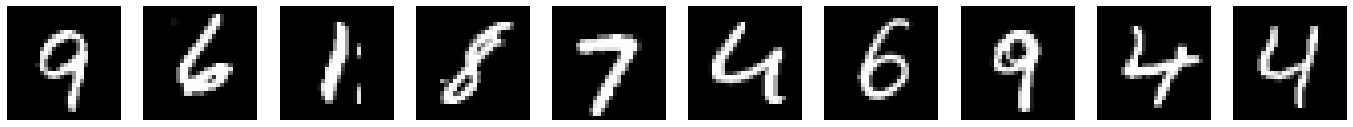

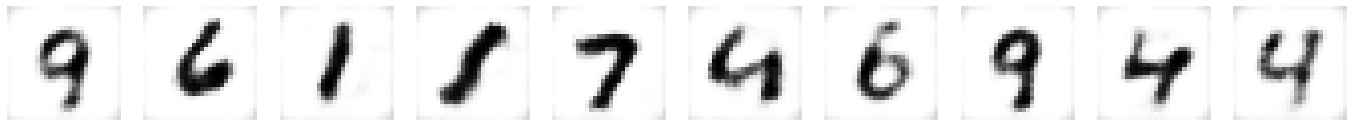

In [ ]:
# original image as input and inverse image as output

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)
    
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)


# Auto-Encoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 64),
            )
        self.decoder = nn.Sequential(
            nn.Linear(64, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
            )
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec


model=Autoencoder()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion_auto = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
model.train()
loss_list_cnn = []

total_step = len(train_loader)

for epoch in range(50):
  print(epoch)
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion_auto(1-images, outputs)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i%250 == 0):
      show_images(images[:10].detach())
      show_images(outputs[:10].detach())
      


0


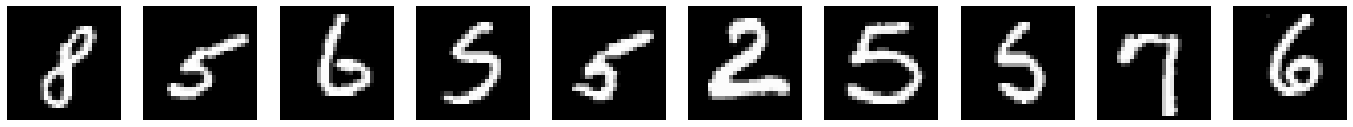

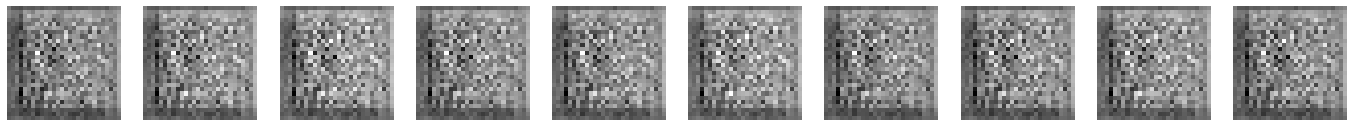

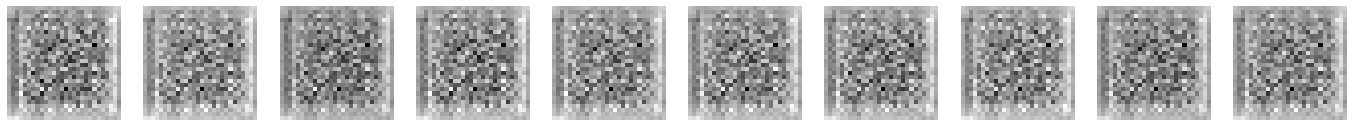

1


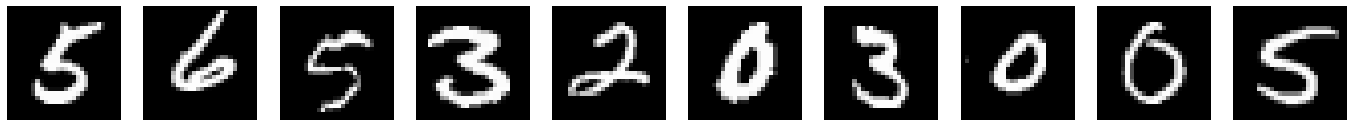

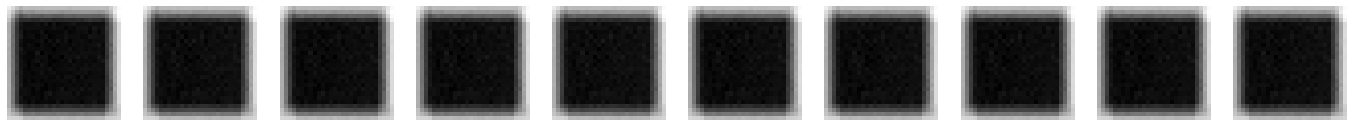

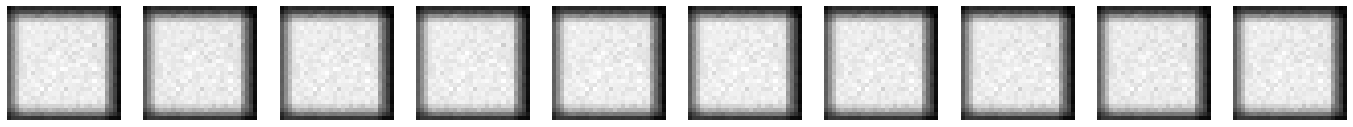

2


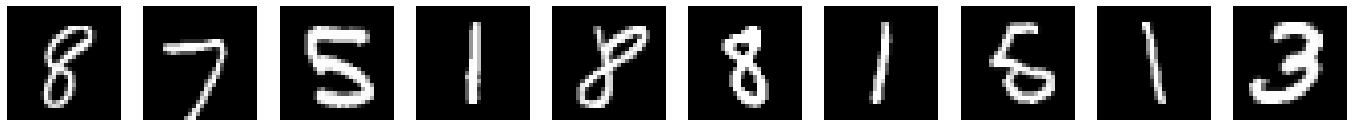

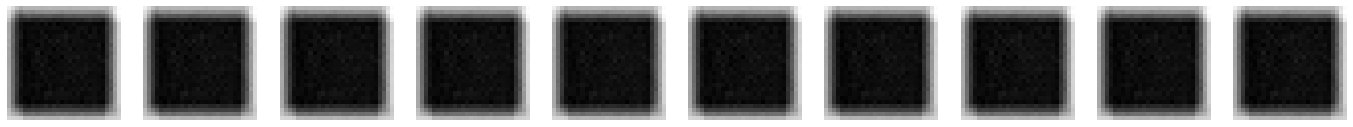

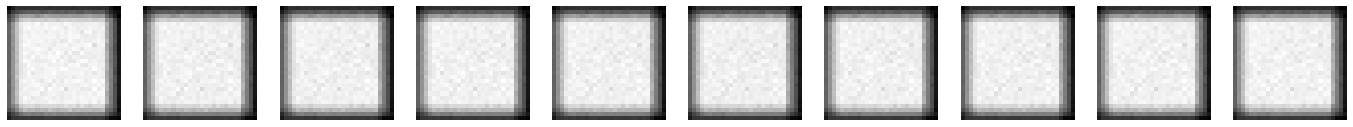

3


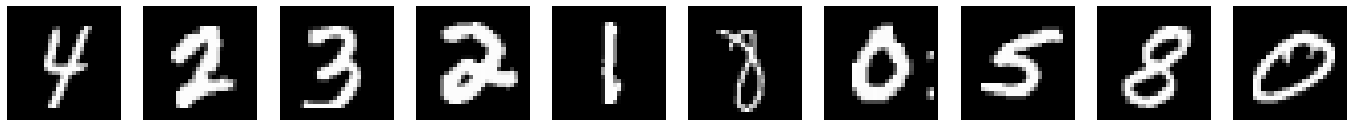

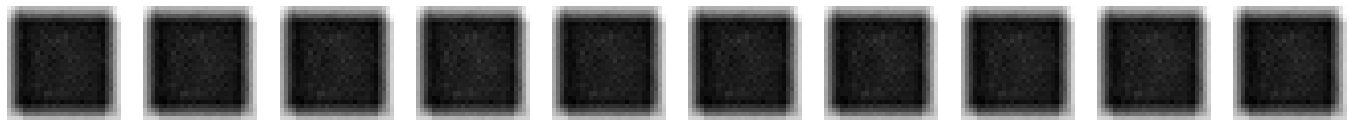

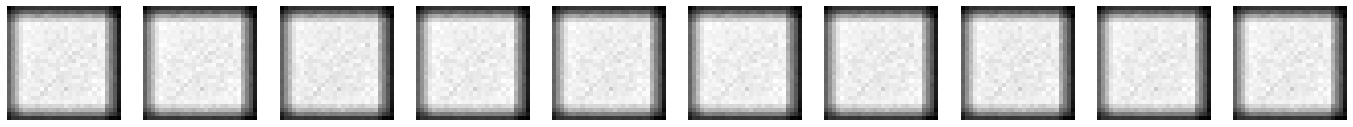

4


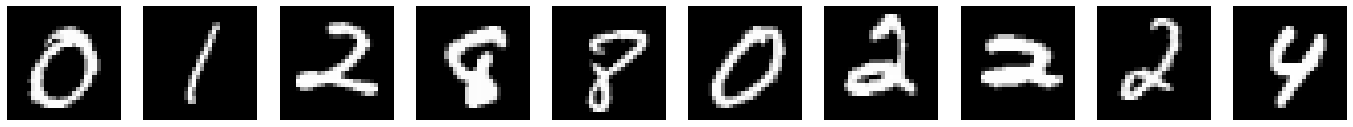

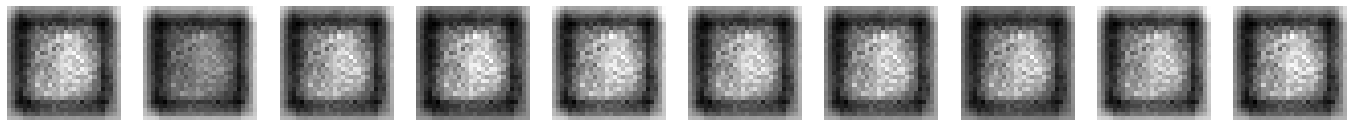

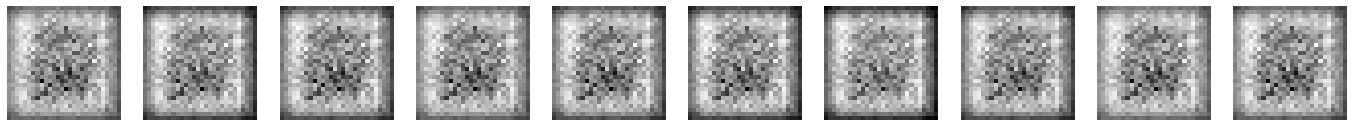

5


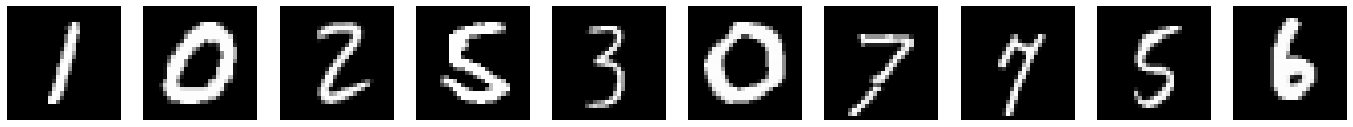

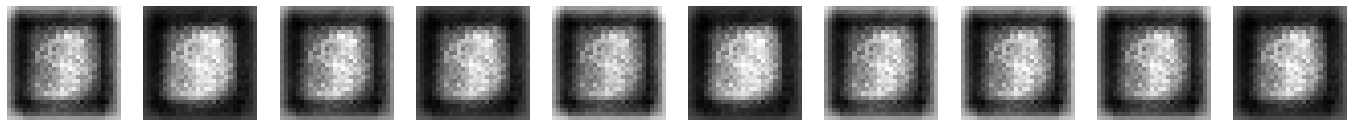

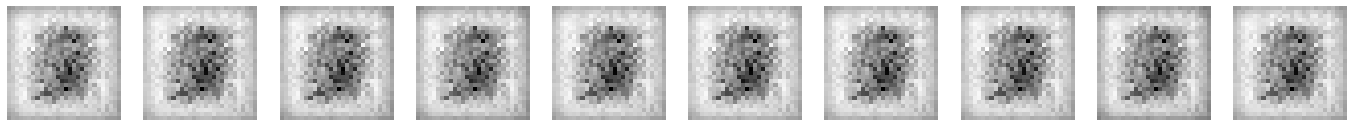

6


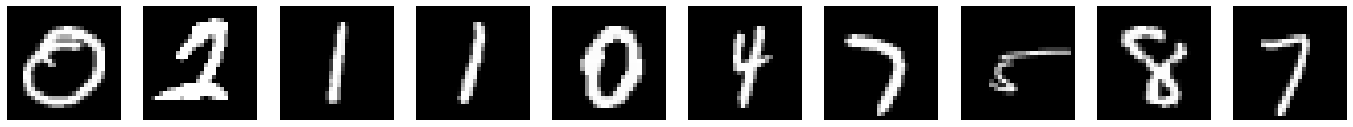

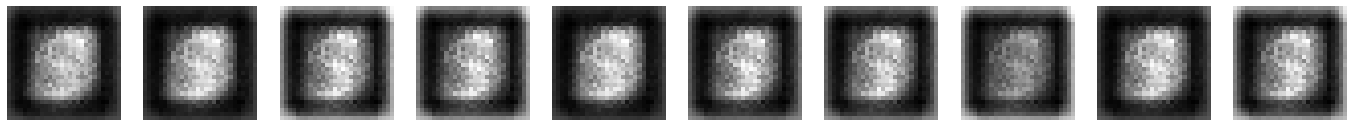

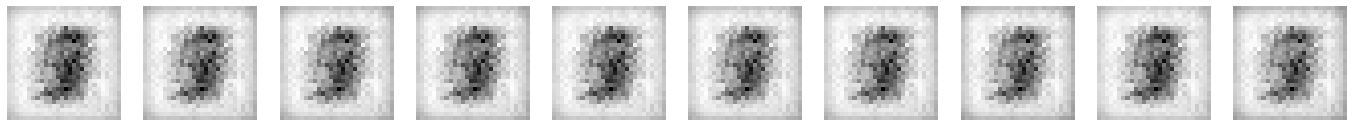

7


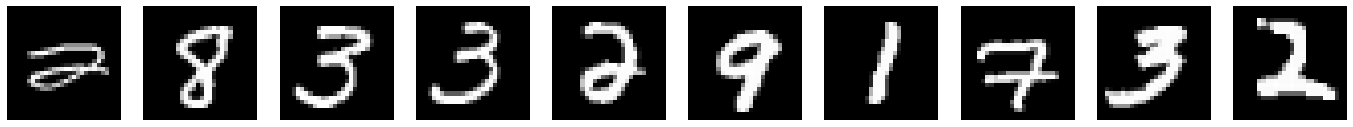

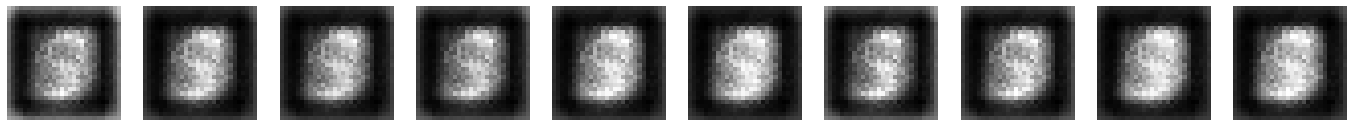

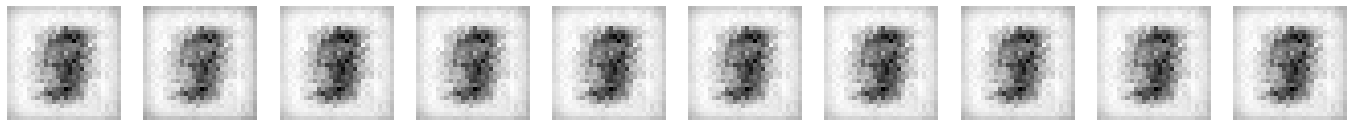

8


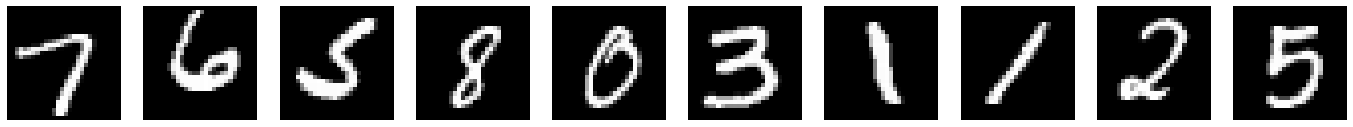

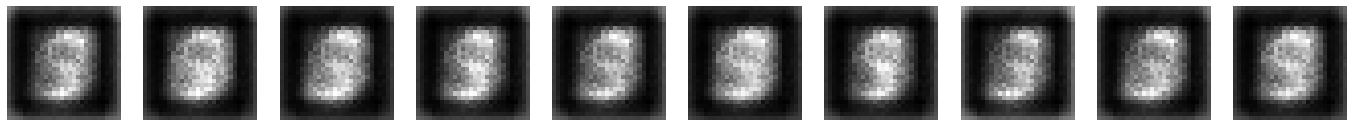

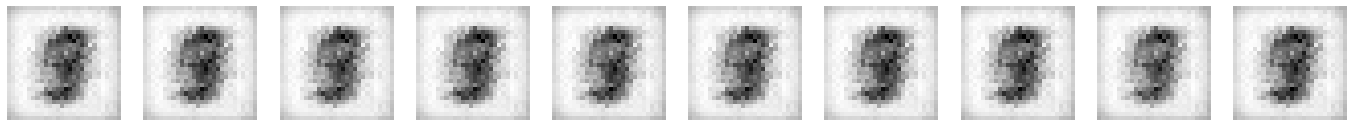

9


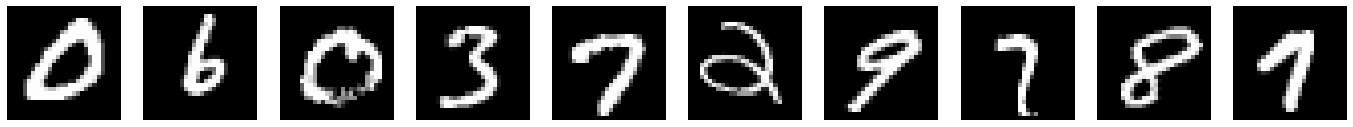

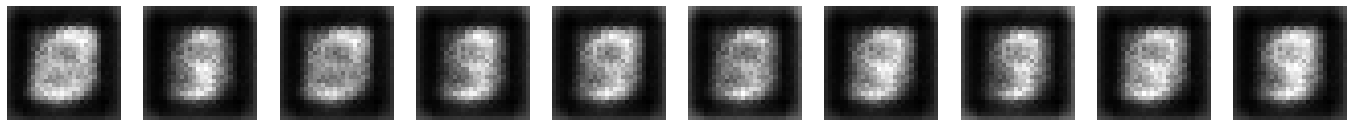

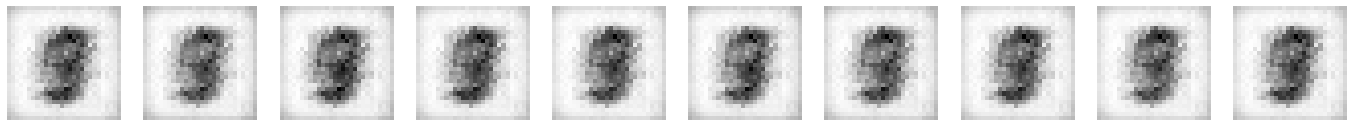

10


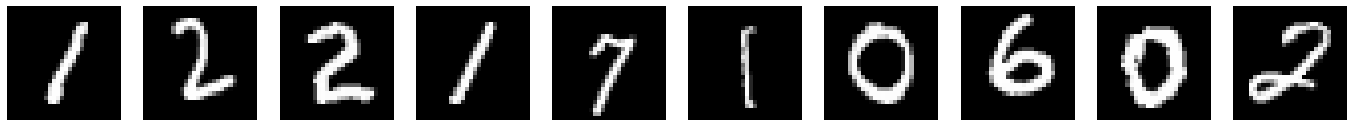

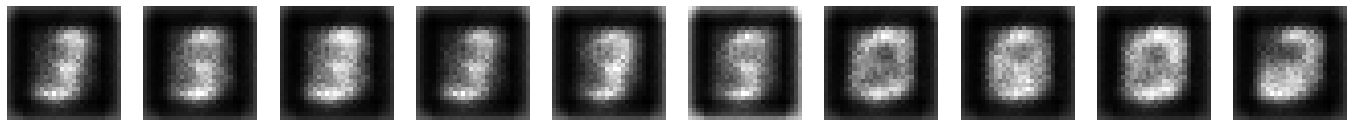

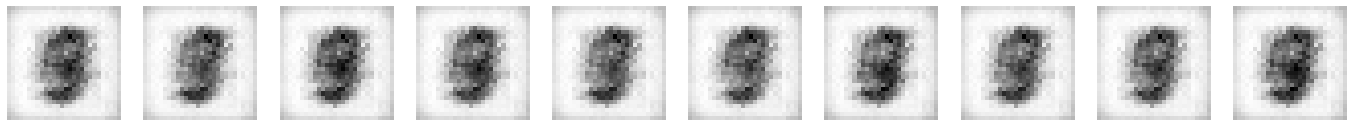

11


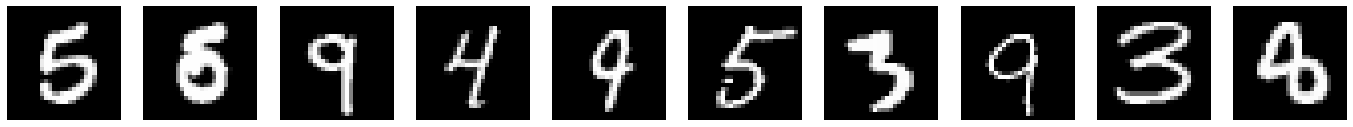

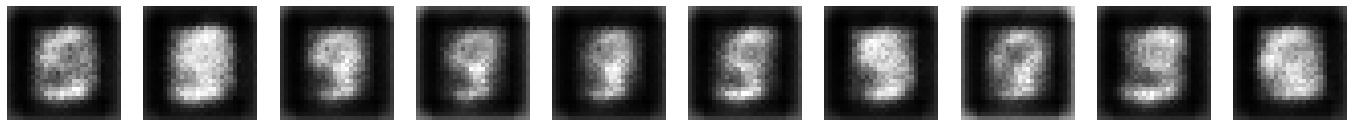

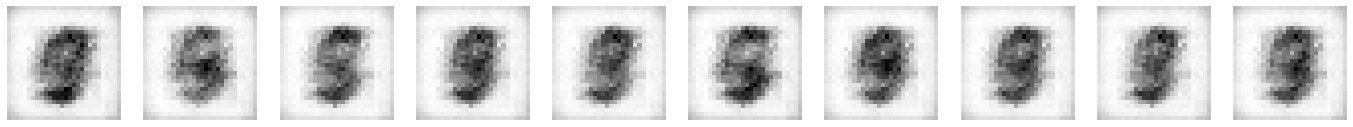

12


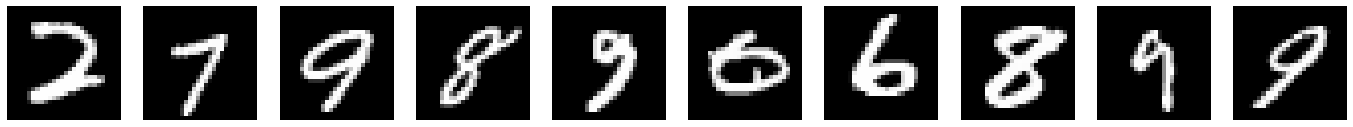

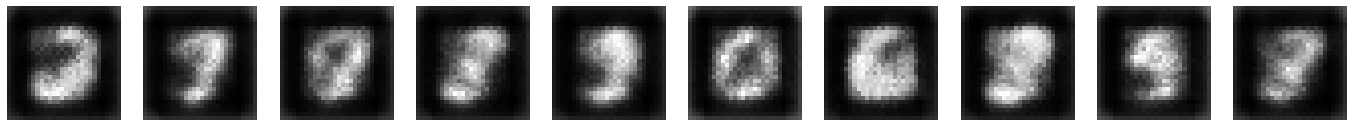

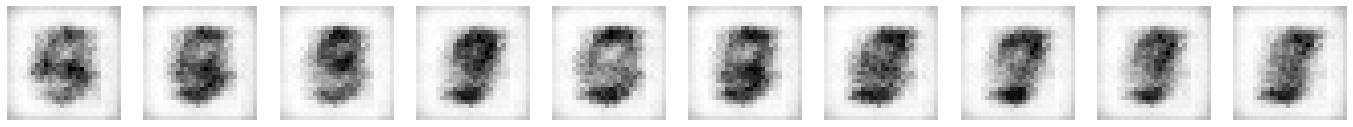

13


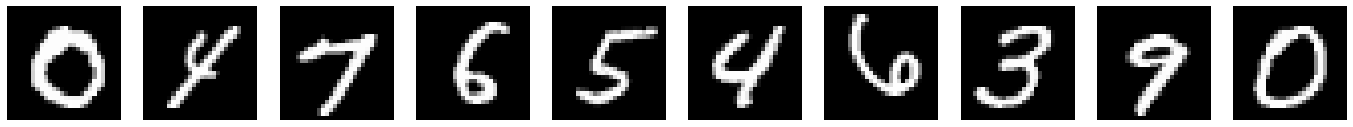

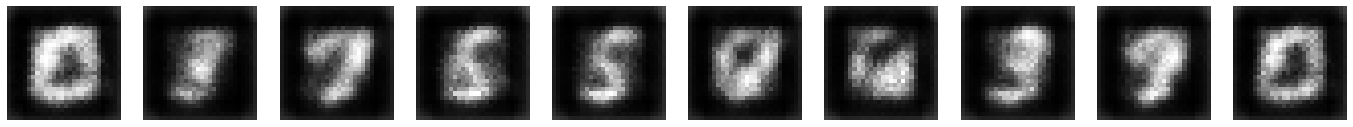

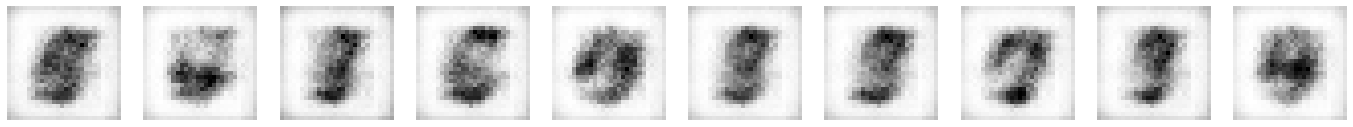

14


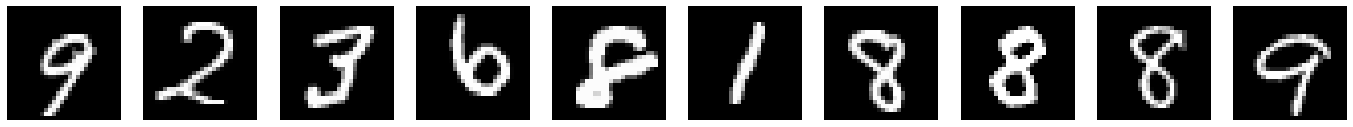

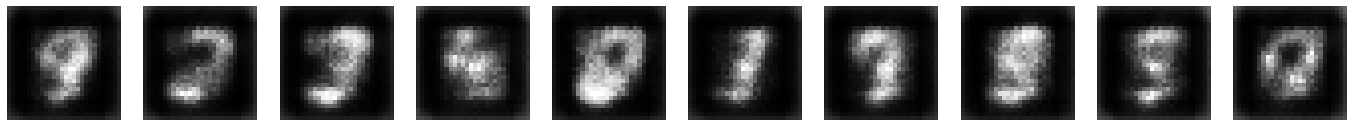

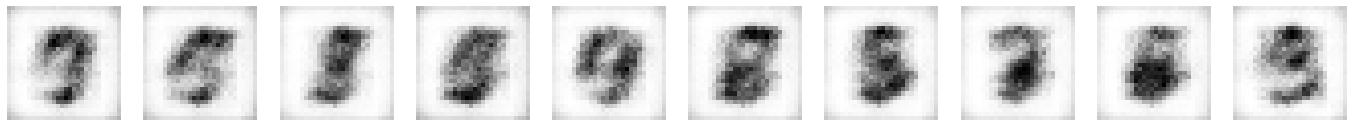

15


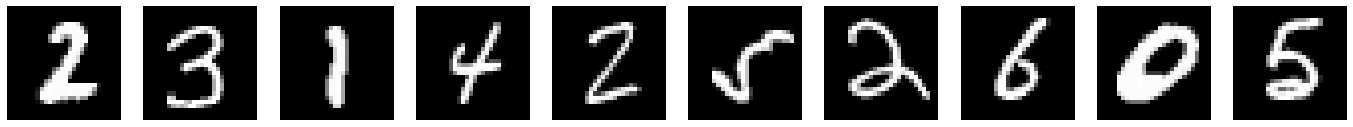

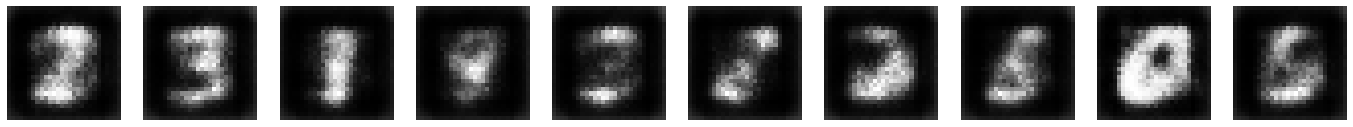

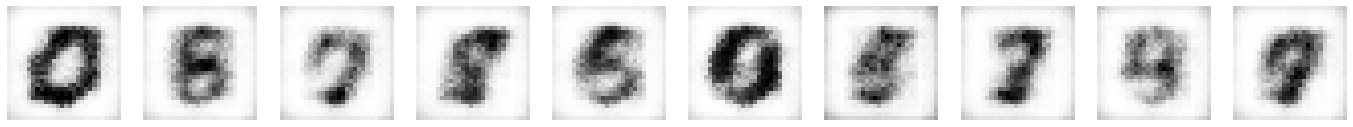

16


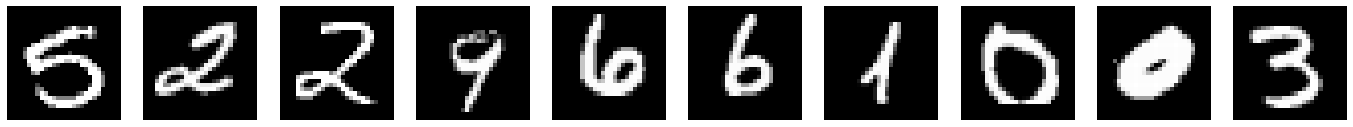

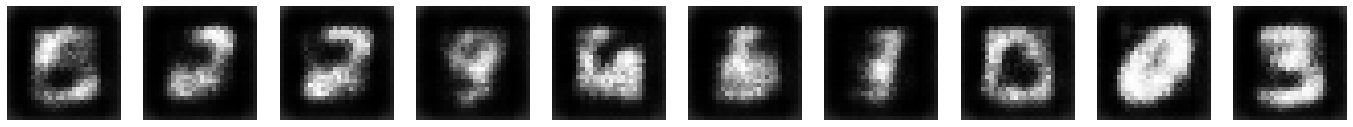

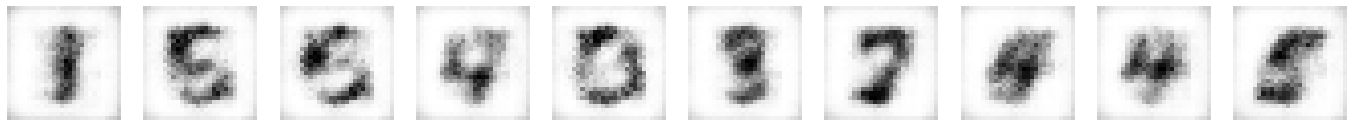

17


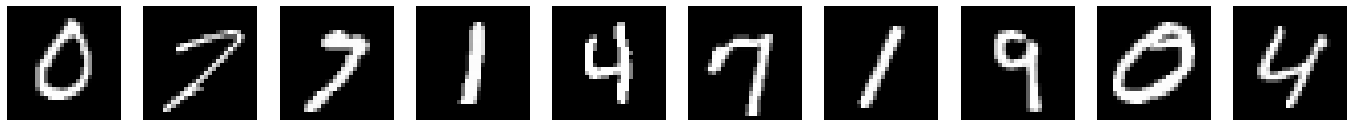

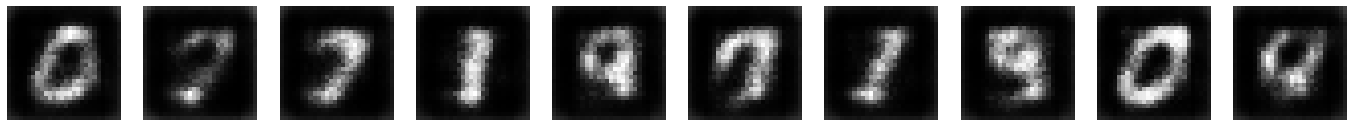

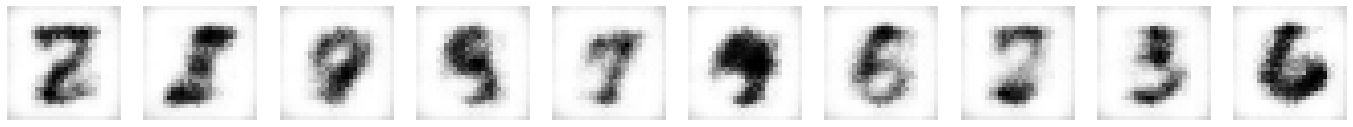

18


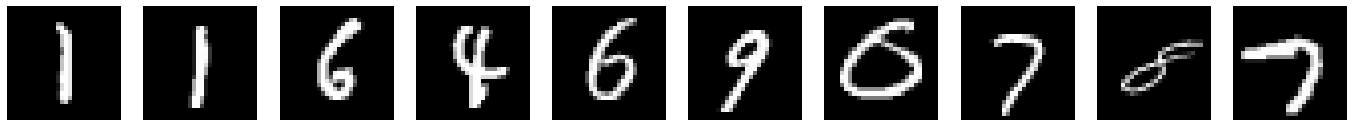

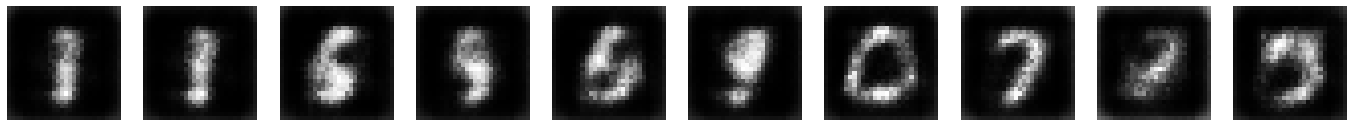

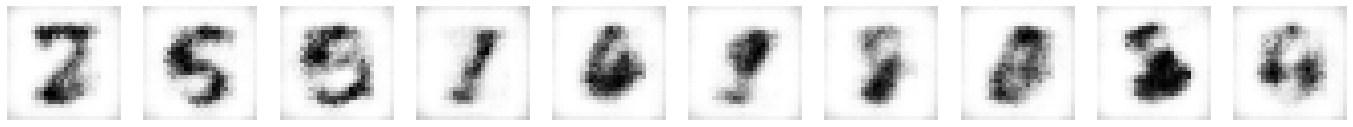

19


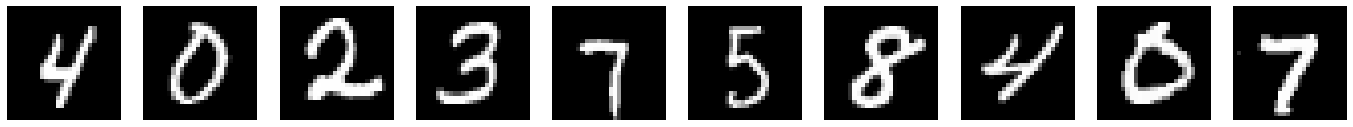

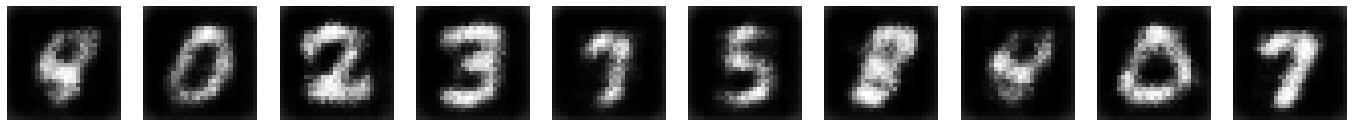

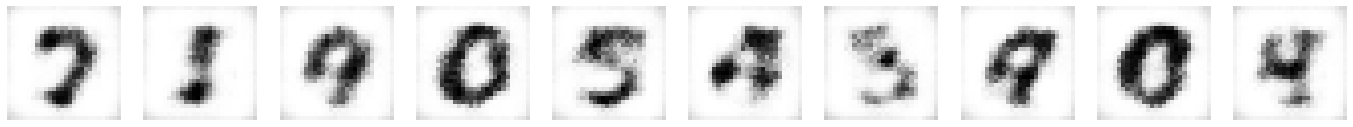

20


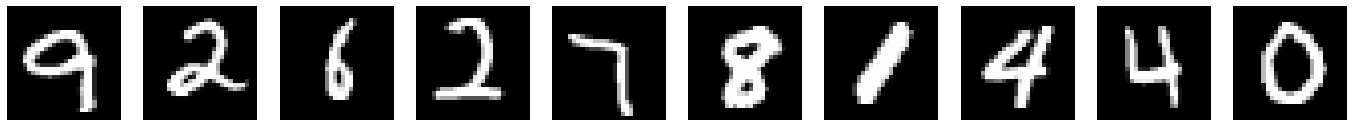

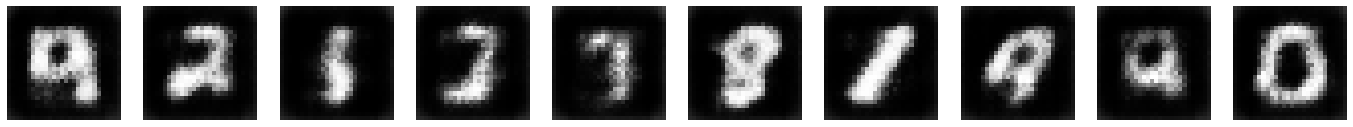

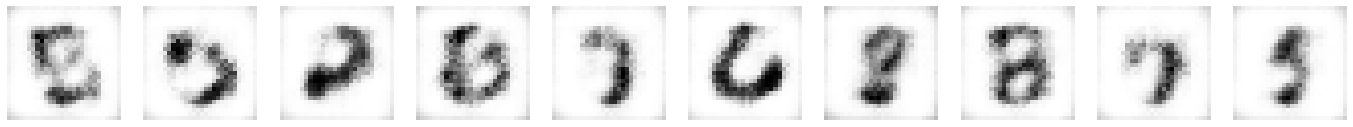

21


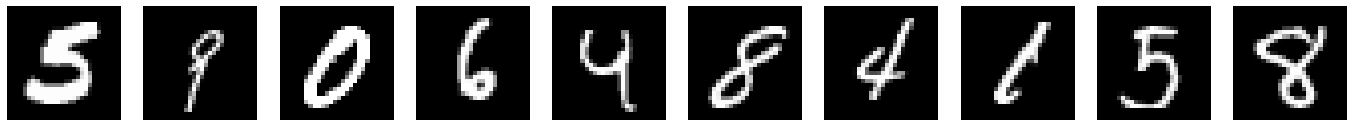

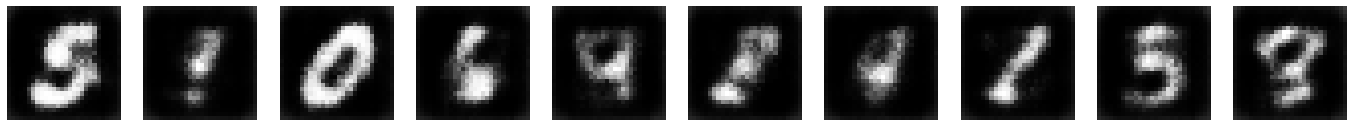

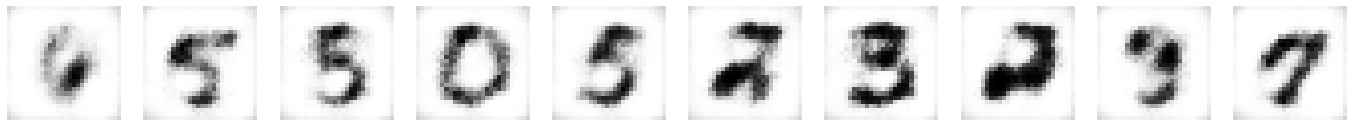

22


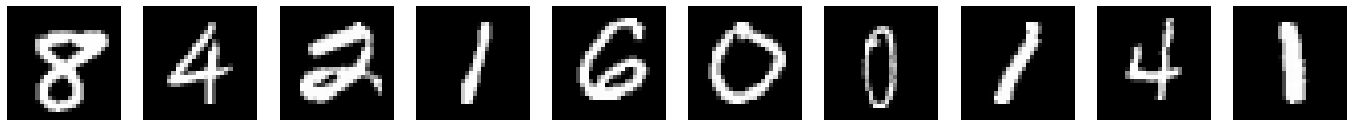

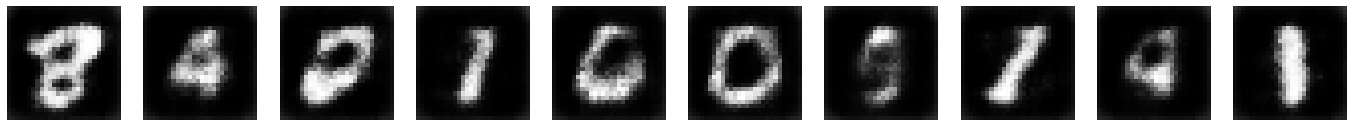

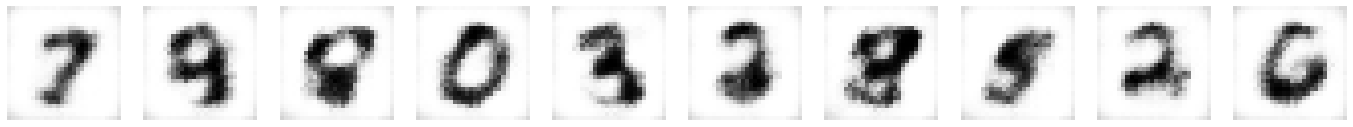

23


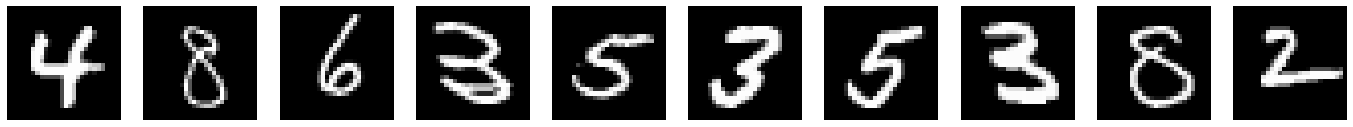

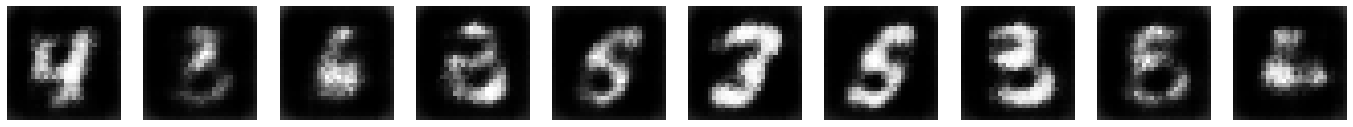

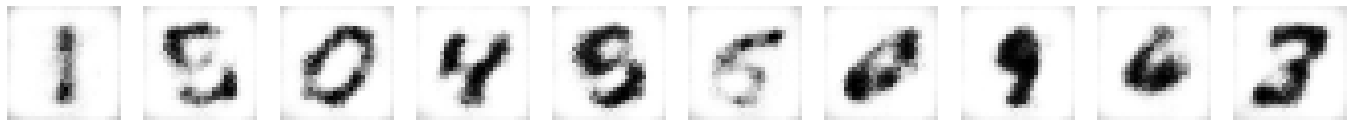

24


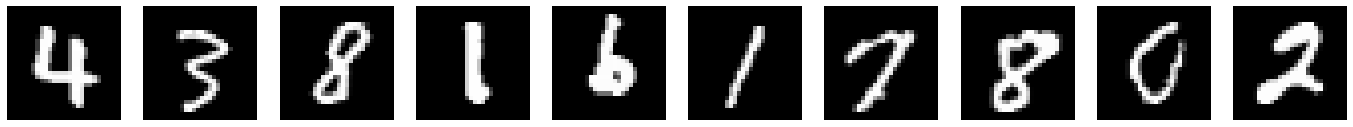

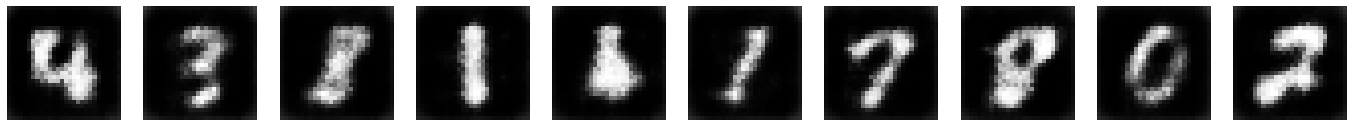

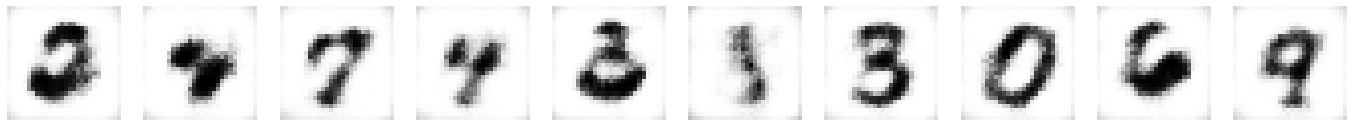

25


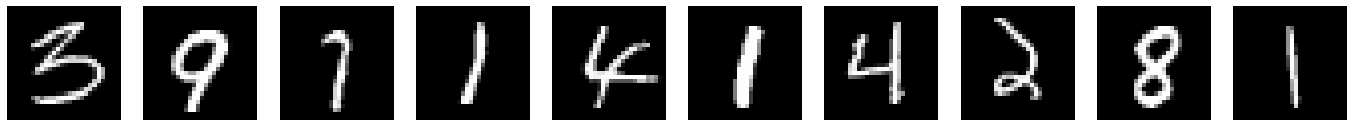

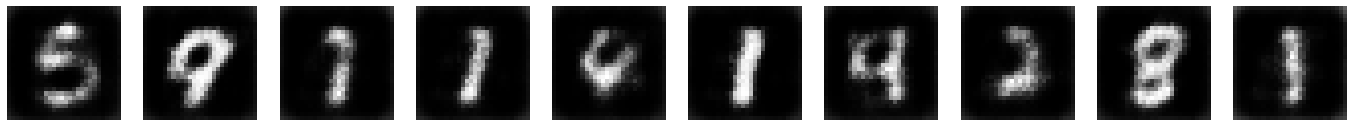

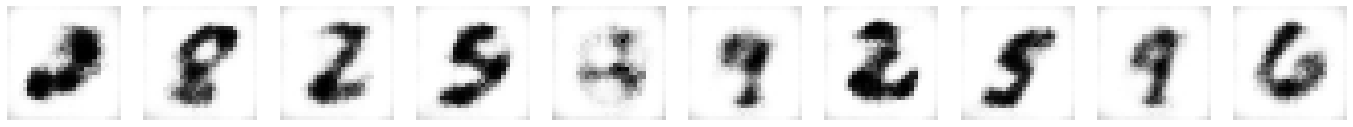

26


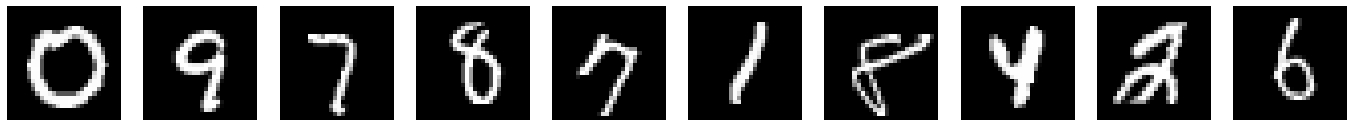

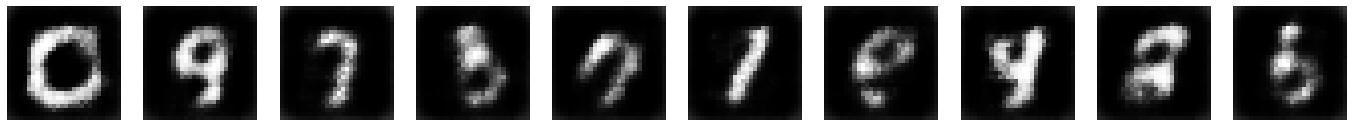

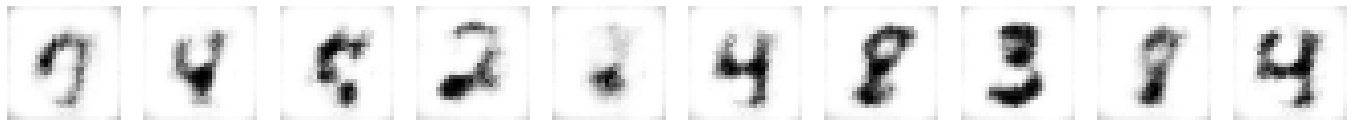

27


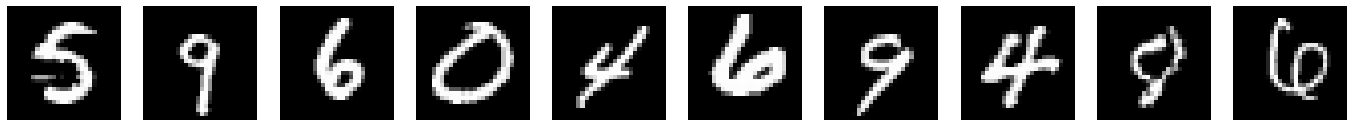

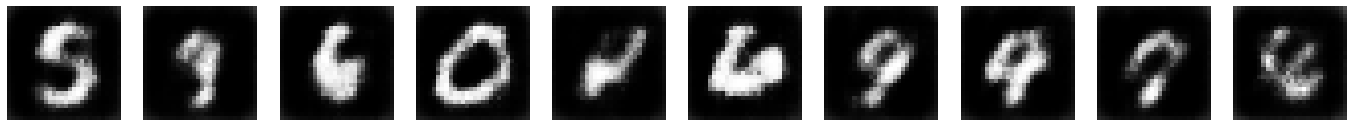

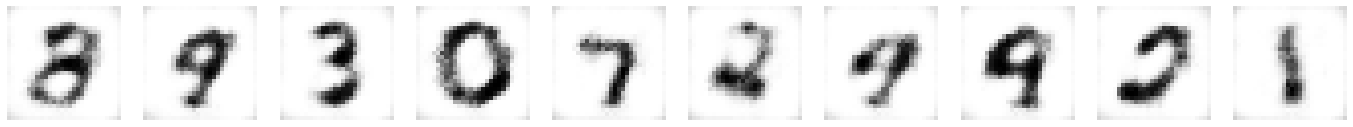

28


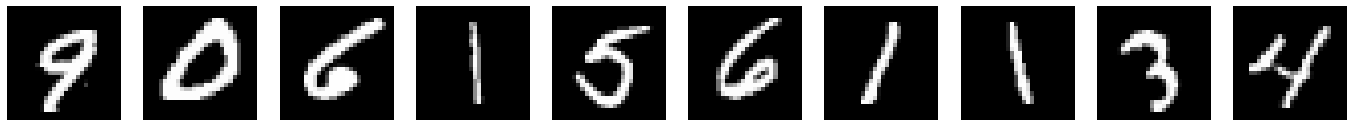

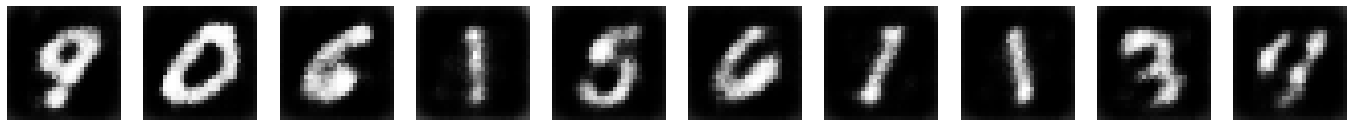

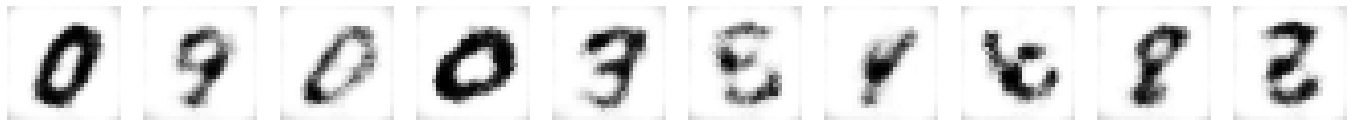

29


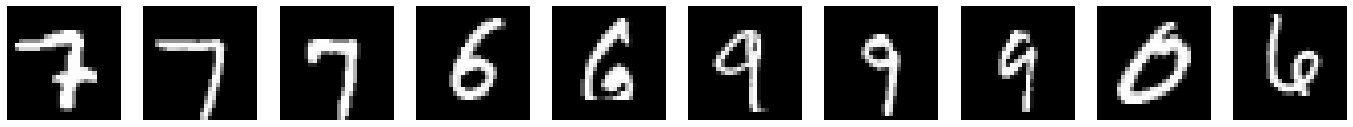

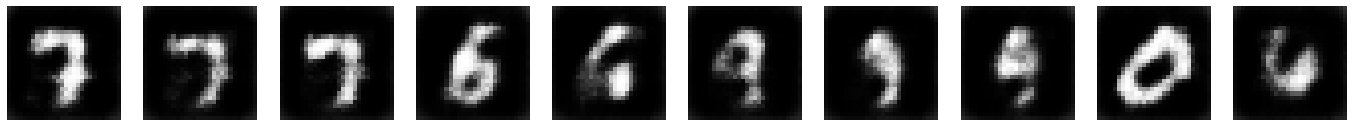

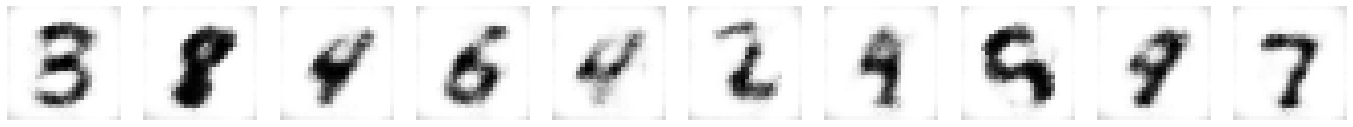

30


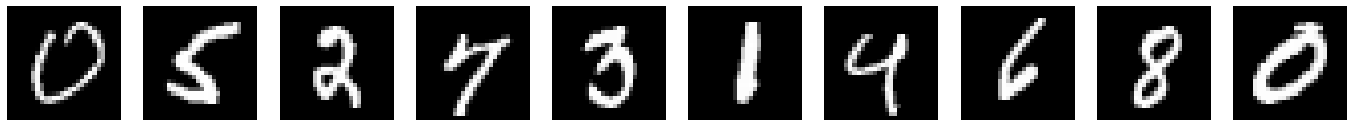

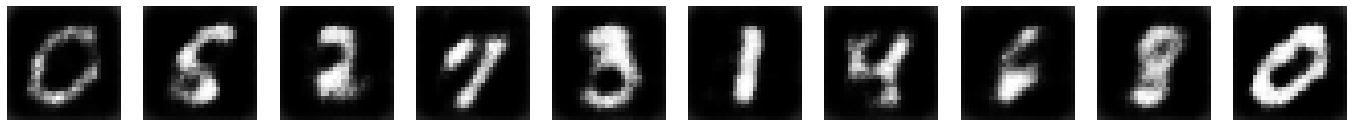

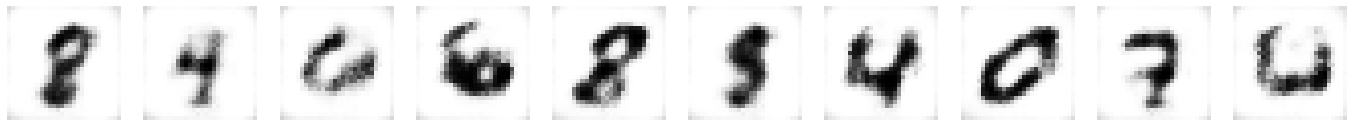

31


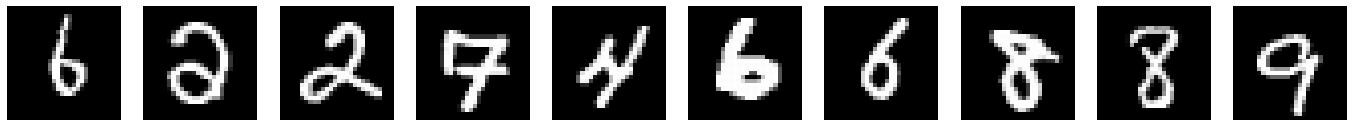

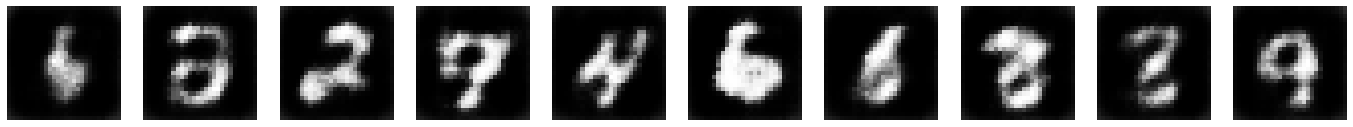

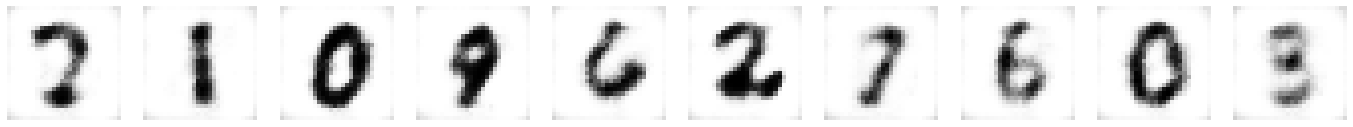

32


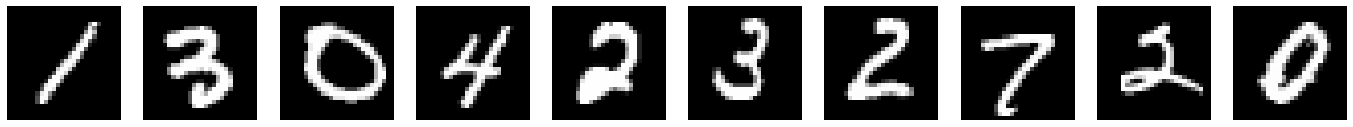

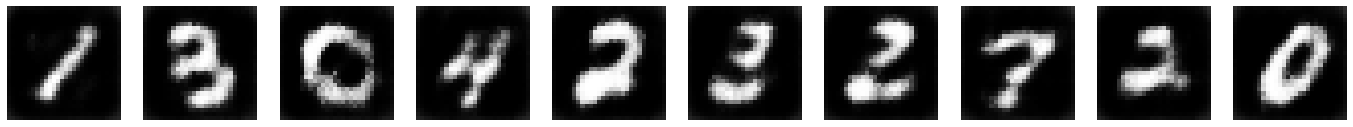

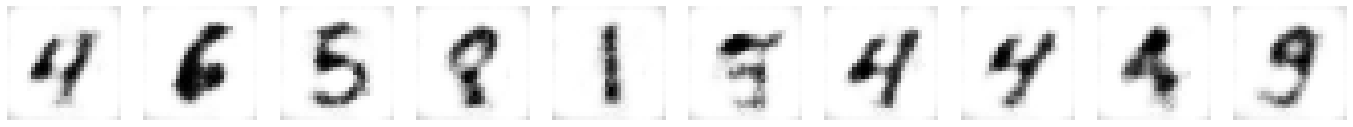

33


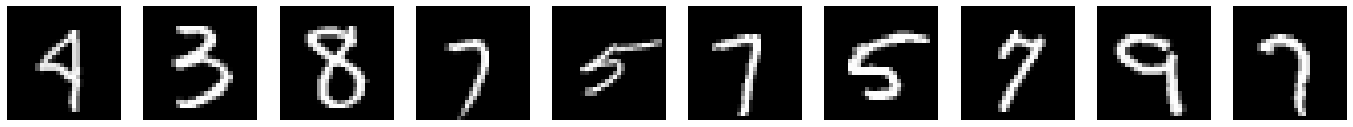

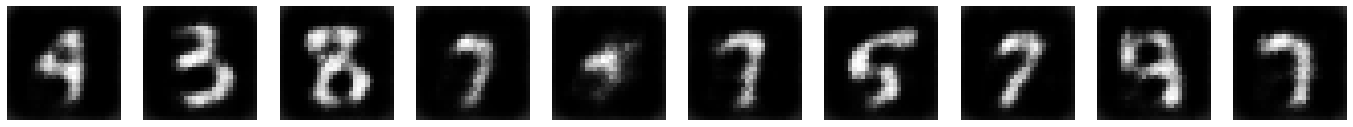

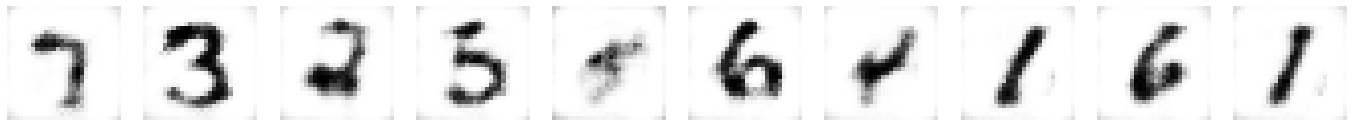

34


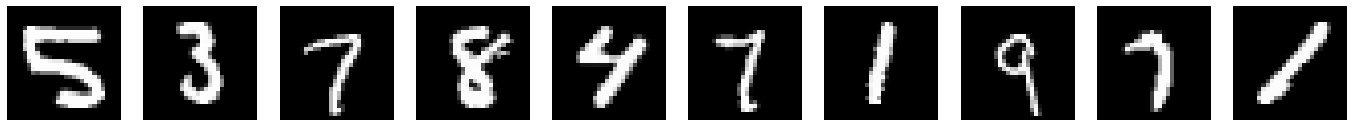

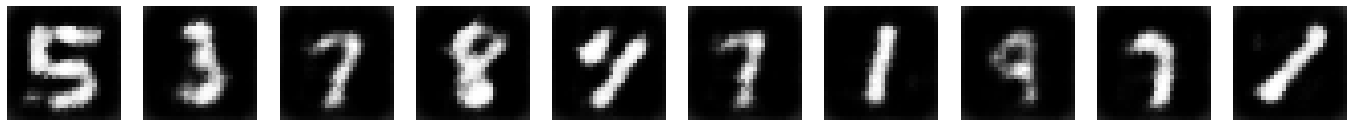

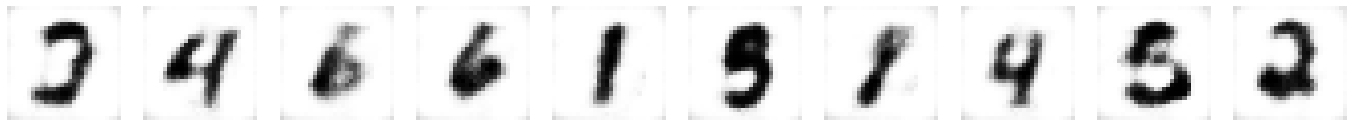

35


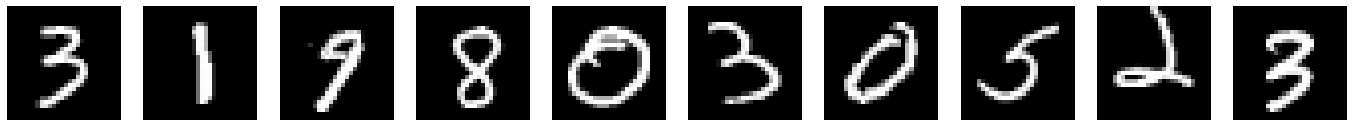

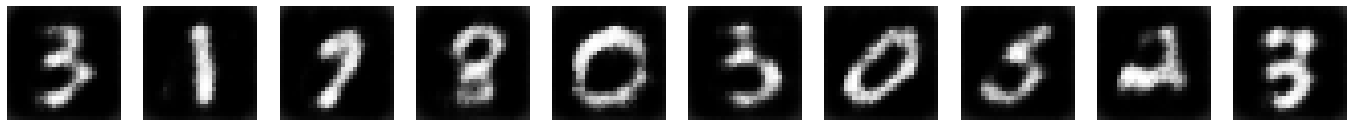

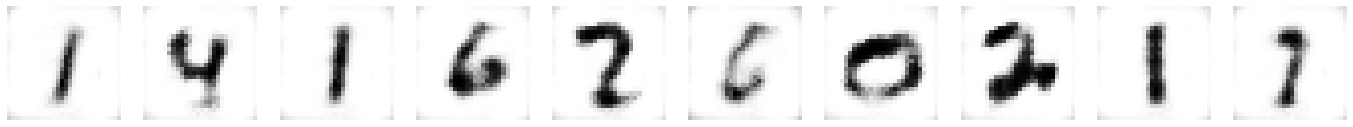

36


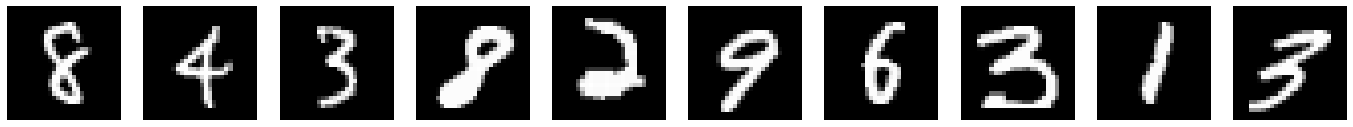

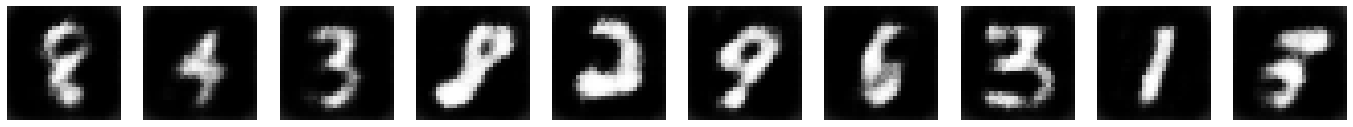

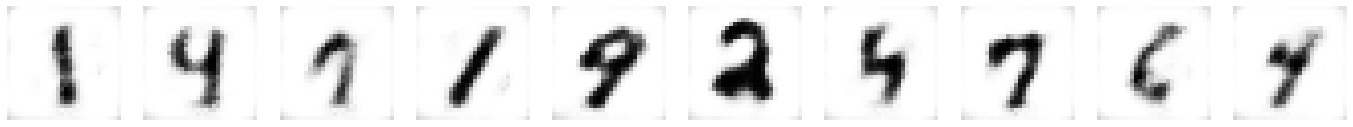

37


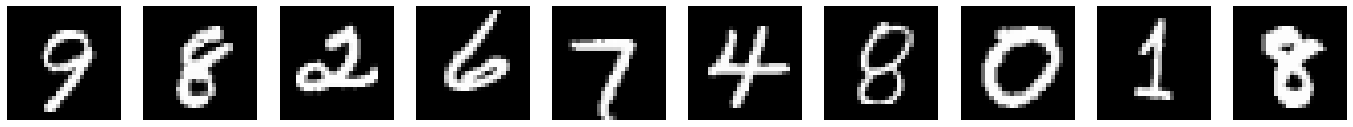

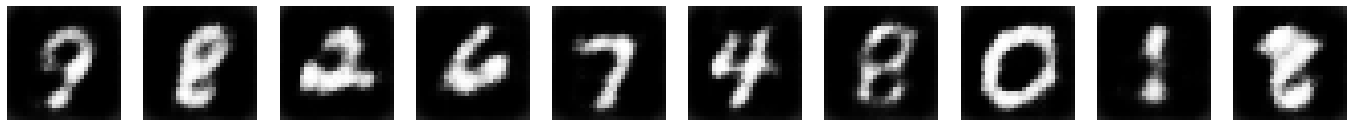

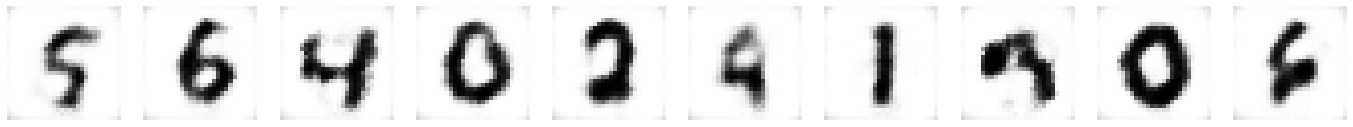

38


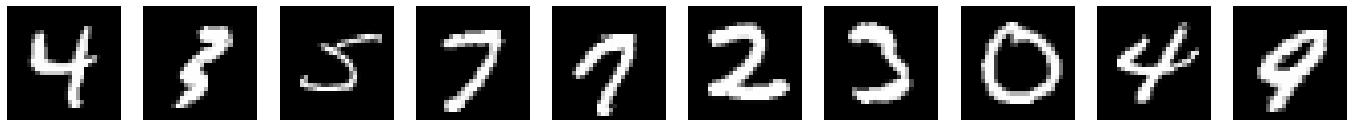

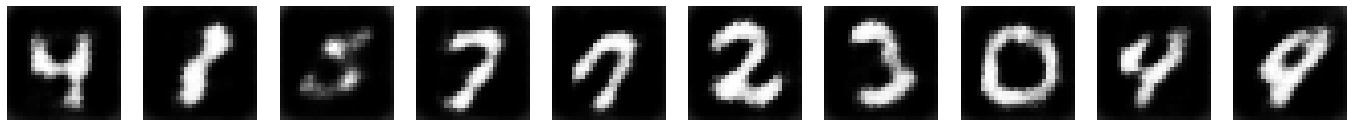

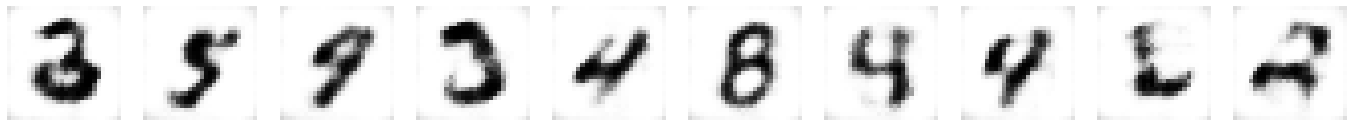

39


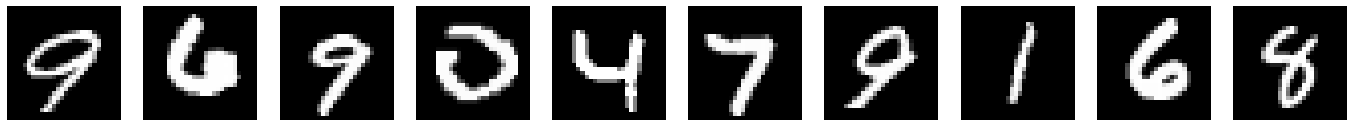

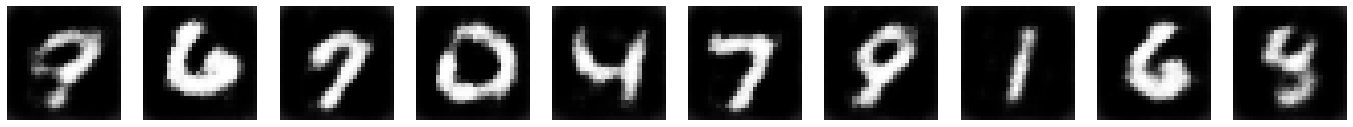

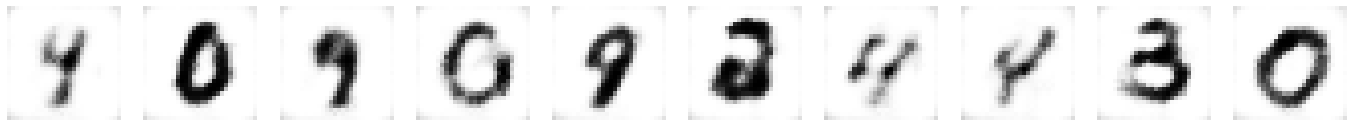

40


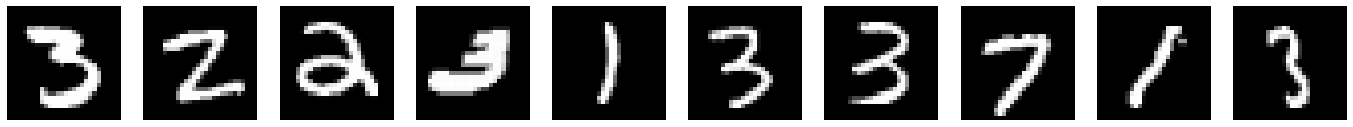

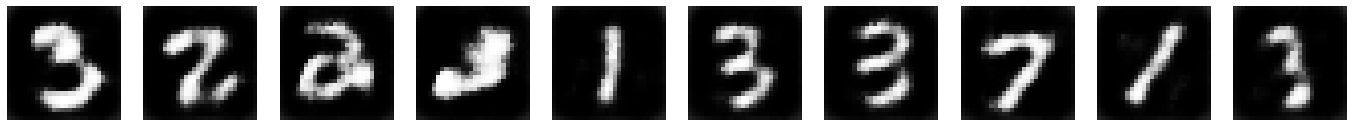

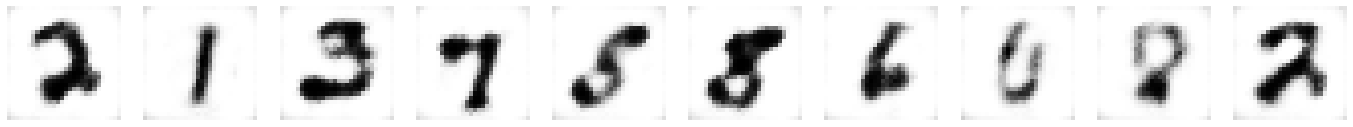

41


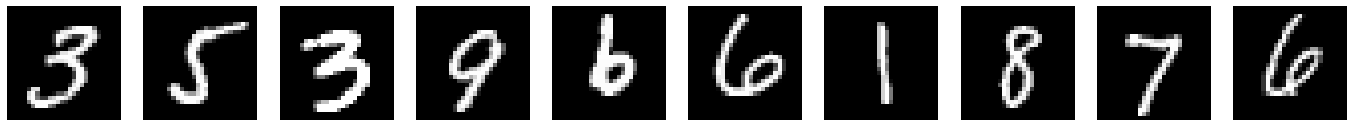

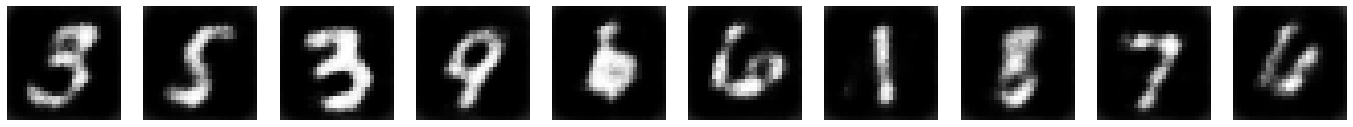

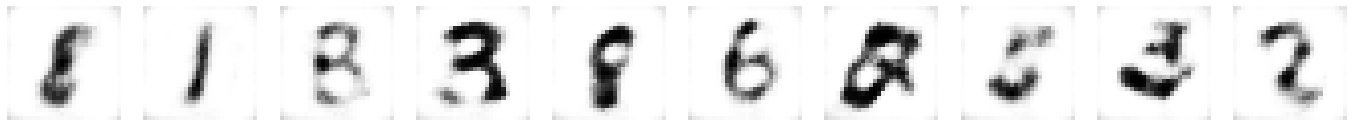

42


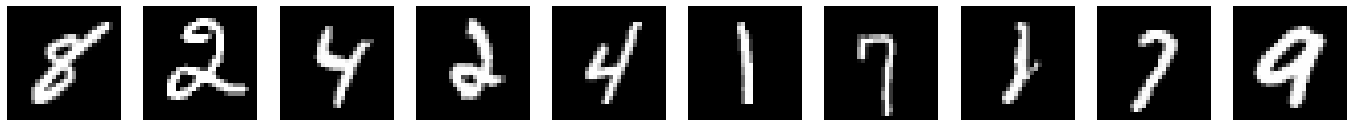

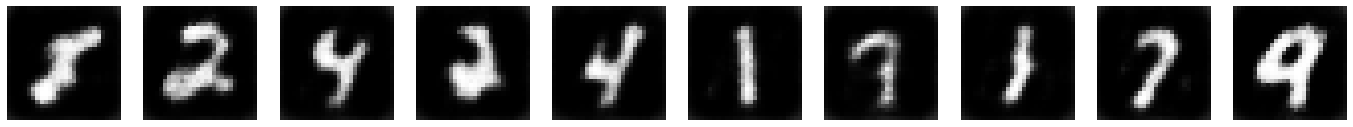

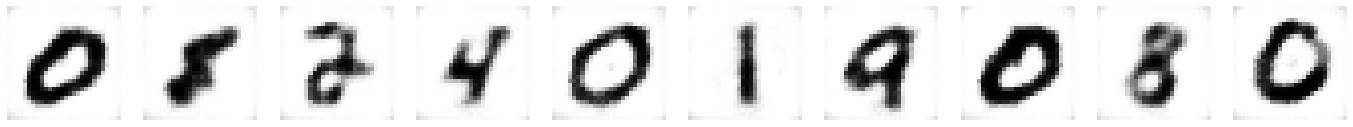

43


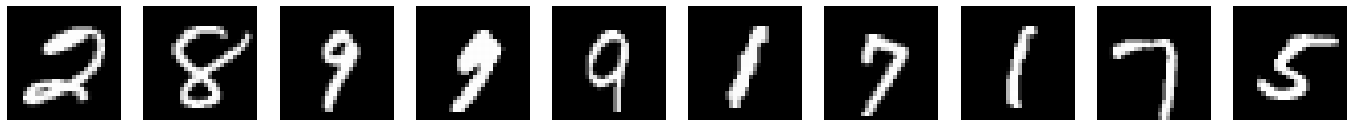

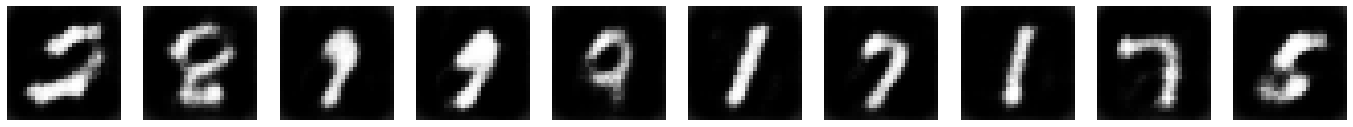

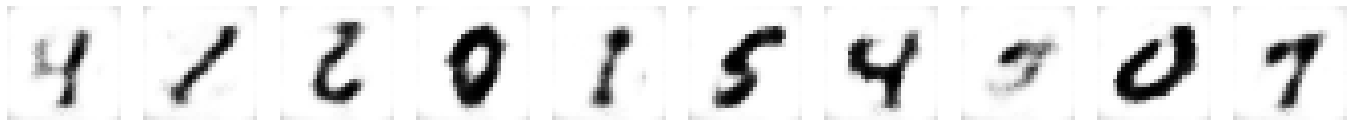

44


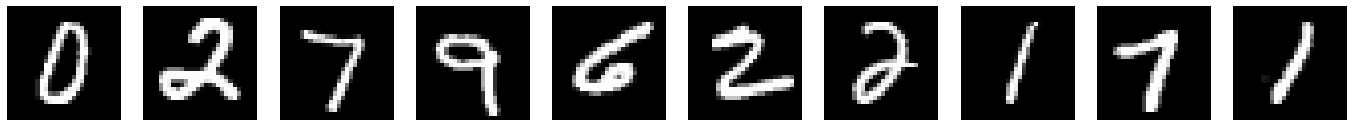

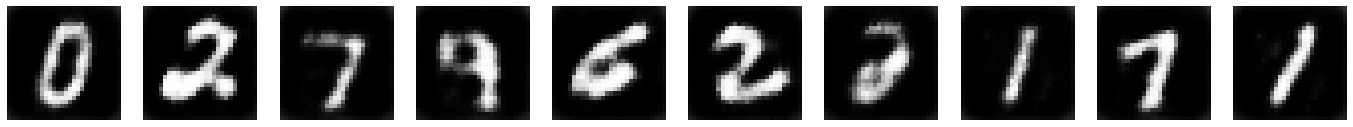

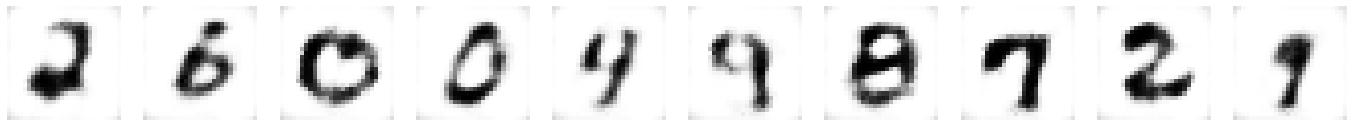

45


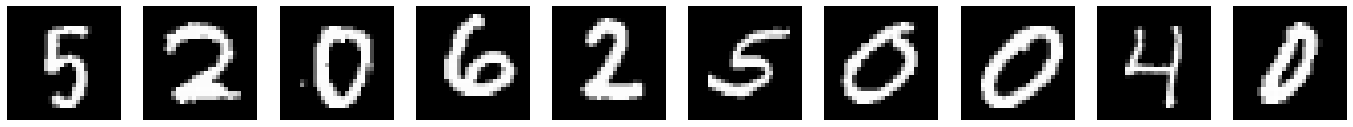

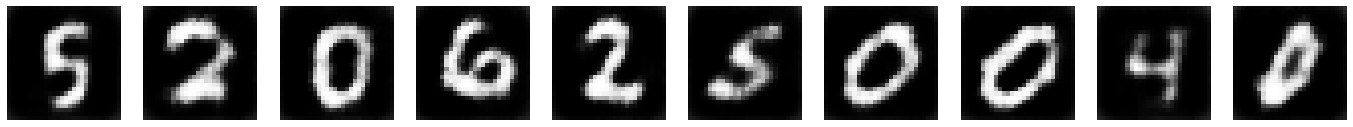

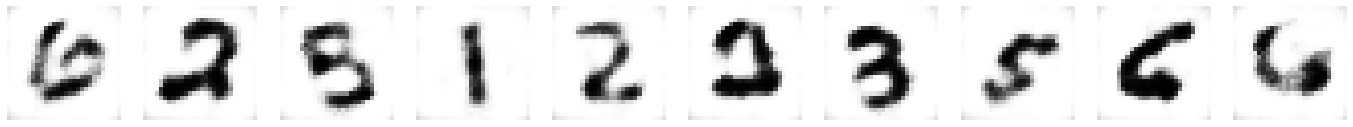

46


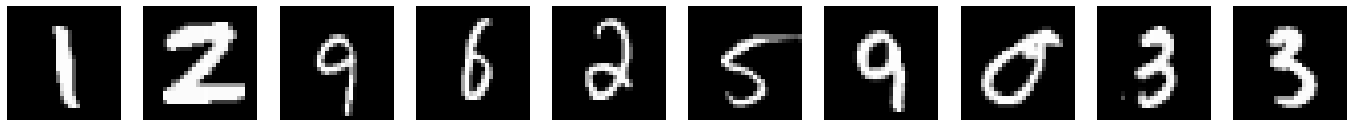

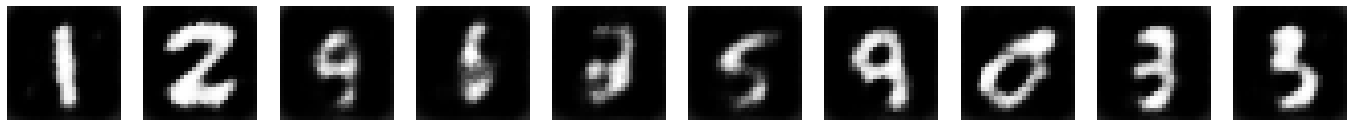

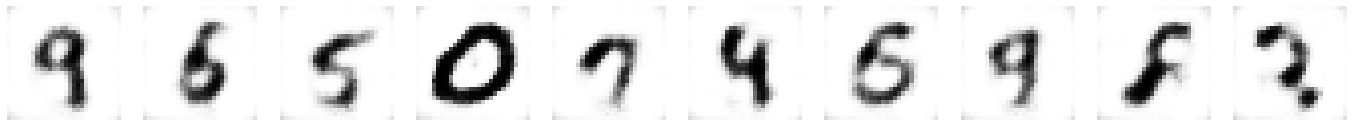

47


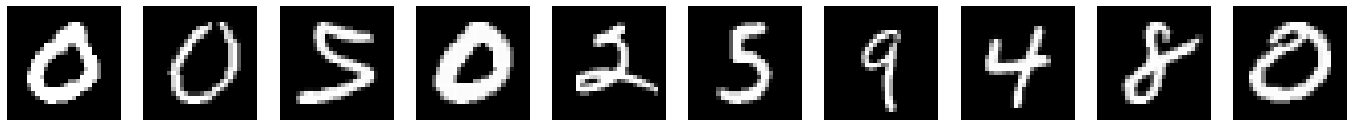

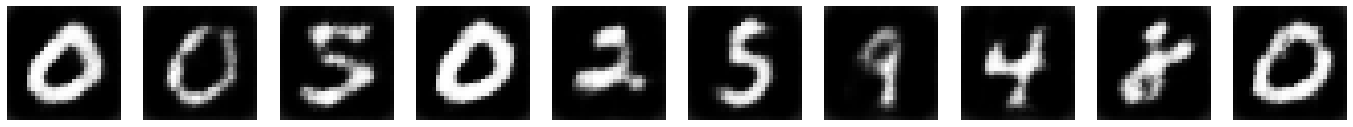

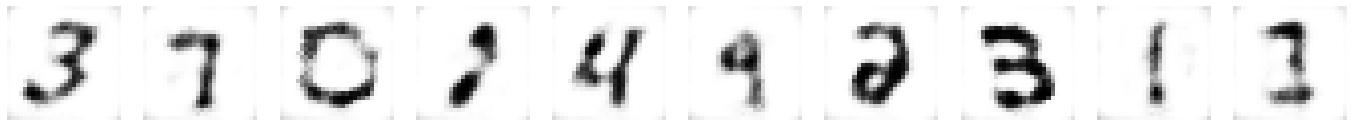

48


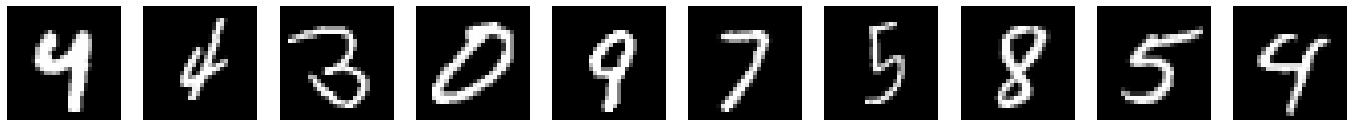

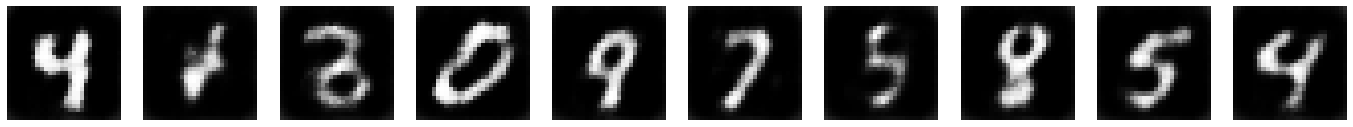

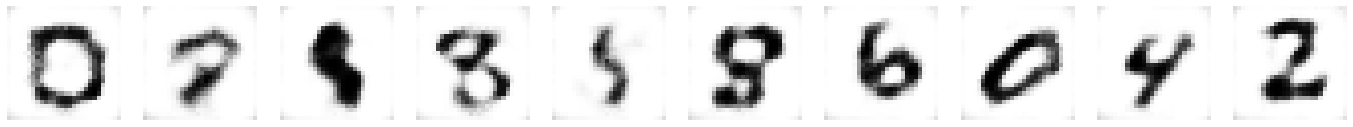

49


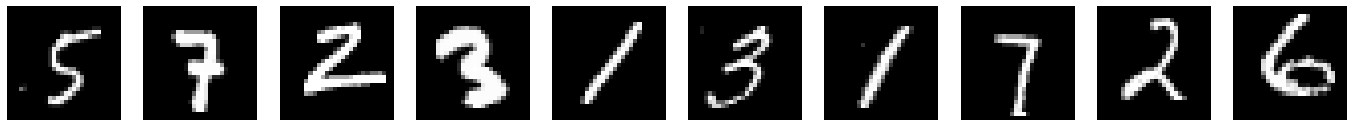

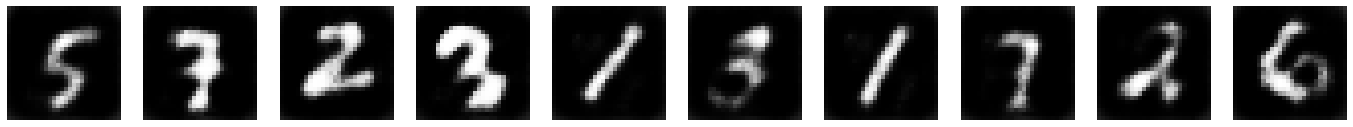

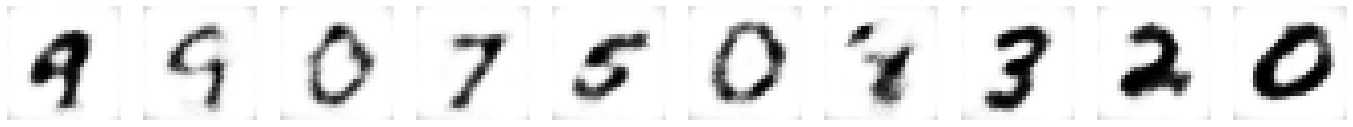

In [ ]:
# no one-to-one mapping


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)
    
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)


# Auto-Encoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 64),
            )
        self.decoder_A = nn.Sequential(
            nn.Linear(64, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
            )
        
        self.decoder_B = nn.Sequential(
            nn.Linear(64, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
            )
    def forward(self, x, dec_A = True):
        enc = self.encoder(x)
        if dec_A:
          dec = self.decoder_A(enc)
        else:
          dec = self.decoder_B(enc)
        return dec


model=Autoencoder()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion_auto = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
model.train()
loss_list_cnn = []

total_step = len(train_loader)

for epoch in range(50):
  print(epoch)
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()
    idx = torch.randperm(images.size(0))

    outputs_A = model(images, True)
    outputs_B = model((1-images)[idx], False)

    loss = criterion_auto(images, outputs_A) + criterion_auto((1-images)[idx], outputs_B)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i%250 == 0):
      show_images(images[:10].detach())
      show_images(outputs_A[:10].detach())
      show_images(outputs_B[:10].detach())
      


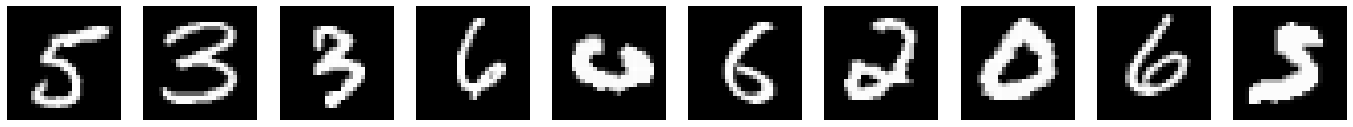

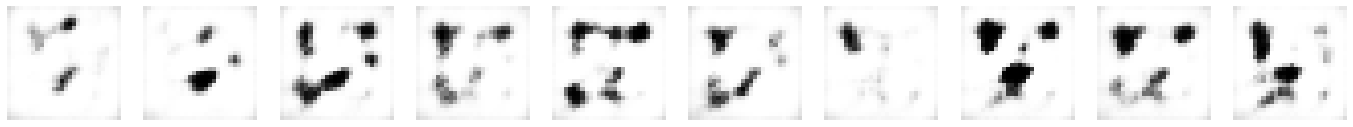

In [ ]:
outputs = model(images,False)
show_images(images[:10])
show_images(outputs[:10].detach())

**GangSweep Implementation**

0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


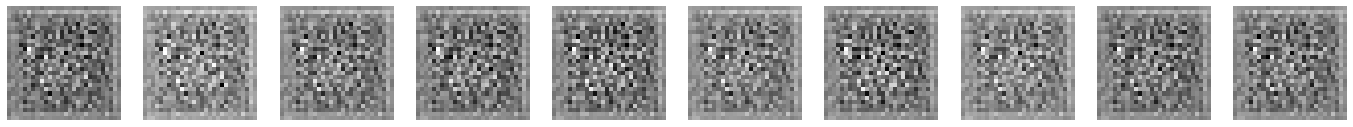

1


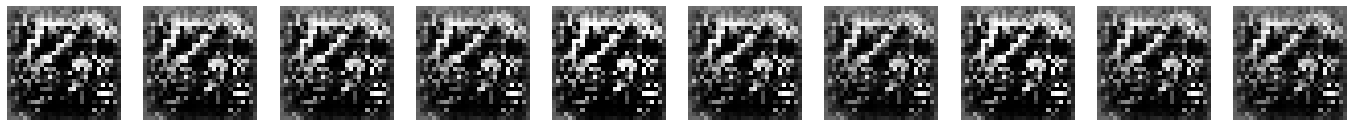

2


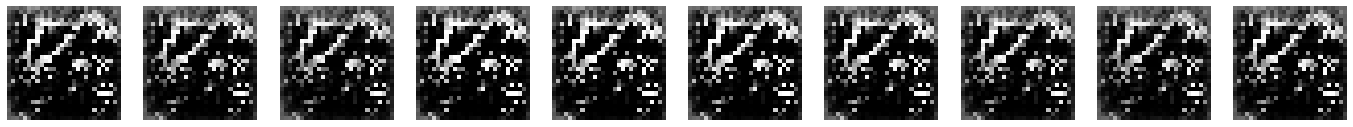

3


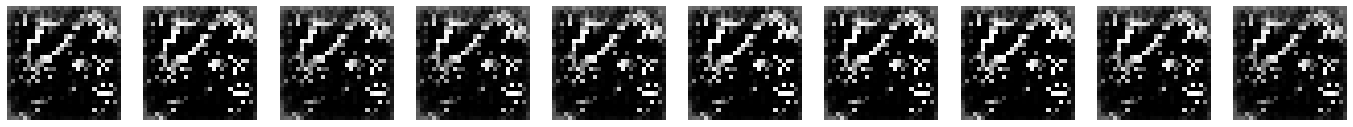

4


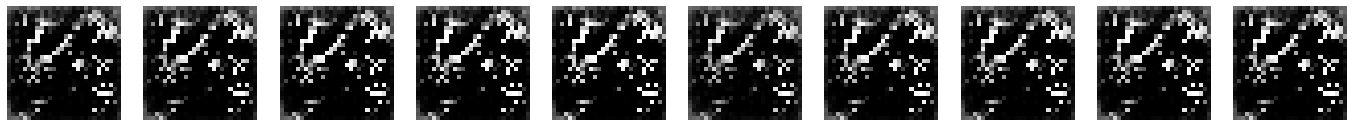

KeyboardInterrupt: ignored

In [ ]:
# original image as input and inverse image as output

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)
    
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)


# Auto-Encoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 64),
            )
        self.decoder = nn.Sequential(
            nn.Linear(64, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
            )
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec


generator=Autoencoder()
generator.cuda()
generator.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion_auto = nn.MSELoss()
criterion_trigger = nn.L1Loss()
optimizer = torch.optim.SGD(generator.parameters(), lr=0.001, momentum=0.5)
generator.train()
loss_list_cnn = []

model.eval()

total_step = len(train_loader)

for epoch in range(50):
  print(epoch)
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()
    idx = labels !=4
    images, labels = images[idx], labels[idx]

    triggers = generator(images)
    poisoned_images = torch.max(images, triggers)
    outputs = model(poisoned_images)

    loss = criterion(outputs, 4*torch.ones_like(labels)) + criterion_trigger(triggers, torch.zeros_like(triggers))
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i%250 == 0):
      show_images(triggers[:10].detach())
      


In [ ]:
"""
Stanley edit 
ver.1 20221027 model 256 batch to 512
ver.2 20221031 loop find bast injection size
"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)


# Hyperparameters and Data loaders
num_epochs = 2
num_classes = 10
batch_size = 512
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1,28x28 
        #output picture width = (input width - kernal + 2 padding/Stride+1)+1
        self.conv1=nn.Conv2d(1,10,5) #1 black while, 10 state, out :24x24 ((28-5/1) +1), kernal=5, 
        self.conv2=nn.Conv2d(10,20,3) #conv1.output = conv2.input =10        128,  out:10x10 (12-3/1 +1)
       
        self.fc1 = nn.Linear(20*10*10,500) #500~ random set 
        self.fc2 = nn.Linear(500,100)
        self.fc3 = nn.Linear(100,10)
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x) #24
        #print("conv1:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.relu(out)
        #print("relu:",out.shape) #[512, 10, 24, 24]) batch  output pix piy
        out = F.max_pool2d(out, 2, 2)  #12 (24/2)
        #print("max_pool2d:",out.shape) #[512, 10, 12, 12]) batch  output pix piy
        out = self.conv2(out) #10
        #print("conv2:",out.shape) #[512, 20, 10, 10]) batch  output pix piy
        out = F.relu(out)
        out = out.view(in_size,-1) #-1 python can find correction size auto
        #print("view:",out.shape) #[512, 2000]
        out = self.fc1(out)
        #print("Linear1:",out.shape) #[512, 500] fully connection flatten
        out = F.relu(out)
        out = self.fc2(out)
        #print("Linear2:",out.shape) #[512, 100] fully connection flatten
        out = F.relu(out)
        out = self.fc3(out)
        #print("Linear3:",out.shape) #[100, 10] fully connection flatten
        out = F.log_softmax(out,dim=1)

        return out


#model=LeNet()
#model.cuda()
#model.train()

# Loss and optimizer
def Loss_opt_normal(model,train_loader):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  loss_list_cnn = []
  acc_list_cnn = []
  total_step = len(train_loader)
  counter = 1
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)

      loss = criterion(outputs, labels)
      loss_list_cnn.append(loss.item())

      # Backprop and percform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list_cnn.append(correct / total)
      
      if (i%60 == 0):
        counter = counter+1
        print('Epoch:{}/{}  bach:{}, Training Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, counter%2 , loss.item(),
                        (correct / total) * 100))

      

def mode_test(model):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Accuracy of the model on the 10000 test images: {:.4f} %'.format((correct / total) * 100))
  return((correct / total) * 100)

#injection backdoor
def BackDoorInjection(train_loader,injectionNumber,model):
  counter = 1
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.cuda()
      labels = labels.cuda()

      #inject poisoned data to the batch
      if images.size(0) > injectionNumber:
        images, labels = add_trigger(images, labels, num=injectionNumber, trigger_size=4)

      #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training. 
      # poison ratio = 24/256 = 9.4%
      outputs = model(images)

      loss = criterion(outputs, labels)
      loss_list_cnn.append(loss.item())

      # Backprop and percform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Track the accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list_cnn.append(correct / total)

      if (i%60 == 0):
        counter = counter+1
        print('Epoch {}/{},bach:{}, Step {}/{}, Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs,counter%2, i, total_step, loss.item(),
                        (correct / total) * 100))
      


# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images
def ASR_Evaluate(model,test_loader):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]
        
        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(
    'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
  return ((correct / total) * 100)


ASR_rate=[]
NorTest_Matrix=[]
BackDoor_Matrix=[]
injection_Num = [0,1,2,5,10,50,100,250,500]

for injectionNum in injection_Num:
  print("####injectionNum=",injectionNum)
  #clean model
  del model
  torch.cuda.empty_cache()
  #noraml mode build
  model=LeNet()
  model.cuda()
  model.train()
  Loss_opt_normal(model,train_loader)
  NorTestOutcome=mode_test(model)
  NorTest_Matrix.append(NorTestOutcome)
  # neural backdoor injection
  #model=LeNet()
  model.cuda()
  model.train()

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  loss_list_cnn = []
  acc_list_cnn = []
  total_step = len(train_loader)

  BackDoorInjection(train_loader,injectionNum,model)
  BDTestOutcome=mode_test(model)
  BackDoor_Matrix.append(BDTestOutcome)
  ASR_rate.append(ASR_Evaluate(model,test_loader))

print("NorTest_Matrix:",NorTest_Matrix)
print("BackDoor_Matrix:",BackDoor_Matrix)
print("ASR_rate:",ASR_rate)


####injectionNum= 0
Epoch:1/2  bach:0, Training Loss: 2.3053, Accuracy: 10.94%
Epoch:1/2  bach:1, Training Loss: 0.3913, Accuracy: 89.06%
Epoch:2/2  bach:0, Training Loss: 0.1915, Accuracy: 94.14%


KeyboardInterrupt: ignored

plt.plot